# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Mon Jun  9 10:33:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.6 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.9.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/tmp/ipykernel_19/4273075705.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2025-06-09 10:34:12.445076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749465252.643586      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749465252.699145      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The dataset contains approximately 12,000 images divided into seven categories of waste, including paper, metal, cardboard, trash, glass, biological, and plastic.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon WARNING @ 10:34:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:34:23] [setup] RAM Tracking...
[codecarbon INFO @ 10:34:23] [setup] CPU Tracking...
[codecarbon WARNING @ 10:34:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:34:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:34:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 10:34:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:34:24] [setup] GPU Tracking...
[codecarbon INFO @ 10:34:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:34:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [7]:
data_dir = '/kaggle/input/dwaste-data-v4'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 10:34:43] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:34:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:34:43] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:34:43] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 19.724186513966952 W
[codecarbon INFO @ 10:34:43] 0.000343 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:58] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:34:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:34:58] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:34:58] Energy consumed for all GPUs : 0.000164 kWh. Total GPU Power : 19.67842790592006 W
[codecarbon INFO @ 10:34:58] 0.000685 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:13] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_613.jpg is not an image
/kaggle/working/dataset/plastic/plastic_613.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_603.jpg is not an image
/kaggle/working/dataset/plastic/plastic_603.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_160.jpg is not an image
/kaggle/working/dataset/plastic/plastic_160.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2038.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_313.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_313.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_3119.jpg is a webp, not accepted by TensorFl

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 11151 files [00:01, 6580.50 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

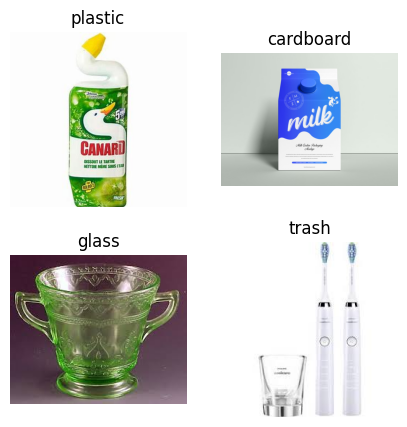

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # Display 4 images
axes = axes.ravel()

for i in np.arange(0, 4):
    category = random.choice(os.listdir(train_path))  # Randomly choose a class
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Randomly choose an image from that class

    img = plt.imread(os.path.join(class_dir, image))
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Metal: 795
Plastic: 1528
Trash: 617
Cardboard: 1446
Paper: 1315
Glass: 2431
Biological: 786

Total number of train images: 8918


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[786, 1446, 2431, 795, 1315, 1528, 617]

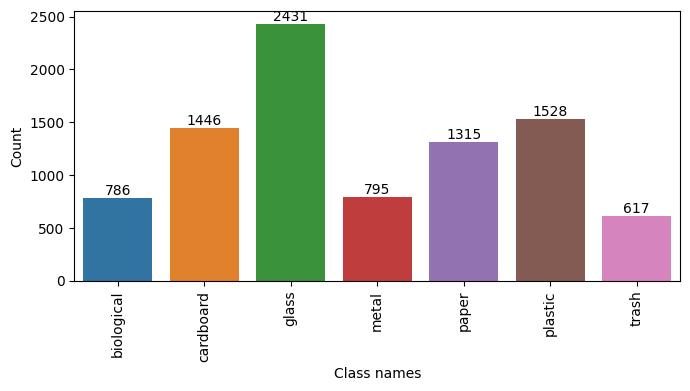

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

### Class Imbalance in the Dataset

A situation where one or more classes contain a significantly larger number of images is known as **class imbalance**. In our case, this imbalance is expected and reflects the nature of real-world waste distribution. For example:

- **Glass**: 3,039 images  
- **Plastic**: 1,915 images  
- **Cardboard**: 1,810 images  
- **Paper**: 1,650 images  
- **Metal**: 994 images  
- **Biological**: 983 images  
- **Trash**: 772 images  

This imbalance can negatively affect the model’s performance, leading it to favor the larger classes and perform poorly on the underrepresented ones.

To address this issue, we will apply **random undersampling**, a technique that balances the dataset by randomly removing some examples from the overrepresented classes. This helps reduce model bias and improves its ability to generalize across all categories.


Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in metal
Deleted 528 in plastic
Deleted 0 in trash
Deleted 446 in cardboard
Deleted 315 in paper
Deleted 1431 in glass
Deleted 0 in biological


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

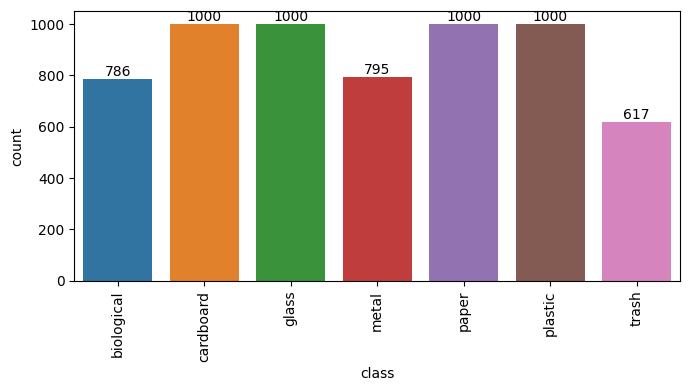

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 444.5349
Mean Height: 418.6280


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 6198 files belonging to 7 classes.


I0000 00:00:1749465369.754831      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749465369.755593      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1121 files belonging to 7 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1112 files belonging to 7 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:

prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 10:36:11] Energy consumed for RAM : 0.000576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:36:11] Delta energy consumed for CPU with constant : 0.000162 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:11] Energy consumed for All CPU : 0.001224 kWh
[codecarbon INFO @ 10:36:11] Energy consumed for all GPUs : 0.000588 kWh. Total GPU Power : 25.126890417414767 W
[codecarbon INFO @ 10:36:11] 0.002389 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0010812484015410941 kg


# Building the model

In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon WARNING @ 10:36:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:36:11] [setup] RAM Tracking...
[codecarbon INFO @ 10:36:11] [setup] CPU Tracking...
[codecarbon WARNING @ 10:36:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:36:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:36:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 10:36:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:36:13] [setup] GPU Tracking...
[codecarbon INFO @ 10:36:13] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:36:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the ResNet50 model was selected.


Loading the model

In [43]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 406, 406, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 200, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 200, 200, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 200, 200, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 202, 202, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 100, 100, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 100, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 100, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 100, 100, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 100, 100, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

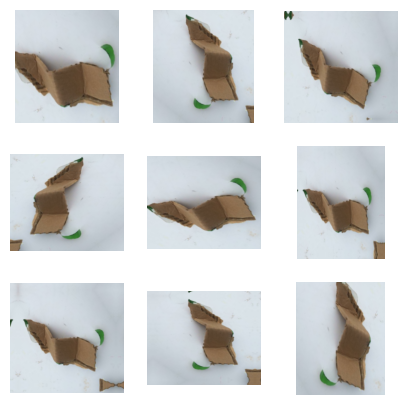

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="ResNet50"

ResNet50_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
ResNet50_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
ResNet50_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, None, None, 2048)    │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
ResNet50_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()

tracker = EmissionsTracker()
tracker.start()
    
ResNet50_history = ResNet50_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=ResNet50_callback)

[codecarbon WARNING @ 10:36:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:36:22] [setup] RAM Tracking...
[codecarbon INFO @ 10:36:22] [setup] CPU Tracking...
[codecarbon WARNING @ 10:36:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:36:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:36:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 10:36:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:36:23] [setup] GPU Tracking...
[codecarbon INFO @ 10:36:23] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:36:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/20


[codecarbon INFO @ 10:36:31] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:36:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:31] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:36:31] Energy consumed for all GPUs : 0.000225 kWh. Total GPU Power : 54.05962905772556 W
[codecarbon INFO @ 10:36:31] 0.000486 kWh of electricity used since the beginning.
I0000 00:00:1749465398.048699     230 cuda_dnn.cc:529] Loaded cuDNN version 90300
[codecarbon INFO @ 10:36:41] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:36:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:41] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:36:41] Energy consumed for all GPUs : 0.000254 kWh. Total GPU Power : 60.99508884938176 W
[codecarbon INFO @ 10:36:41] 0.000515 kWh of electricity used since the beginning.


  3/194 ━━━━━━━━━━━━━━━━━━━━ 6:47 2s/step - accuracy: 0.1267 - loss: 2.3141

[codecarbon INFO @ 10:36:46] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:36:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:46] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:36:46] Energy consumed for all GPUs : 0.000533 kWh. Total GPU Power : 73.98180312957898 W
[codecarbon INFO @ 10:36:46] 0.001054 kWh of electricity used since the beginning.


  7/194 ━━━━━━━━━━━━━━━━━━━━ 7:22 2s/step - accuracy: 0.1746 - loss: 2.1974

[codecarbon INFO @ 10:36:56] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:36:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:36:56] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:36:56] Energy consumed for all GPUs : 0.000652 kWh. Total GPU Power : 95.58958332513967 W
[codecarbon INFO @ 10:36:56] 0.001173 kWh of electricity used since the beginning.


  8/194 ━━━━━━━━━━━━━━━━━━━━ 7:26 2s/step - accuracy: 0.1894 - loss: 2.1603

[codecarbon INFO @ 10:37:01] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:01] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 10:37:01] Energy consumed for all GPUs : 0.000933 kWh. Total GPU Power : 96.04627149173469 W
[codecarbon INFO @ 10:37:01] 0.001714 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 7:23 2s/step - accuracy: 0.2492 - loss: 2.0131

[codecarbon INFO @ 10:37:11] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:11] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 10:37:11] Energy consumed for all GPUs : 0.001050 kWh. Total GPU Power : 95.55094989780657 W
[codecarbon INFO @ 10:37:11] 0.001832 kWh of electricity used since the beginning.


 15/194 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.2696 - loss: 1.9633

[codecarbon INFO @ 10:37:16] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:16] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 10:37:16] Energy consumed for all GPUs : 0.001332 kWh. Total GPU Power : 95.66486169775617 W
[codecarbon INFO @ 10:37:16] 0.002373 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 7:11 2s/step - accuracy: 0.3047 - loss: 1.8760

[codecarbon INFO @ 10:37:26] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:26] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 10:37:26] Energy consumed for all GPUs : 0.001448 kWh. Total GPU Power : 95.6272135999033 W
[codecarbon INFO @ 10:37:26] 0.002489 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.3198 - loss: 1.8392

[codecarbon INFO @ 10:37:31] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:31] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:37:31] Energy consumed for all GPUs : 0.001728 kWh. Total GPU Power : 95.26158076469245 W
[codecarbon INFO @ 10:37:31] 0.003030 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 6:34 2s/step - accuracy: 0.3533 - loss: 1.7567

[codecarbon INFO @ 10:37:41] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:41] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:37:41] Energy consumed for all GPUs : 0.001847 kWh. Total GPU Power : 95.68257048173842 W
[codecarbon INFO @ 10:37:41] 0.003148 kWh of electricity used since the beginning.


 28/194 ━━━━━━━━━━━━━━━━━━━━ 6:30 2s/step - accuracy: 0.3646 - loss: 1.7288

[codecarbon INFO @ 10:37:46] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:46] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:37:46] Energy consumed for all GPUs : 0.002128 kWh. Total GPU Power : 95.8295826713126 W
[codecarbon INFO @ 10:37:46] 0.003689 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - accuracy: 0.3898 - loss: 1.6650

[codecarbon INFO @ 10:37:56] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:37:56] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:37:56] Energy consumed for all GPUs : 0.002243 kWh. Total GPU Power : 95.17543198186848 W
[codecarbon INFO @ 10:37:56] 0.003805 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - accuracy: 0.3990 - loss: 1.6413

[codecarbon INFO @ 10:38:01] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:01] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 10:38:01] Energy consumed for all GPUs : 0.002523 kWh. Total GPU Power : 94.85028598275346 W
[codecarbon INFO @ 10:38:01] 0.004344 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.4197 - loss: 1.5873

[codecarbon INFO @ 10:38:11] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:11] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 10:38:11] Energy consumed for all GPUs : 0.002638 kWh. Total GPU Power : 94.88006211078773 W
[codecarbon INFO @ 10:38:11] 0.004460 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 5:40 2s/step - accuracy: 0.4306 - loss: 1.5584

[codecarbon INFO @ 10:38:16] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:16] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:38:16] Energy consumed for all GPUs : 0.002918 kWh. Total GPU Power : 94.96201693620391 W
[codecarbon INFO @ 10:38:16] 0.005000 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:16] 0.018856 g.CO2eq/s mean an estimation of 594.6583428625252 kg.CO2eq/year


 46/194 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.4404 - loss: 1.5323

[codecarbon INFO @ 10:38:26] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:26] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 10:38:26] Energy consumed for all GPUs : 0.003035 kWh. Total GPU Power : 95.14543176316471 W
[codecarbon INFO @ 10:38:26] 0.005117 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:26] 0.019297 g.CO2eq/s mean an estimation of 608.5631551077813 kg.CO2eq/year


 48/194 ━━━━━━━━━━━━━━━━━━━━ 5:37 2s/step - accuracy: 0.4466 - loss: 1.5162

[codecarbon INFO @ 10:38:31] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:31] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:38:31] Energy consumed for all GPUs : 0.003313 kWh. Total GPU Power : 94.75123880175093 W
[codecarbon INFO @ 10:38:31] 0.005655 kWh of electricity used since the beginning.


 53/194 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.4611 - loss: 1.4788

[codecarbon INFO @ 10:38:41] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:41] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 10:38:41] Energy consumed for all GPUs : 0.003429 kWh. Total GPU Power : 94.71023640433114 W
[codecarbon INFO @ 10:38:41] 0.005772 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.4691 - loss: 1.4582

[codecarbon INFO @ 10:38:46] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:46] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 10:38:46] Energy consumed for all GPUs : 0.003709 kWh. Total GPU Power : 95.12000200721334 W
[codecarbon INFO @ 10:38:46] 0.006311 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 4:58 2s/step - accuracy: 0.4815 - loss: 1.4262

[codecarbon INFO @ 10:38:56] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:38:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:38:56] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 10:38:56] Energy consumed for all GPUs : 0.003825 kWh. Total GPU Power : 95.05152152118343 W
[codecarbon INFO @ 10:38:56] 0.006428 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.4861 - loss: 1.4142

[codecarbon INFO @ 10:39:01] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:01] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 10:39:01] Energy consumed for all GPUs : 0.004106 kWh. Total GPU Power : 95.35757260794415 W
[codecarbon INFO @ 10:39:01] 0.006969 kWh of electricity used since the beginning.


 68/194 ━━━━━━━━━━━━━━━━━━━━ 4:38 2s/step - accuracy: 0.4968 - loss: 1.3861

[codecarbon INFO @ 10:39:11] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:11] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 10:39:11] Energy consumed for all GPUs : 0.004225 kWh. Total GPU Power : 96.0314667657155 W
[codecarbon INFO @ 10:39:11] 0.007088 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.5028 - loss: 1.3707

[codecarbon INFO @ 10:39:16] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:16] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 10:39:16] Energy consumed for all GPUs : 0.004505 kWh. Total GPU Power : 95.85558877565136 W
[codecarbon INFO @ 10:39:16] 0.007629 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.5102 - loss: 1.3512

[codecarbon INFO @ 10:39:26] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:26] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 10:39:26] Energy consumed for all GPUs : 0.004624 kWh. Total GPU Power : 95.78415095384695 W
[codecarbon INFO @ 10:39:26] 0.007747 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.5155 - loss: 1.3374

[codecarbon INFO @ 10:39:31] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:31] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 10:39:31] Energy consumed for all GPUs : 0.004905 kWh. Total GPU Power : 95.87229337519116 W
[codecarbon INFO @ 10:39:31] 0.008288 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - accuracy: 0.5238 - loss: 1.3156

[codecarbon INFO @ 10:39:41] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:41] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 10:39:41] Energy consumed for all GPUs : 0.005023 kWh. Total GPU Power : 95.79409610719466 W
[codecarbon INFO @ 10:39:41] 0.008407 kWh of electricity used since the beginning.


 85/194 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.5270 - loss: 1.3073

[codecarbon INFO @ 10:39:46] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:46] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 10:39:46] Energy consumed for all GPUs : 0.005304 kWh. Total GPU Power : 95.8393237076206 W
[codecarbon INFO @ 10:39:46] 0.008947 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 3:47 2s/step - accuracy: 0.5346 - loss: 1.2876

[codecarbon INFO @ 10:39:56] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:39:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:39:56] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 10:39:56] Energy consumed for all GPUs : 0.005425 kWh. Total GPU Power : 96.4507738591715 W
[codecarbon INFO @ 10:39:56] 0.009069 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - accuracy: 0.5375 - loss: 1.2800

[codecarbon INFO @ 10:40:01] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:01] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 10:40:01] Energy consumed for all GPUs : 0.005706 kWh. Total GPU Power : 96.52702893817539 W
[codecarbon INFO @ 10:40:01] 0.009610 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.5445 - loss: 1.2618

[codecarbon INFO @ 10:40:11] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:11] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 10:40:11] Energy consumed for all GPUs : 0.005824 kWh. Total GPU Power : 96.00263406005696 W
[codecarbon INFO @ 10:40:11] 0.009729 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.5484 - loss: 1.2515

[codecarbon INFO @ 10:40:16] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:16] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 10:40:16] Energy consumed for all GPUs : 0.006107 kWh. Total GPU Power : 96.27540862185695 W
[codecarbon INFO @ 10:40:16] 0.010271 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:16] 0.019880 g.CO2eq/s mean an estimation of 626.9202632452856 kg.CO2eq/year


105/194 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - accuracy: 0.5546 - loss: 1.2349

[codecarbon INFO @ 10:40:26] Energy consumed for RAM : 0.001333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:26] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 10:40:26] Energy consumed for all GPUs : 0.006228 kWh. Total GPU Power : 96.90227363757501 W
[codecarbon INFO @ 10:40:26] 0.010392 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:26] 0.019898 g.CO2eq/s mean an estimation of 627.4880428581947 kg.CO2eq/year


107/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.5570 - loss: 1.2286

[codecarbon INFO @ 10:40:31] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:31] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 10:40:31] Energy consumed for all GPUs : 0.006509 kWh. Total GPU Power : 96.74673543702801 W
[codecarbon INFO @ 10:40:31] 0.010934 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.5628 - loss: 1.2131

[codecarbon INFO @ 10:40:41] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:41] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 10:40:41] Energy consumed for all GPUs : 0.006630 kWh. Total GPU Power : 96.48000223093598 W
[codecarbon INFO @ 10:40:41] 0.011055 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.5650 - loss: 1.2071

[codecarbon INFO @ 10:40:46] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:46] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 10:40:46] Energy consumed for all GPUs : 0.006912 kWh. Total GPU Power : 96.75834569116566 W
[codecarbon INFO @ 10:40:46] 0.011597 kWh of electricity used since the beginning.


119/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.5705 - loss: 1.1925

[codecarbon INFO @ 10:40:56] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:40:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:40:56] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 10:40:56] Energy consumed for all GPUs : 0.007033 kWh. Total GPU Power : 96.73317569124299 W
[codecarbon INFO @ 10:40:56] 0.011718 kWh of electricity used since the beginning.


121/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.5726 - loss: 1.1868

[codecarbon INFO @ 10:41:01] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:01] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 10:41:01] Energy consumed for all GPUs : 0.007315 kWh. Total GPU Power : 96.58526955749763 W
[codecarbon INFO @ 10:41:01] 0.012260 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.5788 - loss: 1.1702

[codecarbon INFO @ 10:41:11] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:11] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 10:41:11] Energy consumed for all GPUs : 0.007438 kWh. Total GPU Power : 97.19529310415057 W
[codecarbon INFO @ 10:41:11] 0.012383 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.5817 - loss: 1.1624

[codecarbon INFO @ 10:41:16] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:16] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 10:41:16] Energy consumed for all GPUs : 0.007719 kWh. Total GPU Power : 97.16813668215337 W
[codecarbon INFO @ 10:41:16] 0.012925 kWh of electricity used since the beginning.


136/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.5873 - loss: 1.1473

[codecarbon INFO @ 10:41:26] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:26] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 10:41:26] Energy consumed for all GPUs : 0.007840 kWh. Total GPU Power : 96.63623633438576 W
[codecarbon INFO @ 10:41:26] 0.013045 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - accuracy: 0.5891 - loss: 1.1424

[codecarbon INFO @ 10:41:31] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:31] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 10:41:31] Energy consumed for all GPUs : 0.008122 kWh. Total GPU Power : 96.65575086743405 W
[codecarbon INFO @ 10:41:31] 0.013588 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.5936 - loss: 1.1305

[codecarbon INFO @ 10:41:41] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:41] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 10:41:41] Energy consumed for all GPUs : 0.008244 kWh. Total GPU Power : 97.10412579409724 W
[codecarbon INFO @ 10:41:41] 0.013710 kWh of electricity used since the beginning.


146/194 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - accuracy: 0.5962 - loss: 1.1236

[codecarbon INFO @ 10:41:46] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:46] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 10:41:46] Energy consumed for all GPUs : 0.008527 kWh. Total GPU Power : 97.13467513919866 W
[codecarbon INFO @ 10:41:46] 0.014253 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.6002 - loss: 1.1125

[codecarbon INFO @ 10:41:56] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:41:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:41:56] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 10:41:56] Energy consumed for all GPUs : 0.008648 kWh. Total GPU Power : 96.9105489358541 W
[codecarbon INFO @ 10:41:56] 0.014374 kWh of electricity used since the beginning.


153/194 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.6018 - loss: 1.1082

[codecarbon INFO @ 10:42:01] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:01] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 10:42:01] Energy consumed for all GPUs : 0.008931 kWh. Total GPU Power : 97.18412566652741 W
[codecarbon INFO @ 10:42:01] 0.014918 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.6057 - loss: 1.0977

[codecarbon INFO @ 10:42:11] Energy consumed for RAM : 0.001916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:11] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 10:42:11] Energy consumed for all GPUs : 0.009055 kWh. Total GPU Power : 97.72554470940834 W
[codecarbon INFO @ 10:42:11] 0.015041 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.6079 - loss: 1.0916

[codecarbon INFO @ 10:42:16] Energy consumed for RAM : 0.001999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:16] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 10:42:16] Energy consumed for all GPUs : 0.009337 kWh. Total GPU Power : 97.49531129213332 W
[codecarbon INFO @ 10:42:16] 0.015584 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:16] 0.020041 g.CO2eq/s mean an estimation of 631.9997522410589 kg.CO2eq/year


165/194 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.6108 - loss: 1.0837

[codecarbon INFO @ 10:42:26] Energy consumed for RAM : 0.001999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:26] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 10:42:26] Energy consumed for all GPUs : 0.009460 kWh. Total GPU Power : 97.20560610051119 W
[codecarbon INFO @ 10:42:26] 0.015707 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:26] 0.020044 g.CO2eq/s mean an estimation of 632.1024583642484 kg.CO2eq/year


167/194 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6122 - loss: 1.0799

[codecarbon INFO @ 10:42:31] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:31] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 10:42:31] Energy consumed for all GPUs : 0.009744 kWh. Total GPU Power : 97.52769301581324 W
[codecarbon INFO @ 10:42:31] 0.016251 kWh of electricity used since the beginning.


173/194 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6164 - loss: 1.0689

[codecarbon INFO @ 10:42:41] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:41] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 10:42:41] Energy consumed for all GPUs : 0.009868 kWh. Total GPU Power : 98.03988718683085 W
[codecarbon INFO @ 10:42:41] 0.016375 kWh of electricity used since the beginning.


175/194 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6177 - loss: 1.0653

[codecarbon INFO @ 10:42:46] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:46] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 10:42:46] Energy consumed for all GPUs : 0.010151 kWh. Total GPU Power : 97.87573596310683 W
[codecarbon INFO @ 10:42:46] 0.016918 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6222 - loss: 1.0531

[codecarbon INFO @ 10:42:56] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:42:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:56] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 10:42:56] Energy consumed for all GPUs : 0.010276 kWh. Total GPU Power : 97.76897252477299 W
[codecarbon INFO @ 10:42:56] 0.017043 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6241 - loss: 1.0481

[codecarbon INFO @ 10:43:01] Energy consumed for RAM : 0.002249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:01] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 10:43:01] Energy consumed for all GPUs : 0.010559 kWh. Total GPU Power : 97.84356827930235 W
[codecarbon INFO @ 10:43:01] 0.017586 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6283 - loss: 1.0369

[codecarbon INFO @ 10:43:11] Energy consumed for RAM : 0.002249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:11] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 10:43:11] Energy consumed for all GPUs : 0.010682 kWh. Total GPU Power : 97.56067761106323 W
[codecarbon INFO @ 10:43:11] 0.017710 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6295 - loss: 1.0338

[codecarbon INFO @ 10:43:16] Energy consumed for RAM : 0.002332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:16] Energy consumed for All CPU : 0.004956 kWh
[codecarbon INFO @ 10:43:16] Energy consumed for all GPUs : 0.010960 kWh. Total GPU Power : 96.257772599791 W
[codecarbon INFO @ 10:43:16] 0.018248 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:26] Energy consumed for RAM : 0.002332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:26] Energy consumed for All CPU : 0.004956 kWh
[codecarbon INFO @ 10:43:26] Energy consumed for all GPUs : 0.011064 kWh. Total GPU Power : 91.67485693152896 W
[codecarbon INFO @ 10:43:26] 0.018352 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:31] Energy consumed for RAM : 0.002415 kWh. RAM Power : 20.

194/194 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.6300 - loss: 1.0322 - val_accuracy: 0.8615 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 2/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8047 - loss: 0.5087

[codecarbon INFO @ 10:43:41] Energy consumed for RAM : 0.002415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:41] Energy consumed for All CPU : 0.005133 kWh
[codecarbon INFO @ 10:43:41] Energy consumed for all GPUs : 0.011468 kWh. Total GPU Power : 97.11887864302129 W
[codecarbon INFO @ 10:43:41] 0.019016 kWh of electricity used since the beginning.


  4/194 ━━━━━━━━━━━━━━━━━━━━ 6:37 2s/step - accuracy: 0.8177 - loss: 0.5008

[codecarbon INFO @ 10:43:46] Energy consumed for RAM : 0.002498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:46] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 10:43:46] Energy consumed for all GPUs : 0.011753 kWh. Total GPU Power : 97.3155903313243 W
[codecarbon INFO @ 10:43:46] 0.019561 kWh of electricity used since the beginning.


 10/194 ━━━━━━━━━━━━━━━━━━━━ 5:54 2s/step - accuracy: 0.8329 - loss: 0.4803

[codecarbon INFO @ 10:43:56] Energy consumed for RAM : 0.002499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:43:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:43:56] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 10:43:56] Energy consumed for all GPUs : 0.011878 kWh. Total GPU Power : 98.50039554661113 W
[codecarbon INFO @ 10:43:56] 0.019687 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.8344 - loss: 0.4765

[codecarbon INFO @ 10:44:01] Energy consumed for RAM : 0.002582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:01] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 10:44:01] Energy consumed for all GPUs : 0.012162 kWh. Total GPU Power : 98.19844931210172 W
[codecarbon INFO @ 10:44:01] 0.020230 kWh of electricity used since the beginning.


 20/194 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.8346 - loss: 0.4781

[codecarbon INFO @ 10:44:11] Energy consumed for RAM : 0.002582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:11] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 10:44:11] Energy consumed for all GPUs : 0.012287 kWh. Total GPU Power : 98.02699187884205 W
[codecarbon INFO @ 10:44:11] 0.020355 kWh of electricity used since the beginning.


 22/194 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8347 - loss: 0.4793

[codecarbon INFO @ 10:44:16] Energy consumed for RAM : 0.002665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:16] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 10:44:16] Energy consumed for all GPUs : 0.012570 kWh. Total GPU Power : 98.11389673143384 W
[codecarbon INFO @ 10:44:16] 0.020899 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:16] 0.020046 g.CO2eq/s mean an estimation of 632.1612348381809 kg.CO2eq/year


 30/194 ━━━━━━━━━━━━━━━━━━━━ 4:33 2s/step - accuracy: 0.8345 - loss: 0.4833

[codecarbon INFO @ 10:44:26] Energy consumed for RAM : 0.002665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:26] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 10:44:26] Energy consumed for all GPUs : 0.012695 kWh. Total GPU Power : 97.94472042939462 W
[codecarbon INFO @ 10:44:26] 0.021023 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:26] 0.020052 g.CO2eq/s mean an estimation of 632.3749393512611 kg.CO2eq/year


 32/194 ━━━━━━━━━━━━━━━━━━━━ 4:27 2s/step - accuracy: 0.8345 - loss: 0.4837

[codecarbon INFO @ 10:44:31] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:31] Energy consumed for All CPU : 0.005841 kWh
[codecarbon INFO @ 10:44:31] Energy consumed for all GPUs : 0.012978 kWh. Total GPU Power : 97.95259309823295 W
[codecarbon INFO @ 10:44:31] 0.021567 kWh of electricity used since the beginning.


 38/194 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.8342 - loss: 0.4863

[codecarbon INFO @ 10:44:41] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:41] Energy consumed for All CPU : 0.005841 kWh
[codecarbon INFO @ 10:44:41] Energy consumed for all GPUs : 0.013105 kWh. Total GPU Power : 98.60150985656243 W
[codecarbon INFO @ 10:44:41] 0.021694 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8340 - loss: 0.4874

[codecarbon INFO @ 10:44:46] Energy consumed for RAM : 0.002832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:46] Energy consumed for All CPU : 0.006018 kWh
[codecarbon INFO @ 10:44:46] Energy consumed for all GPUs : 0.013389 kWh. Total GPU Power : 98.65073159120428 W
[codecarbon INFO @ 10:44:46] 0.022238 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 4:13 2s/step - accuracy: 0.8331 - loss: 0.4905

[codecarbon INFO @ 10:44:56] Energy consumed for RAM : 0.002832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:44:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:44:56] Energy consumed for All CPU : 0.006018 kWh
[codecarbon INFO @ 10:44:56] Energy consumed for all GPUs : 0.013514 kWh. Total GPU Power : 98.10040027839858 W
[codecarbon INFO @ 10:44:56] 0.022363 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.8326 - loss: 0.4919

[codecarbon INFO @ 10:45:01] Energy consumed for RAM : 0.002915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:01] Energy consumed for All CPU : 0.006194 kWh
[codecarbon INFO @ 10:45:01] Energy consumed for all GPUs : 0.013799 kWh. Total GPU Power : 98.37024927121716 W
[codecarbon INFO @ 10:45:01] 0.022908 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 0.8320 - loss: 0.4935

[codecarbon INFO @ 10:45:11] Energy consumed for RAM : 0.002915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:11] Energy consumed for All CPU : 0.006195 kWh
[codecarbon INFO @ 10:45:11] Energy consumed for all GPUs : 0.013926 kWh. Total GPU Power : 98.91140207152402 W
[codecarbon INFO @ 10:45:11] 0.023035 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 4:02 2s/step - accuracy: 0.8317 - loss: 0.4941

[codecarbon INFO @ 10:45:16] Energy consumed for RAM : 0.002998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:16] Energy consumed for All CPU : 0.006371 kWh
[codecarbon INFO @ 10:45:16] Energy consumed for all GPUs : 0.014208 kWh. Total GPU Power : 98.33540137458421 W
[codecarbon INFO @ 10:45:16] 0.023578 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8312 - loss: 0.4948

[codecarbon INFO @ 10:45:26] Energy consumed for RAM : 0.002998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:26] Energy consumed for All CPU : 0.006372 kWh
[codecarbon INFO @ 10:45:26] Energy consumed for all GPUs : 0.014335 kWh. Total GPU Power : 98.4079749375698 W
[codecarbon INFO @ 10:45:26] 0.023705 kWh of electricity used since the beginning.


 64/194 ━━━━━━━━━━━━━━━━━━━━ 3:52 2s/step - accuracy: 0.8309 - loss: 0.4952

[codecarbon INFO @ 10:45:31] Energy consumed for RAM : 0.003081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:31] Energy consumed for All CPU : 0.006549 kWh
[codecarbon INFO @ 10:45:31] Energy consumed for all GPUs : 0.014620 kWh. Total GPU Power : 98.91515938388501 W
[codecarbon INFO @ 10:45:31] 0.024250 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.8308 - loss: 0.4951

[codecarbon INFO @ 10:45:41] Energy consumed for RAM : 0.003081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:41] Energy consumed for All CPU : 0.006549 kWh
[codecarbon INFO @ 10:45:41] Energy consumed for all GPUs : 0.014746 kWh. Total GPU Power : 98.45254758131772 W
[codecarbon INFO @ 10:45:41] 0.024376 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.8308 - loss: 0.4949

[codecarbon INFO @ 10:45:46] Energy consumed for RAM : 0.003165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:46] Energy consumed for All CPU : 0.006726 kWh
[codecarbon INFO @ 10:45:46] Energy consumed for all GPUs : 0.015030 kWh. Total GPU Power : 98.28028939368156 W
[codecarbon INFO @ 10:45:46] 0.024920 kWh of electricity used since the beginning.


 79/194 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - accuracy: 0.8309 - loss: 0.4941

[codecarbon INFO @ 10:45:56] Energy consumed for RAM : 0.003165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:45:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:45:56] Energy consumed for All CPU : 0.006726 kWh
[codecarbon INFO @ 10:45:56] Energy consumed for all GPUs : 0.015158 kWh. Total GPU Power : 99.09486116001881 W
[codecarbon INFO @ 10:45:56] 0.025049 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - accuracy: 0.8310 - loss: 0.4937

[codecarbon INFO @ 10:46:01] Energy consumed for RAM : 0.003248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:01] Energy consumed for All CPU : 0.006903 kWh
[codecarbon INFO @ 10:46:01] Energy consumed for all GPUs : 0.015442 kWh. Total GPU Power : 99.12639357395602 W
[codecarbon INFO @ 10:46:01] 0.025593 kWh of electricity used since the beginning.


 89/194 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8311 - loss: 0.4926

[codecarbon INFO @ 10:46:11] Energy consumed for RAM : 0.003248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:11] Energy consumed for All CPU : 0.006903 kWh
[codecarbon INFO @ 10:46:11] Energy consumed for all GPUs : 0.015568 kWh. Total GPU Power : 98.4679236125974 W
[codecarbon INFO @ 10:46:11] 0.025719 kWh of electricity used since the beginning.


 91/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.8311 - loss: 0.4923

[codecarbon INFO @ 10:46:16] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:16] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 10:46:16] Energy consumed for all GPUs : 0.015854 kWh. Total GPU Power : 98.75237095600367 W
[codecarbon INFO @ 10:46:16] 0.026264 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:16] 0.020238 g.CO2eq/s mean an estimation of 638.216306186012 kg.CO2eq/year


 98/194 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.8313 - loss: 0.4911

[codecarbon INFO @ 10:46:26] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:26] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 10:46:26] Energy consumed for all GPUs : 0.015980 kWh. Total GPU Power : 98.75693961945771 W
[codecarbon INFO @ 10:46:26] 0.026391 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:26] 0.020242 g.CO2eq/s mean an estimation of 638.3660234172896 kg.CO2eq/year


101/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8314 - loss: 0.4905

[codecarbon INFO @ 10:46:31] Energy consumed for RAM : 0.003415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:31] Energy consumed for All CPU : 0.007256 kWh
[codecarbon INFO @ 10:46:31] Energy consumed for all GPUs : 0.016264 kWh. Total GPU Power : 98.5413594228706 W
[codecarbon INFO @ 10:46:31] 0.026935 kWh of electricity used since the beginning.


108/194 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.8318 - loss: 0.4888

[codecarbon INFO @ 10:46:41] Energy consumed for RAM : 0.003415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:41] Energy consumed for All CPU : 0.007257 kWh
[codecarbon INFO @ 10:46:41] Energy consumed for all GPUs : 0.016392 kWh. Total GPU Power : 99.09926814451633 W
[codecarbon INFO @ 10:46:41] 0.027063 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8320 - loss: 0.4879

[codecarbon INFO @ 10:46:46] Energy consumed for RAM : 0.003498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:46] Energy consumed for All CPU : 0.007433 kWh
[codecarbon INFO @ 10:46:46] Energy consumed for all GPUs : 0.016678 kWh. Total GPU Power : 99.34145326718355 W
[codecarbon INFO @ 10:46:46] 0.027609 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8325 - loss: 0.4859

[codecarbon INFO @ 10:46:56] Energy consumed for RAM : 0.003498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:46:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:46:56] Energy consumed for All CPU : 0.007434 kWh
[codecarbon INFO @ 10:46:56] Energy consumed for all GPUs : 0.016804 kWh. Total GPU Power : 98.86066712090496 W
[codecarbon INFO @ 10:46:56] 0.027735 kWh of electricity used since the beginning.


120/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.8327 - loss: 0.4853

[codecarbon INFO @ 10:47:01] Energy consumed for RAM : 0.003581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:01] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 10:47:01] Energy consumed for all GPUs : 0.017088 kWh. Total GPU Power : 98.55881890929591 W
[codecarbon INFO @ 10:47:01] 0.028280 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.8333 - loss: 0.4835

[codecarbon INFO @ 10:47:11] Energy consumed for RAM : 0.003581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:11] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 10:47:11] Energy consumed for all GPUs : 0.017218 kWh. Total GPU Power : 99.35929379762396 W
[codecarbon INFO @ 10:47:11] 0.028409 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8335 - loss: 0.4827

[codecarbon INFO @ 10:47:16] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:16] Energy consumed for All CPU : 0.007787 kWh
[codecarbon INFO @ 10:47:16] Energy consumed for all GPUs : 0.017501 kWh. Total GPU Power : 98.94976375033917 W
[codecarbon INFO @ 10:47:16] 0.028952 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8342 - loss: 0.4809

[codecarbon INFO @ 10:47:26] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:26] Energy consumed for All CPU : 0.007788 kWh
[codecarbon INFO @ 10:47:26] Energy consumed for all GPUs : 0.017629 kWh. Total GPU Power : 98.82145579894788 W
[codecarbon INFO @ 10:47:26] 0.029081 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8345 - loss: 0.4801

[codecarbon INFO @ 10:47:31] Energy consumed for RAM : 0.003748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:31] Energy consumed for All CPU : 0.007964 kWh
[codecarbon INFO @ 10:47:31] Energy consumed for all GPUs : 0.017915 kWh. Total GPU Power : 99.62491758046902 W
[codecarbon INFO @ 10:47:31] 0.029627 kWh of electricity used since the beginning.


147/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8351 - loss: 0.4783

[codecarbon INFO @ 10:47:41] Energy consumed for RAM : 0.003748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:41] Energy consumed for All CPU : 0.007965 kWh
[codecarbon INFO @ 10:47:41] Energy consumed for all GPUs : 0.018042 kWh. Total GPU Power : 99.11994655212716 W
[codecarbon INFO @ 10:47:41] 0.029754 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8355 - loss: 0.4773

[codecarbon INFO @ 10:47:46] Energy consumed for RAM : 0.003831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:46] Energy consumed for All CPU : 0.008141 kWh
[codecarbon INFO @ 10:47:46] Energy consumed for all GPUs : 0.018327 kWh. Total GPU Power : 98.82049321002948 W
[codecarbon INFO @ 10:47:46] 0.030299 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8359 - loss: 0.4759

[codecarbon INFO @ 10:47:56] Energy consumed for RAM : 0.003831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:47:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:47:56] Energy consumed for All CPU : 0.008142 kWh
[codecarbon INFO @ 10:47:56] Energy consumed for all GPUs : 0.018454 kWh. Total GPU Power : 98.81086411019879 W
[codecarbon INFO @ 10:47:56] 0.030426 kWh of electricity used since the beginning.


159/194 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8361 - loss: 0.4755

[codecarbon INFO @ 10:48:01] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:01] Energy consumed for All CPU : 0.008318 kWh
[codecarbon INFO @ 10:48:01] Energy consumed for all GPUs : 0.018740 kWh. Total GPU Power : 99.09474726398349 W
[codecarbon INFO @ 10:48:01] 0.030972 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8365 - loss: 0.4740

[codecarbon INFO @ 10:48:11] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:11] Energy consumed for All CPU : 0.008319 kWh
[codecarbon INFO @ 10:48:11] Energy consumed for all GPUs : 0.018869 kWh. Total GPU Power : 99.66424976368543 W
[codecarbon INFO @ 10:48:11] 0.031102 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8367 - loss: 0.4736

[codecarbon INFO @ 10:48:16] Energy consumed for RAM : 0.003998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:16] Energy consumed for All CPU : 0.008495 kWh
[codecarbon INFO @ 10:48:16] Energy consumed for all GPUs : 0.019154 kWh. Total GPU Power : 99.42310084066771 W
[codecarbon INFO @ 10:48:16] 0.031647 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:16] 0.020300 g.CO2eq/s mean an estimation of 640.1808445197187 kg.CO2eq/year


176/194 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8372 - loss: 0.4720

[codecarbon INFO @ 10:48:26] Energy consumed for RAM : 0.003998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:26] Energy consumed for All CPU : 0.008496 kWh
[codecarbon INFO @ 10:48:26] Energy consumed for all GPUs : 0.019282 kWh. Total GPU Power : 99.21576190857517 W
[codecarbon INFO @ 10:48:26] 0.031775 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:26] 0.020311 g.CO2eq/s mean an estimation of 640.5245725314919 kg.CO2eq/year


179/194 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8374 - loss: 0.4715

[codecarbon INFO @ 10:48:31] Energy consumed for RAM : 0.004081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:31] Energy consumed for All CPU : 0.008672 kWh
[codecarbon INFO @ 10:48:31] Energy consumed for all GPUs : 0.019567 kWh. Total GPU Power : 99.35030580764848 W
[codecarbon INFO @ 10:48:31] 0.032321 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8377 - loss: 0.4705

[codecarbon INFO @ 10:48:41] Energy consumed for RAM : 0.004081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:41] Energy consumed for All CPU : 0.008673 kWh
[codecarbon INFO @ 10:48:41] Energy consumed for all GPUs : 0.019695 kWh. Total GPU Power : 99.14059081146995 W
[codecarbon INFO @ 10:48:41] 0.032448 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8378 - loss: 0.4701

[codecarbon INFO @ 10:48:46] Energy consumed for RAM : 0.004164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:46] Energy consumed for All CPU : 0.008849 kWh
[codecarbon INFO @ 10:48:46] Energy consumed for all GPUs : 0.019980 kWh. Total GPU Power : 99.05984504232487 W
[codecarbon INFO @ 10:48:46] 0.032993 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8381 - loss: 0.4694

[codecarbon INFO @ 10:48:56] Energy consumed for RAM : 0.004164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:48:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:48:56] Energy consumed for All CPU : 0.008850 kWh
[codecarbon INFO @ 10:48:56] Energy consumed for all GPUs : 0.020109 kWh. Total GPU Power : 99.28592655416269 W
[codecarbon INFO @ 10:48:56] 0.033122 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:01] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:01] Energy consumed for All CPU : 0.009026 kWh
[codecarbon INFO @ 10:49:01] Energy consumed for all GPUs : 0.020394 kWh. Total GPU Power : 99.39336692158231 W
[codecarbon INFO @ 10:49:01] 0.033668 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8381 - loss: 0.4693 - val_accuracy: 0.8993 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 3/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 844ms/step - accuracy: 0.9375 - loss: 0.3990

[codecarbon INFO @ 10:49:11] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:11] Energy consumed for All CPU : 0.009027 kWh
[codecarbon INFO @ 10:49:11] Energy consumed for all GPUs : 0.020518 kWh. Total GPU Power : 98.40762471840442 W
[codecarbon INFO @ 10:49:11] 0.033793 kWh of electricity used since the beginning.


  4/194 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.8672 - loss: 0.4376

[codecarbon INFO @ 10:49:16] Energy consumed for RAM : 0.004331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:16] Energy consumed for All CPU : 0.009203 kWh
[codecarbon INFO @ 10:49:16] Energy consumed for all GPUs : 0.020805 kWh. Total GPU Power : 98.62332976622629 W
[codecarbon INFO @ 10:49:16] 0.034339 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 4:13 1s/step - accuracy: 0.8573 - loss: 0.4218

[codecarbon INFO @ 10:49:26] Energy consumed for RAM : 0.004331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:26] Energy consumed for All CPU : 0.009204 kWh
[codecarbon INFO @ 10:49:26] Energy consumed for all GPUs : 0.020935 kWh. Total GPU Power : 99.89251306104464 W
[codecarbon INFO @ 10:49:26] 0.034469 kWh of electricity used since the beginning.


 15/194 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.8550 - loss: 0.4204

[codecarbon INFO @ 10:49:31] Energy consumed for RAM : 0.004414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:31] Energy consumed for All CPU : 0.009380 kWh
[codecarbon INFO @ 10:49:31] Energy consumed for all GPUs : 0.021220 kWh. Total GPU Power : 99.7232348699828 W
[codecarbon INFO @ 10:49:31] 0.035014 kWh of electricity used since the beginning.


 22/194 ━━━━━━━━━━━━━━━━━━━━ 4:07 1s/step - accuracy: 0.8554 - loss: 0.4115

[codecarbon INFO @ 10:49:41] Energy consumed for RAM : 0.004414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:41] Energy consumed for All CPU : 0.009381 kWh
[codecarbon INFO @ 10:49:41] Energy consumed for all GPUs : 0.021349 kWh. Total GPU Power : 99.43038391340447 W
[codecarbon INFO @ 10:49:41] 0.035143 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 3:57 1s/step - accuracy: 0.8561 - loss: 0.4095

[codecarbon INFO @ 10:49:46] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:46] Energy consumed for All CPU : 0.009557 kWh
[codecarbon INFO @ 10:49:46] Energy consumed for all GPUs : 0.021635 kWh. Total GPU Power : 99.69714587197431 W
[codecarbon INFO @ 10:49:46] 0.035690 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.8577 - loss: 0.4072

[codecarbon INFO @ 10:49:56] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:49:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:49:56] Energy consumed for All CPU : 0.009558 kWh
[codecarbon INFO @ 10:49:56] Energy consumed for all GPUs : 0.021763 kWh. Total GPU Power : 99.4983395137132 W
[codecarbon INFO @ 10:49:56] 0.035818 kWh of electricity used since the beginning.


 38/194 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - accuracy: 0.8581 - loss: 0.4068

[codecarbon INFO @ 10:50:01] Energy consumed for RAM : 0.004580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:01] Energy consumed for All CPU : 0.009734 kWh
[codecarbon INFO @ 10:50:01] Energy consumed for all GPUs : 0.022049 kWh. Total GPU Power : 99.27654163873434 W
[codecarbon INFO @ 10:50:01] 0.036363 kWh of electricity used since the beginning.


 44/194 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8585 - loss: 0.4068

[codecarbon INFO @ 10:50:11] Energy consumed for RAM : 0.004581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:11] Energy consumed for All CPU : 0.009735 kWh
[codecarbon INFO @ 10:50:11] Energy consumed for all GPUs : 0.022180 kWh. Total GPU Power : 100.05560491281172 W
[codecarbon INFO @ 10:50:11] 0.036495 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.8586 - loss: 0.4074

[codecarbon INFO @ 10:50:16] Energy consumed for RAM : 0.004664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:16] Energy consumed for All CPU : 0.009911 kWh
[codecarbon INFO @ 10:50:16] Energy consumed for all GPUs : 0.022465 kWh. Total GPU Power : 100.06771746967536 W
[codecarbon INFO @ 10:50:16] 0.037040 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:16] 0.020343 g.CO2eq/s mean an estimation of 641.5249782871853 kg.CO2eq/year


 55/194 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.8589 - loss: 0.4074

[codecarbon INFO @ 10:50:26] Energy consumed for RAM : 0.004664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:26] Energy consumed for All CPU : 0.009912 kWh
[codecarbon INFO @ 10:50:26] Energy consumed for all GPUs : 0.022593 kWh. Total GPU Power : 99.32790479656683 W
[codecarbon INFO @ 10:50:26] 0.037169 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:26] 0.020343 g.CO2eq/s mean an estimation of 641.5389473781522 kg.CO2eq/year


 58/194 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.8591 - loss: 0.4073

[codecarbon INFO @ 10:50:31] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:31] Energy consumed for All CPU : 0.010088 kWh
[codecarbon INFO @ 10:50:31] Energy consumed for all GPUs : 0.022880 kWh. Total GPU Power : 99.64582055420345 W
[codecarbon INFO @ 10:50:31] 0.037715 kWh of electricity used since the beginning.


 64/194 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.8593 - loss: 0.4073

[codecarbon INFO @ 10:50:41] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:41] Energy consumed for All CPU : 0.010089 kWh
[codecarbon INFO @ 10:50:41] Energy consumed for all GPUs : 0.023011 kWh. Total GPU Power : 100.15838636443044 W
[codecarbon INFO @ 10:50:41] 0.037846 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - accuracy: 0.8594 - loss: 0.4072

[codecarbon INFO @ 10:50:46] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:46] Energy consumed for All CPU : 0.010265 kWh
[codecarbon INFO @ 10:50:46] Energy consumed for all GPUs : 0.023295 kWh. Total GPU Power : 99.49341924949879 W
[codecarbon INFO @ 10:50:46] 0.038390 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - accuracy: 0.8599 - loss: 0.4063

[codecarbon INFO @ 10:50:56] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:50:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:50:56] Energy consumed for All CPU : 0.010266 kWh
[codecarbon INFO @ 10:50:56] Energy consumed for all GPUs : 0.023425 kWh. Total GPU Power : 99.5317046777105 W
[codecarbon INFO @ 10:50:56] 0.038521 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.8602 - loss: 0.4059

[codecarbon INFO @ 10:51:01] Energy consumed for RAM : 0.004914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:01] Energy consumed for All CPU : 0.010442 kWh
[codecarbon INFO @ 10:51:01] Energy consumed for all GPUs : 0.023712 kWh. Total GPU Power : 100.10901346874361 W
[codecarbon INFO @ 10:51:01] 0.039067 kWh of electricity used since the beginning.


 89/194 ━━━━━━━━━━━━━━━━━━━━ 2:24 1s/step - accuracy: 0.8608 - loss: 0.4050

[codecarbon INFO @ 10:51:11] Energy consumed for RAM : 0.004914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:11] Energy consumed for All CPU : 0.010442 kWh


 90/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step - accuracy: 0.8609 - loss: 0.4049

[codecarbon INFO @ 10:51:11] Energy consumed for all GPUs : 0.023840 kWh. Total GPU Power : 99.70729438230369 W
[codecarbon INFO @ 10:51:11] 0.039196 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.8612 - loss: 0.4045

[codecarbon INFO @ 10:51:16] Energy consumed for RAM : 0.004997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:16] Energy consumed for All CPU : 0.010619 kWh
[codecarbon INFO @ 10:51:16] Energy consumed for all GPUs : 0.024126 kWh. Total GPU Power : 99.47442860735784 W
[codecarbon INFO @ 10:51:16] 0.039742 kWh of electricity used since the beginning.


101/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.8616 - loss: 0.4038

[codecarbon INFO @ 10:51:26] Energy consumed for RAM : 0.004997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:26] Energy consumed for All CPU : 0.010619 kWh
[codecarbon INFO @ 10:51:26] Energy consumed for all GPUs : 0.024257 kWh. Total GPU Power : 100.14171814277417 W
[codecarbon INFO @ 10:51:26] 0.039874 kWh of electricity used since the beginning.


104/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.8618 - loss: 0.4034

[codecarbon INFO @ 10:51:31] Energy consumed for RAM : 0.005080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:31] Energy consumed for All CPU : 0.010796 kWh
[codecarbon INFO @ 10:51:31] Energy consumed for all GPUs : 0.024543 kWh. Total GPU Power : 100.26348190479162 W
[codecarbon INFO @ 10:51:31] 0.040419 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8623 - loss: 0.4023

[codecarbon INFO @ 10:51:41] Energy consumed for RAM : 0.005080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:41] Energy consumed for All CPU : 0.010796 kWh
[codecarbon INFO @ 10:51:41] Energy consumed for all GPUs : 0.024672 kWh. Total GPU Power : 99.62955470707416 W
[codecarbon INFO @ 10:51:41] 0.040549 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.8626 - loss: 0.4016

[codecarbon INFO @ 10:51:46] Energy consumed for RAM : 0.005163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:46] Energy consumed for All CPU : 0.010973 kWh
[codecarbon INFO @ 10:51:46] Energy consumed for all GPUs : 0.024958 kWh. Total GPU Power : 99.6180518657174 W
[codecarbon INFO @ 10:51:46] 0.041094 kWh of electricity used since the beginning.


124/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.8632 - loss: 0.4002

[codecarbon INFO @ 10:51:56] Energy consumed for RAM : 0.005164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:51:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:51:56] Energy consumed for All CPU : 0.010973 kWh
[codecarbon INFO @ 10:51:56] Energy consumed for all GPUs : 0.025089 kWh. Total GPU Power : 99.96925588598934 W
[codecarbon INFO @ 10:51:56] 0.041226 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.8633 - loss: 0.3997

[codecarbon INFO @ 10:52:01] Energy consumed for RAM : 0.005247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:01] Energy consumed for All CPU : 0.011150 kWh
[codecarbon INFO @ 10:52:01] Energy consumed for all GPUs : 0.025374 kWh. Total GPU Power : 99.97764938790995 W
[codecarbon INFO @ 10:52:01] 0.041771 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.8637 - loss: 0.3987

[codecarbon INFO @ 10:52:11] Energy consumed for RAM : 0.005247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:11] Energy consumed for All CPU : 0.011150 kWh
[codecarbon INFO @ 10:52:11] Energy consumed for all GPUs : 0.025505 kWh. Total GPU Power : 100.05079036286696 W
[codecarbon INFO @ 10:52:11] 0.041903 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.8639 - loss: 0.3980

[codecarbon INFO @ 10:52:16] Energy consumed for RAM : 0.005330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:16] Energy consumed for All CPU : 0.011327 kWh
[codecarbon INFO @ 10:52:16] Energy consumed for all GPUs : 0.025792 kWh. Total GPU Power : 100.35747245795558 W
[codecarbon INFO @ 10:52:16] 0.042449 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:16] 0.020401 g.CO2eq/s mean an estimation of 643.3730599457843 kg.CO2eq/year


146/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.8644 - loss: 0.3966

[codecarbon INFO @ 10:52:26] Energy consumed for RAM : 0.005330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:26] Energy consumed for All CPU : 0.011327 kWh
[codecarbon INFO @ 10:52:26] Energy consumed for all GPUs : 0.025921 kWh. Total GPU Power : 99.8842466891667 W
[codecarbon INFO @ 10:52:26] 0.042579 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:26] 0.020405 g.CO2eq/s mean an estimation of 643.5046915465937 kg.CO2eq/year


150/194 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8647 - loss: 0.3960 

[codecarbon INFO @ 10:52:31] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:31] Energy consumed for All CPU : 0.011504 kWh
[codecarbon INFO @ 10:52:31] Energy consumed for all GPUs : 0.026207 kWh. Total GPU Power : 99.63728038783107 W
[codecarbon INFO @ 10:52:31] 0.043124 kWh of electricity used since the beginning.


159/194 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8651 - loss: 0.3947

[codecarbon INFO @ 10:52:41] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:41] Energy consumed for All CPU : 0.011504 kWh
[codecarbon INFO @ 10:52:41] Energy consumed for all GPUs : 0.026338 kWh. Total GPU Power : 99.93179199395803 W
[codecarbon INFO @ 10:52:41] 0.043255 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8653 - loss: 0.3943

[codecarbon INFO @ 10:52:46] Energy consumed for RAM : 0.005496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:46] Energy consumed for All CPU : 0.011681 kWh
[codecarbon INFO @ 10:52:46] Energy consumed for all GPUs : 0.026624 kWh. Total GPU Power : 100.02233240228365 W
[codecarbon INFO @ 10:52:46] 0.043801 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8656 - loss: 0.3935

[codecarbon INFO @ 10:52:56] Energy consumed for RAM : 0.005497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:52:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:56] Energy consumed for All CPU : 0.011681 kWh
[codecarbon INFO @ 10:52:56] Energy consumed for all GPUs : 0.026755 kWh. Total GPU Power : 100.30666395595398 W
[codecarbon INFO @ 10:52:56] 0.043933 kWh of electricity used since the beginning.


173/194 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8659 - loss: 0.3928

[codecarbon INFO @ 10:53:01] Energy consumed for RAM : 0.005580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:01] Energy consumed for All CPU : 0.011858 kWh
[codecarbon INFO @ 10:53:01] Energy consumed for all GPUs : 0.027041 kWh. Total GPU Power : 100.19211581679872 W
[codecarbon INFO @ 10:53:01] 0.044479 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8663 - loss: 0.3917

[codecarbon INFO @ 10:53:11] Energy consumed for RAM : 0.005580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:11] Energy consumed for All CPU : 0.011858 kWh
[codecarbon INFO @ 10:53:11] Energy consumed for all GPUs : 0.027172 kWh. Total GPU Power : 99.95059816704199 W
[codecarbon INFO @ 10:53:11] 0.044610 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8665 - loss: 0.3912

[codecarbon INFO @ 10:53:16] Energy consumed for RAM : 0.005663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:16] Energy consumed for All CPU : 0.012035 kWh
[codecarbon INFO @ 10:53:16] Energy consumed for all GPUs : 0.027458 kWh. Total GPU Power : 100.01045574734728 W
[codecarbon INFO @ 10:53:16] 0.045156 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8670 - loss: 0.3900

[codecarbon INFO @ 10:53:26] Energy consumed for RAM : 0.005663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:26] Energy consumed for All CPU : 0.012035 kWh
[codecarbon INFO @ 10:53:26] Energy consumed for all GPUs : 0.027587 kWh. Total GPU Power : 99.76329364642541 W
[codecarbon INFO @ 10:53:26] 0.045286 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8671 - loss: 0.3898

[codecarbon INFO @ 10:53:31] Energy consumed for RAM : 0.005746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:31] Energy consumed for All CPU : 0.012212 kWh
[codecarbon INFO @ 10:53:31] Energy consumed for all GPUs : 0.027874 kWh. Total GPU Power : 99.99732405009624 W
[codecarbon INFO @ 10:53:31] 0.045832 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:41] Energy consumed for RAM : 0.005747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:41] Energy consumed for All CPU : 0.012212 kWh
[codecarbon INFO @ 10:53:41] Energy consumed for all GPUs : 0.028005 kWh. Total GPU Power : 100.42292741486705 W
[codecarbon INFO @ 10:53:41] 0.045964 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8671 - loss: 0.3896 - val_accuracy: 0.9029 - val_loss: 0.3210 - learning_rate: 0.0010
Epoch 4/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 2:09 673ms/step - accuracy: 0.8750 - loss: 0.2837

[codecarbon INFO @ 10:53:46] Energy consumed for RAM : 0.005830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:46] Energy consumed for All CPU : 0.012389 kWh
[codecarbon INFO @ 10:53:46] Energy consumed for all GPUs : 0.028287 kWh. Total GPU Power : 99.23917502301853 W
[codecarbon INFO @ 10:53:46] 0.046506 kWh of electricity used since the beginning.


  9/194 ━━━━━━━━━━━━━━━━━━━━ 4:33 1s/step - accuracy: 0.8822 - loss: 0.3005

[codecarbon INFO @ 10:53:56] Energy consumed for RAM : 0.005830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:53:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:56] Energy consumed for All CPU : 0.012389 kWh
[codecarbon INFO @ 10:53:56] Energy consumed for all GPUs : 0.028418 kWh. Total GPU Power : 99.1653042475413 W
[codecarbon INFO @ 10:53:56] 0.046637 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 4:21 1s/step - accuracy: 0.8807 - loss: 0.3121

[codecarbon INFO @ 10:54:01] Energy consumed for RAM : 0.005913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:01] Energy consumed for All CPU : 0.012566 kWh
[codecarbon INFO @ 10:54:01] Energy consumed for all GPUs : 0.028704 kWh. Total GPU Power : 100.1161249182402 W
[codecarbon INFO @ 10:54:01] 0.047183 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.8758 - loss: 0.3306

[codecarbon INFO @ 10:54:11] Energy consumed for RAM : 0.005913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:11] Energy consumed for All CPU : 0.012566 kWh
[codecarbon INFO @ 10:54:11] Energy consumed for all GPUs : 0.028836 kWh. Total GPU Power : 100.32986603932437 W
[codecarbon INFO @ 10:54:11] 0.047315 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - accuracy: 0.8754 - loss: 0.3329

[codecarbon INFO @ 10:54:16] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:16] Energy consumed for All CPU : 0.012743 kWh
[codecarbon INFO @ 10:54:16] Energy consumed for all GPUs : 0.029124 kWh. Total GPU Power : 100.68184680745607 W
[codecarbon INFO @ 10:54:16] 0.047863 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:16] 0.020418 g.CO2eq/s mean an estimation of 643.8995197585028 kg.CO2eq/year


 30/194 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.8751 - loss: 0.3397

[codecarbon INFO @ 10:54:26] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:26] Energy consumed for All CPU : 0.012743 kWh
[codecarbon INFO @ 10:54:26] Energy consumed for all GPUs : 0.029253 kWh. Total GPU Power : 100.22328220801019 W
[codecarbon INFO @ 10:54:26] 0.047993 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:26] 0.020421 g.CO2eq/s mean an estimation of 643.998237227463 kg.CO2eq/year


 33/194 ━━━━━━━━━━━━━━━━━━━━ 3:46 1s/step - accuracy: 0.8749 - loss: 0.3427

[codecarbon INFO @ 10:54:31] Energy consumed for RAM : 0.006079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:31] Energy consumed for All CPU : 0.012920 kWh
[codecarbon INFO @ 10:54:31] Energy consumed for all GPUs : 0.029540 kWh. Total GPU Power : 99.93532246735917 W
[codecarbon INFO @ 10:54:31] 0.048539 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 3:29 1s/step - accuracy: 0.8750 - loss: 0.3484

[codecarbon INFO @ 10:54:41] Energy consumed for RAM : 0.006080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:41] Energy consumed for All CPU : 0.012920 kWh
[codecarbon INFO @ 10:54:41] Energy consumed for all GPUs : 0.029669 kWh. Total GPU Power : 99.87261084853782 W
[codecarbon INFO @ 10:54:41] 0.048669 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.8752 - loss: 0.3504

[codecarbon INFO @ 10:54:46] Energy consumed for RAM : 0.006163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:46] Energy consumed for All CPU : 0.013097 kWh
[codecarbon INFO @ 10:54:46] Energy consumed for all GPUs : 0.029957 kWh. Total GPU Power : 100.14431205662291 W
[codecarbon INFO @ 10:54:46] 0.049216 kWh of electricity used since the beginning.


 53/194 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.8757 - loss: 0.3519

[codecarbon INFO @ 10:54:56] Energy consumed for RAM : 0.006163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:54:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:54:56] Energy consumed for All CPU : 0.013097 kWh
[codecarbon INFO @ 10:54:56] Energy consumed for all GPUs : 0.030089 kWh. Total GPU Power : 100.67159842671718 W
[codecarbon INFO @ 10:54:56] 0.049349 kWh of electricity used since the beginning.


 57/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.8762 - loss: 0.3523

[codecarbon INFO @ 10:55:01] Energy consumed for RAM : 0.006246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:01] Energy consumed for All CPU : 0.013274 kWh
[codecarbon INFO @ 10:55:01] Energy consumed for all GPUs : 0.030375 kWh. Total GPU Power : 100.40685807924574 W
[codecarbon INFO @ 10:55:01] 0.049894 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.8770 - loss: 0.3525

[codecarbon INFO @ 10:55:11] Energy consumed for RAM : 0.006246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:11] Energy consumed for All CPU : 0.013274 kWh
[codecarbon INFO @ 10:55:11] Energy consumed for all GPUs : 0.030506 kWh. Total GPU Power : 100.25690098551429 W
[codecarbon INFO @ 10:55:11] 0.050026 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - accuracy: 0.8773 - loss: 0.3522

[codecarbon INFO @ 10:55:16] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:16] Energy consumed for All CPU : 0.013451 kWh
[codecarbon INFO @ 10:55:16] Energy consumed for all GPUs : 0.030792 kWh. Total GPU Power : 100.26583796198533 W
[codecarbon INFO @ 10:55:16] 0.050572 kWh of electricity used since the beginning.


 74/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.8779 - loss: 0.3516

[codecarbon INFO @ 10:55:26] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:26] Energy consumed for All CPU : 0.013451 kWh
[codecarbon INFO @ 10:55:26] Energy consumed for all GPUs : 0.030923 kWh. Total GPU Power : 100.07281002052996 W
[codecarbon INFO @ 10:55:26] 0.050703 kWh of electricity used since the beginning.


 77/194 ━━━━━━━━━━━━━━━━━━━━ 2:42 1s/step - accuracy: 0.8781 - loss: 0.3515

[codecarbon INFO @ 10:55:31] Energy consumed for RAM : 0.006412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:31] Energy consumed for All CPU : 0.013628 kWh
[codecarbon INFO @ 10:55:31] Energy consumed for all GPUs : 0.031210 kWh. Total GPU Power : 100.21795836804559 W
[codecarbon INFO @ 10:55:31] 0.051250 kWh of electricity used since the beginning.


 87/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.8785 - loss: 0.3509

[codecarbon INFO @ 10:55:41] Energy consumed for RAM : 0.006413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:41] Energy consumed for All CPU : 0.013628 kWh
[codecarbon INFO @ 10:55:41] Energy consumed for all GPUs : 0.031342 kWh. Total GPU Power : 100.60149870136306 W
[codecarbon INFO @ 10:55:41] 0.051383 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.8786 - loss: 0.3507

[codecarbon INFO @ 10:55:46] Energy consumed for RAM : 0.006496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:46] Energy consumed for All CPU : 0.013805 kWh
[codecarbon INFO @ 10:55:46] Energy consumed for all GPUs : 0.031628 kWh. Total GPU Power : 100.42383894768831 W
[codecarbon INFO @ 10:55:46] 0.051928 kWh of electricity used since the beginning.


 98/194 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.8788 - loss: 0.3501

[codecarbon INFO @ 10:55:56] Energy consumed for RAM : 0.006496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:55:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:55:56] Energy consumed for All CPU : 0.013805 kWh
[codecarbon INFO @ 10:55:56] Energy consumed for all GPUs : 0.031758 kWh. Total GPU Power : 99.89398925711512 W
[codecarbon INFO @ 10:55:56] 0.052059 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.8788 - loss: 0.3499

[codecarbon INFO @ 10:56:01] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:01] Energy consumed for All CPU : 0.013982 kWh
[codecarbon INFO @ 10:56:01] Energy consumed for all GPUs : 0.032045 kWh. Total GPU Power : 100.07936186279508 W
[codecarbon INFO @ 10:56:01] 0.052606 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8789 - loss: 0.3492

[codecarbon INFO @ 10:56:11] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:11] Energy consumed for All CPU : 0.013982 kWh
[codecarbon INFO @ 10:56:11] Energy consumed for all GPUs : 0.032177 kWh. Total GPU Power : 100.55071287670904 W
[codecarbon INFO @ 10:56:11] 0.052738 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.8790 - loss: 0.3490

[codecarbon INFO @ 10:56:16] Energy consumed for RAM : 0.006662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:16] Energy consumed for All CPU : 0.014159 kWh
[codecarbon INFO @ 10:56:16] Energy consumed for all GPUs : 0.032463 kWh. Total GPU Power : 100.41629808514197 W
[codecarbon INFO @ 10:56:16] 0.053284 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:16] 0.020449 g.CO2eq/s mean an estimation of 644.8759277788348 kg.CO2eq/year


124/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.8790 - loss: 0.3484

[codecarbon INFO @ 10:56:26] Energy consumed for RAM : 0.006663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:26] Energy consumed for All CPU : 0.014159 kWh
[codecarbon INFO @ 10:56:26] Energy consumed for all GPUs : 0.032593 kWh. Total GPU Power : 99.99482066873155 W
[codecarbon INFO @ 10:56:26] 0.053415 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:26] 0.020449 g.CO2eq/s mean an estimation of 644.8693587941696 kg.CO2eq/year


129/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.8791 - loss: 0.3481

[codecarbon INFO @ 10:56:31] Energy consumed for RAM : 0.006746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:31] Energy consumed for All CPU : 0.014336 kWh
[codecarbon INFO @ 10:56:31] Energy consumed for all GPUs : 0.032880 kWh. Total GPU Power : 100.09143144404284 W
[codecarbon INFO @ 10:56:31] 0.053961 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.8793 - loss: 0.3474

[codecarbon INFO @ 10:56:41] Energy consumed for RAM : 0.006746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:41] Energy consumed for All CPU : 0.014336 kWh
[codecarbon INFO @ 10:56:41] Energy consumed for all GPUs : 0.033010 kWh. Total GPU Power : 100.0263609928731 W
[codecarbon INFO @ 10:56:41] 0.054092 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.8793 - loss: 0.3471

[codecarbon INFO @ 10:56:46] Energy consumed for RAM : 0.006829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:46] Energy consumed for All CPU : 0.014513 kWh
[codecarbon INFO @ 10:56:46] Energy consumed for all GPUs : 0.033296 kWh. Total GPU Power : 99.85658087171475 W
[codecarbon INFO @ 10:56:46] 0.054637 kWh of electricity used since the beginning.


147/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.8796 - loss: 0.3464

[codecarbon INFO @ 10:56:56] Energy consumed for RAM : 0.006829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:56:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:56:56] Energy consumed for All CPU : 0.014513 kWh
[codecarbon INFO @ 10:56:56] Energy consumed for all GPUs : 0.033428 kWh. Total GPU Power : 100.43343072682656 W
[codecarbon INFO @ 10:56:56] 0.054770 kWh of electricity used since the beginning.


153/194 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8798 - loss: 0.3458

[codecarbon INFO @ 10:57:01] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:01] Energy consumed for All CPU : 0.014690 kWh
[codecarbon INFO @ 10:57:01] Energy consumed for all GPUs : 0.033714 kWh. Total GPU Power : 100.46800593117308 W
[codecarbon INFO @ 10:57:01] 0.055316 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8801 - loss: 0.3448

[codecarbon INFO @ 10:57:11] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:11] Energy consumed for All CPU : 0.014690 kWh
[codecarbon INFO @ 10:57:11] Energy consumed for all GPUs : 0.033844 kWh. Total GPU Power : 99.84777768081717 W
[codecarbon INFO @ 10:57:11] 0.055446 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8801 - loss: 0.3445

[codecarbon INFO @ 10:57:16] Energy consumed for RAM : 0.006995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:16] Energy consumed for All CPU : 0.014867 kWh
[codecarbon INFO @ 10:57:16] Energy consumed for all GPUs : 0.034131 kWh. Total GPU Power : 100.13177895309882 W
[codecarbon INFO @ 10:57:16] 0.055993 kWh of electricity used since the beginning.


175/194 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8803 - loss: 0.3437

[codecarbon INFO @ 10:57:26] Energy consumed for RAM : 0.006996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:26] Energy consumed for All CPU : 0.014867 kWh
[codecarbon INFO @ 10:57:26] Energy consumed for all GPUs : 0.034261 kWh. Total GPU Power : 100.08457867397492 W
[codecarbon INFO @ 10:57:26] 0.056124 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8804 - loss: 0.3432

[codecarbon INFO @ 10:57:31] Energy consumed for RAM : 0.007079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:31] Energy consumed for All CPU : 0.015043 kWh
[codecarbon INFO @ 10:57:31] Energy consumed for all GPUs : 0.034547 kWh. Total GPU Power : 99.8302099057145 W
[codecarbon INFO @ 10:57:31] 0.056669 kWh of electricity used since the beginning.


190/194 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8805 - loss: 0.3425

[codecarbon INFO @ 10:57:41] Energy consumed for RAM : 0.007079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:41] Energy consumed for All CPU : 0.015044 kWh
[codecarbon INFO @ 10:57:41] Energy consumed for all GPUs : 0.034678 kWh. Total GPU Power : 100.22021613989232 W
[codecarbon INFO @ 10:57:41] 0.056801 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8805 - loss: 0.3423

[codecarbon INFO @ 10:57:46] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:46] Energy consumed for All CPU : 0.015220 kWh
[codecarbon INFO @ 10:57:46] Energy consumed for all GPUs : 0.034965 kWh. Total GPU Power : 100.40979272379691 W
[codecarbon INFO @ 10:57:46] 0.057347 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8805 - loss: 0.3423

[codecarbon INFO @ 10:57:56] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:57:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:57:56] Energy consumed for All CPU : 0.015221 kWh
[codecarbon INFO @ 10:57:56] Energy consumed for all GPUs : 0.035094 kWh. Total GPU Power : 99.94705331345742 W
[codecarbon INFO @ 10:57:56] 0.057478 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:01] Energy consumed for RAM : 0.007245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:01] Energy consumed for All CPU : 0.015397 kWh
[codecarbon INFO @ 10:58:01] Energy consumed for all GPUs : 0.035380 kWh. Total GPU Power : 99.74729473897438 W
[codecarbon INFO @ 10:58:01] 0.058023 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8805 - loss: 0.3422 - val_accuracy: 0.8885 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 5/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - accuracy: 0.8621 - loss: 0.3015

[codecarbon INFO @ 10:58:11] Energy consumed for RAM : 0.007246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:11] Energy consumed for All CPU : 0.015398 kWh
[codecarbon INFO @ 10:58:11] Energy consumed for all GPUs : 0.035512 kWh. Total GPU Power : 100.33280793725636 W
[codecarbon INFO @ 10:58:11] 0.058156 kWh of electricity used since the beginning.


 11/194 ━━━━━━━━━━━━━━━━━━━━ 3:53 1s/step - accuracy: 0.8700 - loss: 0.2959

[codecarbon INFO @ 10:58:16] Energy consumed for RAM : 0.007329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:16] Energy consumed for All CPU : 0.015574 kWh
[codecarbon INFO @ 10:58:16] Energy consumed for all GPUs : 0.035798 kWh. Total GPU Power : 100.31064224531534 W
[codecarbon INFO @ 10:58:16] 0.058701 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:16] 0.020433 g.CO2eq/s mean an estimation of 644.3717362200753 kg.CO2eq/year


 21/194 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.8794 - loss: 0.2885

[codecarbon INFO @ 10:58:26] Energy consumed for RAM : 0.007329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:26] Energy consumed for All CPU : 0.015575 kWh
[codecarbon INFO @ 10:58:26] Energy consumed for all GPUs : 0.035927 kWh. Total GPU Power : 99.69161035385777 W
[codecarbon INFO @ 10:58:26] 0.058831 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:26] 0.020431 g.CO2eq/s mean an estimation of 644.3006977917264 kg.CO2eq/year


 24/194 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.8819 - loss: 0.2868

[codecarbon INFO @ 10:58:31] Energy consumed for RAM : 0.007412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:31] Energy consumed for All CPU : 0.015751 kWh
[codecarbon INFO @ 10:58:31] Energy consumed for all GPUs : 0.036213 kWh. Total GPU Power : 99.70191437976003 W
[codecarbon INFO @ 10:58:31] 0.059377 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.8853 - loss: 0.2879

[codecarbon INFO @ 10:58:41] Energy consumed for RAM : 0.007412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:41] Energy consumed for All CPU : 0.015752 kWh
[codecarbon INFO @ 10:58:41] Energy consumed for all GPUs : 0.036344 kWh. Total GPU Power : 100.02275697316269 W
[codecarbon INFO @ 10:58:41] 0.059508 kWh of electricity used since the beginning.


 36/194 ━━━━━━━━━━━━━━━━━━━━ 3:13 1s/step - accuracy: 0.8857 - loss: 0.2890

[codecarbon INFO @ 10:58:46] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:46] Energy consumed for All CPU : 0.015928 kWh
[codecarbon INFO @ 10:58:46] Energy consumed for all GPUs : 0.036630 kWh. Total GPU Power : 100.0527927900803 W
[codecarbon INFO @ 10:58:46] 0.060054 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.8866 - loss: 0.2915

[codecarbon INFO @ 10:58:56] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:58:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:58:56] Energy consumed for All CPU : 0.015929 kWh
[codecarbon INFO @ 10:58:56] Energy consumed for all GPUs : 0.036761 kWh. Total GPU Power : 100.13943703588396 W
[codecarbon INFO @ 10:58:56] 0.060186 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 1s/step - accuracy: 0.8870 - loss: 0.2928

[codecarbon INFO @ 10:59:01] Energy consumed for RAM : 0.007578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:01] Energy consumed for All CPU : 0.016105 kWh
[codecarbon INFO @ 10:59:01] Energy consumed for all GPUs : 0.037048 kWh. Total GPU Power : 100.26215806080587 W
[codecarbon INFO @ 10:59:01] 0.060732 kWh of electricity used since the beginning.


 58/194 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.8878 - loss: 0.2949

[codecarbon INFO @ 10:59:11] Energy consumed for RAM : 0.007579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:11] Energy consumed for All CPU : 0.016106 kWh
[codecarbon INFO @ 10:59:11] Energy consumed for all GPUs : 0.037177 kWh. Total GPU Power : 99.84151649130041 W
[codecarbon INFO @ 10:59:11] 0.060862 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.8882 - loss: 0.2954

[codecarbon INFO @ 10:59:16] Energy consumed for RAM : 0.007662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:16] Energy consumed for All CPU : 0.016282 kWh
[codecarbon INFO @ 10:59:16] Energy consumed for all GPUs : 0.037463 kWh. Total GPU Power : 99.66219972835232 W
[codecarbon INFO @ 10:59:16] 0.061407 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.8888 - loss: 0.2962

[codecarbon INFO @ 10:59:26] Energy consumed for RAM : 0.007662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:26] Energy consumed for All CPU : 0.016283 kWh
[codecarbon INFO @ 10:59:26] Energy consumed for all GPUs : 0.037594 kWh. Total GPU Power : 100.26039868670871 W
[codecarbon INFO @ 10:59:26] 0.061539 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.8892 - loss: 0.2962

[codecarbon INFO @ 10:59:31] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:31] Energy consumed for All CPU : 0.016459 kWh
[codecarbon INFO @ 10:59:31] Energy consumed for all GPUs : 0.037879 kWh. Total GPU Power : 100.00271404131932 W
[codecarbon INFO @ 10:59:31] 0.062084 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8899 - loss: 0.2966

[codecarbon INFO @ 10:59:41] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:41] Energy consumed for All CPU : 0.016460 kWh
[codecarbon INFO @ 10:59:41] Energy consumed for all GPUs : 0.038011 kWh. Total GPU Power : 100.00389287271118 W
[codecarbon INFO @ 10:59:41] 0.062216 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.8900 - loss: 0.2969

[codecarbon INFO @ 10:59:46] Energy consumed for RAM : 0.007828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:46] Energy consumed for All CPU : 0.016636 kWh
[codecarbon INFO @ 10:59:46] Energy consumed for all GPUs : 0.038297 kWh. Total GPU Power : 100.24012572276946 W
[codecarbon INFO @ 10:59:46] 0.062762 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.8902 - loss: 0.2982

[codecarbon INFO @ 10:59:56] Energy consumed for RAM : 0.007829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:59:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:59:56] Energy consumed for All CPU : 0.016637 kWh
[codecarbon INFO @ 10:59:56] Energy consumed for all GPUs : 0.038428 kWh. Total GPU Power : 100.10891447883819 W
[codecarbon INFO @ 10:59:56] 0.062893 kWh of electricity used since the beginning.


103/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.8903 - loss: 0.2986

[codecarbon INFO @ 11:00:01] Energy consumed for RAM : 0.007912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:01] Energy consumed for All CPU : 0.016813 kWh
[codecarbon INFO @ 11:00:01] Energy consumed for all GPUs : 0.038714 kWh. Total GPU Power : 100.05758201634714 W
[codecarbon INFO @ 11:00:01] 0.063439 kWh of electricity used since the beginning.


110/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.8904 - loss: 0.2992

[codecarbon INFO @ 11:00:11] Energy consumed for RAM : 0.007912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:11] Energy consumed for All CPU : 0.016814 kWh
[codecarbon INFO @ 11:00:11] Energy consumed for all GPUs : 0.038845 kWh. Total GPU Power : 100.24516674729226 W
[codecarbon INFO @ 11:00:11] 0.063571 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.8905 - loss: 0.2995

[codecarbon INFO @ 11:00:16] Energy consumed for RAM : 0.007995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:16] Energy consumed for All CPU : 0.016990 kWh
[codecarbon INFO @ 11:00:16] Energy consumed for all GPUs : 0.039132 kWh. Total GPU Power : 100.52599635900039 W
[codecarbon INFO @ 11:00:16] 0.064118 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:16] 0.020430 g.CO2eq/s mean an estimation of 644.2865209549368 kg.CO2eq/year


123/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.8907 - loss: 0.2999

[codecarbon INFO @ 11:00:26] Energy consumed for RAM : 0.007995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:26] Energy consumed for All CPU : 0.016991 kWh
[codecarbon INFO @ 11:00:26] Energy consumed for all GPUs : 0.039262 kWh. Total GPU Power : 100.11585243419546 W
[codecarbon INFO @ 11:00:26] 0.064248 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:26] 0.020431 g.CO2eq/s mean an estimation of 644.3165011748677 kg.CO2eq/year


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.8907 - loss: 0.3000

[codecarbon INFO @ 11:00:31] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:31] Energy consumed for All CPU : 0.017167 kWh
[codecarbon INFO @ 11:00:31] Energy consumed for all GPUs : 0.039549 kWh. Total GPU Power : 99.91717332157931 W
[codecarbon INFO @ 11:00:31] 0.064794 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.8909 - loss: 0.3002

[codecarbon INFO @ 11:00:41] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W


136/194 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.8909 - loss: 0.3002

[codecarbon INFO @ 11:00:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:41] Energy consumed for All CPU : 0.017168 kWh
[codecarbon INFO @ 11:00:41] Energy consumed for all GPUs : 0.039680 kWh. Total GPU Power : 100.39514128779476 W
[codecarbon INFO @ 11:00:41] 0.064927 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.8910 - loss: 0.3003

[codecarbon INFO @ 11:00:46] Energy consumed for RAM : 0.008161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:46] Energy consumed for All CPU : 0.017344 kWh
[codecarbon INFO @ 11:00:46] Energy consumed for all GPUs : 0.039966 kWh. Total GPU Power : 100.23430075015347 W
[codecarbon INFO @ 11:00:46] 0.065472 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8911 - loss: 0.3004

[codecarbon INFO @ 11:00:56] Energy consumed for RAM : 0.008162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:00:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:00:56] Energy consumed for All CPU : 0.017345 kWh
[codecarbon INFO @ 11:00:56] Energy consumed for all GPUs : 0.040098 kWh. Total GPU Power : 100.28669486265906 W
[codecarbon INFO @ 11:00:56] 0.065605 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8912 - loss: 0.3005

[codecarbon INFO @ 11:01:01] Energy consumed for RAM : 0.008245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:01] Energy consumed for All CPU : 0.017521 kWh
[codecarbon INFO @ 11:01:01] Energy consumed for all GPUs : 0.040384 kWh. Total GPU Power : 100.38642542395066 W
[codecarbon INFO @ 11:01:01] 0.066150 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8913 - loss: 0.3007

[codecarbon INFO @ 11:01:11] Energy consumed for RAM : 0.008245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:11] Energy consumed for All CPU : 0.017522 kWh
[codecarbon INFO @ 11:01:11] Energy consumed for all GPUs : 0.040515 kWh. Total GPU Power : 100.09678185445557 W
[codecarbon INFO @ 11:01:11] 0.066282 kWh of electricity used since the beginning.


163/194 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8913 - loss: 0.3007

[codecarbon INFO @ 11:01:16] Energy consumed for RAM : 0.008328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:16] Energy consumed for All CPU : 0.017698 kWh
[codecarbon INFO @ 11:01:16] Energy consumed for all GPUs : 0.040801 kWh. Total GPU Power : 100.13564919408988 W
[codecarbon INFO @ 11:01:16] 0.066828 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8914 - loss: 0.3009

[codecarbon INFO @ 11:01:26] Energy consumed for RAM : 0.008328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:26] Energy consumed for All CPU : 0.017699 kWh
[codecarbon INFO @ 11:01:26] Energy consumed for all GPUs : 0.040933 kWh. Total GPU Power : 100.36612625690015 W
[codecarbon INFO @ 11:01:26] 0.066960 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8914 - loss: 0.3010

[codecarbon INFO @ 11:01:31] Energy consumed for RAM : 0.008411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:31] Energy consumed for All CPU : 0.017875 kWh
[codecarbon INFO @ 11:01:31] Energy consumed for all GPUs : 0.041218 kWh. Total GPU Power : 100.1389792468348 W
[codecarbon INFO @ 11:01:31] 0.067505 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8915 - loss: 0.3012

[codecarbon INFO @ 11:01:41] Energy consumed for RAM : 0.008412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:41] Energy consumed for All CPU : 0.017876 kWh
[codecarbon INFO @ 11:01:41] Energy consumed for all GPUs : 0.041350 kWh. Total GPU Power : 100.20646872460031 W
[codecarbon INFO @ 11:01:41] 0.067638 kWh of electricity used since the beginning.


188/194 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8915 - loss: 0.3013

[codecarbon INFO @ 11:01:46] Energy consumed for RAM : 0.008495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:46] Energy consumed for All CPU : 0.018053 kWh
[codecarbon INFO @ 11:01:46] Energy consumed for all GPUs : 0.041636 kWh. Total GPU Power : 100.37032292169171 W
[codecarbon INFO @ 11:01:46] 0.068184 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8916 - loss: 0.3014

[codecarbon INFO @ 11:01:56] Energy consumed for RAM : 0.008495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:01:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:01:56] Energy consumed for All CPU : 0.018053 kWh
[codecarbon INFO @ 11:01:56] Energy consumed for all GPUs : 0.041767 kWh. Total GPU Power : 99.95915630600236 W
[codecarbon INFO @ 11:01:56] 0.068314 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:02:01] Energy consumed for RAM : 0.008578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:01] Energy consumed for All CPU : 0.018229 kWh
[codecarbon INFO @ 11:02:01] Energy consumed for all GPUs : 0.042054 kWh. Total GPU Power : 100.25066430818146 W
[codecarbon INFO @ 11:02:01] 0.068861 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8916 - loss: 0.3014 - val_accuracy: 0.9002 - val_loss: 0.3053 - learning_rate: 0.0010
Epoch 6/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 4:11 1s/step - accuracy: 0.9080 - loss: 0.2462

[codecarbon INFO @ 11:02:11] Energy consumed for RAM : 0.008578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:11] Energy consumed for All CPU : 0.018230 kWh
[codecarbon INFO @ 11:02:11] Energy consumed for all GPUs : 0.042186 kWh. Total GPU Power : 100.65284919979821 W
[codecarbon INFO @ 11:02:11] 0.068994 kWh of electricity used since the beginning.


  6/194 ━━━━━━━━━━━━━━━━━━━━ 4:29 1s/step - accuracy: 0.9178 - loss: 0.2400

[codecarbon INFO @ 11:02:16] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:16] Energy consumed for All CPU : 0.018406 kWh
[codecarbon INFO @ 11:02:16] Energy consumed for all GPUs : 0.042472 kWh. Total GPU Power : 100.4387665234867 W
[codecarbon INFO @ 11:02:16] 0.069540 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:02:16] 0.020449 g.CO2eq/s mean an estimation of 644.8931431350712 kg.CO2eq/year


 15/194 ━━━━━━━━━━━━━━━━━━━━ 3:51 1s/step - accuracy: 0.9093 - loss: 0.2693

[codecarbon INFO @ 11:02:26] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:26] Energy consumed for All CPU : 0.018407 kWh
[codecarbon INFO @ 11:02:26] Energy consumed for all GPUs : 0.042603 kWh. Total GPU Power : 100.2234871529013 W
[codecarbon INFO @ 11:02:26] 0.069671 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:02:26] 0.020454 g.CO2eq/s mean an estimation of 645.0352118301262 kg.CO2eq/year


 21/194 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9097 - loss: 0.2707

[codecarbon INFO @ 11:02:31] Energy consumed for RAM : 0.008744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:31] Energy consumed for All CPU : 0.018583 kWh
[codecarbon INFO @ 11:02:31] Energy consumed for all GPUs : 0.042890 kWh. Total GPU Power : 100.24856874403801 W
[codecarbon INFO @ 11:02:31] 0.070217 kWh of electricity used since the beginning.


 29/194 ━━━━━━━━━━━━━━━━━━━━ 3:10 1s/step - accuracy: 0.9085 - loss: 0.2744

[codecarbon INFO @ 11:02:41] Energy consumed for RAM : 0.008745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:41] Energy consumed for All CPU : 0.018584 kWh
[codecarbon INFO @ 11:02:41] Energy consumed for all GPUs : 0.043019 kWh. Total GPU Power : 99.96104207350146 W
[codecarbon INFO @ 11:02:41] 0.070348 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 3:03 1s/step - accuracy: 0.9077 - loss: 0.2759

[codecarbon INFO @ 11:02:46] Energy consumed for RAM : 0.008828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:46] Energy consumed for All CPU : 0.018760 kWh
[codecarbon INFO @ 11:02:46] Energy consumed for all GPUs : 0.043306 kWh. Total GPU Power : 99.92248500248675 W
[codecarbon INFO @ 11:02:46] 0.070894 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 3:03 1s/step - accuracy: 0.9057 - loss: 0.2796

[codecarbon INFO @ 11:02:56] Energy consumed for RAM : 0.008828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:02:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:02:56] Energy consumed for All CPU : 0.018761 kWh
[codecarbon INFO @ 11:02:56] Energy consumed for all GPUs : 0.043439 kWh. Total GPU Power : 100.7516492026474 W
[codecarbon INFO @ 11:02:56] 0.071028 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.9046 - loss: 0.2823

[codecarbon INFO @ 11:03:01] Energy consumed for RAM : 0.008911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:01] Energy consumed for All CPU : 0.018937 kWh
[codecarbon INFO @ 11:03:01] Energy consumed for all GPUs : 0.043725 kWh. Total GPU Power : 100.65163129540063 W
[codecarbon INFO @ 11:03:01] 0.071573 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - accuracy: 0.9032 - loss: 0.2856

[codecarbon INFO @ 11:03:11] Energy consumed for RAM : 0.008911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:11] Energy consumed for All CPU : 0.018938 kWh
[codecarbon INFO @ 11:03:11] Energy consumed for all GPUs : 0.043855 kWh. Total GPU Power : 100.00154786960805 W
[codecarbon INFO @ 11:03:11] 0.071704 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.9026 - loss: 0.2872

[codecarbon INFO @ 11:03:16] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:16] Energy consumed for All CPU : 0.019114 kWh
[codecarbon INFO @ 11:03:16] Energy consumed for all GPUs : 0.044142 kWh. Total GPU Power : 100.18943431017846 W
[codecarbon INFO @ 11:03:16] 0.072251 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 2:24 1s/step - accuracy: 0.9017 - loss: 0.2899

[codecarbon INFO @ 11:03:26] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:26] Energy consumed for All CPU : 0.019115 kWh
[codecarbon INFO @ 11:03:26] Energy consumed for all GPUs : 0.044272 kWh. Total GPU Power : 100.05936100964655 W
[codecarbon INFO @ 11:03:26] 0.072381 kWh of electricity used since the beginning.


 74/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.9013 - loss: 0.2911

[codecarbon INFO @ 11:03:31] Energy consumed for RAM : 0.009078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:31] Energy consumed for All CPU : 0.019291 kWh
[codecarbon INFO @ 11:03:31] Energy consumed for all GPUs : 0.044558 kWh. Total GPU Power : 99.84913809153353 W
[codecarbon INFO @ 11:03:31] 0.072927 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.9009 - loss: 0.2922

[codecarbon INFO @ 11:03:41] Energy consumed for RAM : 0.009078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:41] Energy consumed for All CPU : 0.019292 kWh
[codecarbon INFO @ 11:03:41] Energy consumed for all GPUs : 0.044690 kWh. Total GPU Power : 100.39070047289556 W
[codecarbon INFO @ 11:03:41] 0.073060 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.9006 - loss: 0.2929

[codecarbon INFO @ 11:03:46] Energy consumed for RAM : 0.009161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:46] Energy consumed for All CPU : 0.019468 kWh
[codecarbon INFO @ 11:03:46] Energy consumed for all GPUs : 0.044976 kWh. Total GPU Power : 100.41677265331164 W
[codecarbon INFO @ 11:03:46] 0.073605 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9002 - loss: 0.2937

[codecarbon INFO @ 11:03:56] Energy consumed for RAM : 0.009161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:03:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:03:56] Energy consumed for All CPU : 0.019469 kWh
[codecarbon INFO @ 11:03:56] Energy consumed for all GPUs : 0.045106 kWh. Total GPU Power : 99.82495632261795 W
[codecarbon INFO @ 11:03:56] 0.073736 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9001 - loss: 0.2942

[codecarbon INFO @ 11:04:01] Energy consumed for RAM : 0.009244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:01] Energy consumed for All CPU : 0.019645 kWh
[codecarbon INFO @ 11:04:01] Energy consumed for all GPUs : 0.045392 kWh. Total GPU Power : 99.84103197569603 W
[codecarbon INFO @ 11:04:01] 0.074281 kWh of electricity used since the beginning.


108/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.8999 - loss: 0.2947

[codecarbon INFO @ 11:04:11] Energy consumed for RAM : 0.009244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:11] Energy consumed for All CPU : 0.019646 kWh
[codecarbon INFO @ 11:04:11] Energy consumed for all GPUs : 0.045525 kWh. Total GPU Power : 100.50875726098334 W
[codecarbon INFO @ 11:04:11] 0.074415 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.8999 - loss: 0.2948

[codecarbon INFO @ 11:04:16] Energy consumed for RAM : 0.009327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:16] Energy consumed for All CPU : 0.019822 kWh
[codecarbon INFO @ 11:04:16] Energy consumed for all GPUs : 0.045809 kWh. Total GPU Power : 100.1112539632021 W
[codecarbon INFO @ 11:04:16] 0.074959 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:04:16] 0.020439 g.CO2eq/s mean an estimation of 644.5750305671693 kg.CO2eq/year


121/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.8999 - loss: 0.2946

[codecarbon INFO @ 11:04:26] Energy consumed for RAM : 0.009328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:26] Energy consumed for All CPU : 0.019823 kWh
[codecarbon INFO @ 11:04:26] Energy consumed for all GPUs : 0.045940 kWh. Total GPU Power : 99.73763522143817 W
[codecarbon INFO @ 11:04:26] 0.075090 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:04:26] 0.020439 g.CO2eq/s mean an estimation of 644.570914137192 kg.CO2eq/year


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9000 - loss: 0.2943

[codecarbon INFO @ 11:04:31] Energy consumed for RAM : 0.009411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:31] Energy consumed for All CPU : 0.019999 kWh
[codecarbon INFO @ 11:04:31] Energy consumed for all GPUs : 0.046227 kWh. Total GPU Power : 100.30387026101135 W
[codecarbon INFO @ 11:04:31] 0.075637 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.9001 - loss: 0.2940

[codecarbon INFO @ 11:04:41] Energy consumed for RAM : 0.009411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:41] Energy consumed for All CPU : 0.020000 kWh
[codecarbon INFO @ 11:04:41] Energy consumed for all GPUs : 0.046356 kWh. Total GPU Power : 99.8942739718225 W
[codecarbon INFO @ 11:04:41] 0.075767 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9002 - loss: 0.2938

[codecarbon INFO @ 11:04:46] Energy consumed for RAM : 0.009494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:46] Energy consumed for All CPU : 0.020176 kWh
[codecarbon INFO @ 11:04:46] Energy consumed for all GPUs : 0.046642 kWh. Total GPU Power : 99.67036918944183 W
[codecarbon INFO @ 11:04:46] 0.076312 kWh of electricity used since the beginning.


145/194 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9003 - loss: 0.2936

[codecarbon INFO @ 11:04:56] Energy consumed for RAM : 0.009494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:04:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:56] Energy consumed for All CPU : 0.020177 kWh
[codecarbon INFO @ 11:04:56] Energy consumed for all GPUs : 0.046774 kWh. Total GPU Power : 100.29419079021146 W
[codecarbon INFO @ 11:04:56] 0.076445 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9003 - loss: 0.2934

[codecarbon INFO @ 11:05:01] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:01] Energy consumed for All CPU : 0.020353 kWh
[codecarbon INFO @ 11:05:01] Energy consumed for all GPUs : 0.047060 kWh. Total GPU Power : 100.32866581382024 W
[codecarbon INFO @ 11:05:01] 0.076990 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9005 - loss: 0.2929

[codecarbon INFO @ 11:05:11] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:11] Energy consumed for All CPU : 0.020354 kWh
[codecarbon INFO @ 11:05:11] Energy consumed for all GPUs : 0.047189 kWh. Total GPU Power : 99.67019637314367 W
[codecarbon INFO @ 11:05:11] 0.077120 kWh of electricity used since the beginning.


165/194 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9005 - loss: 0.2927

[codecarbon INFO @ 11:05:16] Energy consumed for RAM : 0.009660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:16] Energy consumed for All CPU : 0.020530 kWh
[codecarbon INFO @ 11:05:16] Energy consumed for all GPUs : 0.047475 kWh. Total GPU Power : 99.65079608974705 W
[codecarbon INFO @ 11:05:16] 0.077665 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9008 - loss: 0.2921

[codecarbon INFO @ 11:05:26] Energy consumed for RAM : 0.009661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:26] Energy consumed for All CPU : 0.020531 kWh
[codecarbon INFO @ 11:05:26] Energy consumed for all GPUs : 0.047605 kWh. Total GPU Power : 99.94724905821434 W
[codecarbon INFO @ 11:05:26] 0.077797 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9009 - loss: 0.2918

[codecarbon INFO @ 11:05:31] Energy consumed for RAM : 0.009744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:31] Energy consumed for All CPU : 0.020707 kWh
[codecarbon INFO @ 11:05:31] Energy consumed for all GPUs : 0.047891 kWh. Total GPU Power : 99.95083621948747 W
[codecarbon INFO @ 11:05:31] 0.078342 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9011 - loss: 0.2912

[codecarbon INFO @ 11:05:41] Energy consumed for RAM : 0.009744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:41] Energy consumed for All CPU : 0.020708 kWh
[codecarbon INFO @ 11:05:41] Energy consumed for all GPUs : 0.048022 kWh. Total GPU Power : 100.03996388567701 W
[codecarbon INFO @ 11:05:41] 0.078474 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:05:46] Energy consumed for RAM : 0.009827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:46] Energy consumed for All CPU : 0.020884 kWh
[codecarbon INFO @ 11:05:46] Energy consumed for all GPUs : 0.048309 kWh. Total GPU Power : 100.30831616572617 W
[codecarbon INFO @ 11:05:46] 0.079020 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9011 - loss: 0.2912 - val_accuracy: 0.8921 - val_loss: 0.3094 - learning_rate: 0.0010
Epoch 7/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 2:56 915ms/step - accuracy: 0.9375 - loss: 0.1987

[codecarbon INFO @ 11:05:56] Energy consumed for RAM : 0.009827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:05:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:05:56] Energy consumed for All CPU : 0.020885 kWh
[codecarbon INFO @ 11:05:56] Energy consumed for all GPUs : 0.048438 kWh. Total GPU Power : 99.7882800688688 W
[codecarbon INFO @ 11:05:56] 0.079150 kWh of electricity used since the beginning.


  5/194 ━━━━━━━━━━━━━━━━━━━━ 3:47 1s/step - accuracy: 0.9233 - loss: 0.2116

[codecarbon INFO @ 11:06:01] Energy consumed for RAM : 0.009910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:01] Energy consumed for All CPU : 0.021061 kWh
[codecarbon INFO @ 11:06:01] Energy consumed for all GPUs : 0.048724 kWh. Total GPU Power : 99.58377323268053 W
[codecarbon INFO @ 11:06:01] 0.079695 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 2:49 958ms/step - accuracy: 0.9054 - loss: 0.2537

[codecarbon INFO @ 11:06:11] Energy consumed for RAM : 0.009911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:11] Energy consumed for All CPU : 0.021062 kWh
[codecarbon INFO @ 11:06:11] Energy consumed for all GPUs : 0.048855 kWh. Total GPU Power : 100.19097102575058 W
[codecarbon INFO @ 11:06:11] 0.079827 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 2:49 978ms/step - accuracy: 0.9040 - loss: 0.2563

[codecarbon INFO @ 11:06:16] Energy consumed for RAM : 0.009994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:16] Energy consumed for All CPU : 0.021238 kWh
[codecarbon INFO @ 11:06:16] Energy consumed for all GPUs : 0.049142 kWh. Total GPU Power : 100.44609884721304 W
[codecarbon INFO @ 11:06:16] 0.080374 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:16] 0.020424 g.CO2eq/s mean an estimation of 644.0845167385548 kg.CO2eq/year


 29/194 ━━━━━━━━━━━━━━━━━━━━ 2:54 1s/step - accuracy: 0.9026 - loss: 0.2606

[codecarbon INFO @ 11:06:26] Energy consumed for RAM : 0.009994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:26] Energy consumed for All CPU : 0.021239 kWh
[codecarbon INFO @ 11:06:26] Energy consumed for all GPUs : 0.049271 kWh. Total GPU Power : 100.04958390745547 W
[codecarbon INFO @ 11:06:26] 0.080504 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:06:26] 0.020419 g.CO2eq/s mean an estimation of 643.9423650244656 kg.CO2eq/year


 34/194 ━━━━━━━━━━━━━━━━━━━━ 2:49 1s/step - accuracy: 0.9018 - loss: 0.2621

[codecarbon INFO @ 11:06:31] Energy consumed for RAM : 0.010077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:31] Energy consumed for All CPU : 0.021415 kWh
[codecarbon INFO @ 11:06:31] Energy consumed for all GPUs : 0.049558 kWh. Total GPU Power : 99.85614396567752 W
[codecarbon INFO @ 11:06:31] 0.081050 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9016 - loss: 0.2636

[codecarbon INFO @ 11:06:41] Energy consumed for RAM : 0.010077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:41] Energy consumed for All CPU : 0.021416 kWh
[codecarbon INFO @ 11:06:41] Energy consumed for all GPUs : 0.049688 kWh. Total GPU Power : 100.07015137995276 W
[codecarbon INFO @ 11:06:41] 0.081181 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9018 - loss: 0.2642

[codecarbon INFO @ 11:06:46] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:46] Energy consumed for All CPU : 0.021592 kWh
[codecarbon INFO @ 11:06:46] Energy consumed for all GPUs : 0.049975 kWh. Total GPU Power : 100.06549518805794 W
[codecarbon INFO @ 11:06:46] 0.081727 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 2:39 1s/step - accuracy: 0.9013 - loss: 0.2668

[codecarbon INFO @ 11:06:56] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:06:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:06:56] Energy consumed for All CPU : 0.021593 kWh
[codecarbon INFO @ 11:06:56] Energy consumed for all GPUs : 0.050106 kWh. Total GPU Power : 100.34867380198386 W
[codecarbon INFO @ 11:06:56] 0.081859 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:30 1s/step - accuracy: 0.9011 - loss: 0.2680

[codecarbon INFO @ 11:07:01] Energy consumed for RAM : 0.010243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:01] Energy consumed for All CPU : 0.021769 kWh
[codecarbon INFO @ 11:07:01] Energy consumed for all GPUs : 0.050393 kWh. Total GPU Power : 100.51539825854397 W
[codecarbon INFO @ 11:07:01] 0.082406 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.9011 - loss: 0.2704

[codecarbon INFO @ 11:07:11] Energy consumed for RAM : 0.010244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:11] Energy consumed for All CPU : 0.021770 kWh
[codecarbon INFO @ 11:07:11] Energy consumed for all GPUs : 0.050523 kWh. Total GPU Power : 100.0890401467471 W
[codecarbon INFO @ 11:07:11] 0.082536 kWh of electricity used since the beginning.


 77/194 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.9012 - loss: 0.2709

[codecarbon INFO @ 11:07:16] Energy consumed for RAM : 0.010327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:16] Energy consumed for All CPU : 0.021946 kWh
[codecarbon INFO @ 11:07:16] Energy consumed for all GPUs : 0.050809 kWh. Total GPU Power : 99.88674397261607 W
[codecarbon INFO @ 11:07:16] 0.083082 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9014 - loss: 0.2717

[codecarbon INFO @ 11:07:26] Energy consumed for RAM : 0.010327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:26] Energy consumed for All CPU : 0.021947 kWh
[codecarbon INFO @ 11:07:26] Energy consumed for all GPUs : 0.050941 kWh. Total GPU Power : 100.37345166256443 W
[codecarbon INFO @ 11:07:26] 0.083215 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9014 - loss: 0.2721

[codecarbon INFO @ 11:07:31] Energy consumed for RAM : 0.010410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:31] Energy consumed for All CPU : 0.022123 kWh
[codecarbon INFO @ 11:07:31] Energy consumed for all GPUs : 0.051228 kWh. Total GPU Power : 100.59138976697419 W
[codecarbon INFO @ 11:07:31] 0.083761 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9014 - loss: 0.2731

[codecarbon INFO @ 11:07:41] Energy consumed for RAM : 0.010410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:41] Energy consumed for All CPU : 0.022124 kWh
[codecarbon INFO @ 11:07:41] Energy consumed for all GPUs : 0.051358 kWh. Total GPU Power : 100.17128634216068 W
[codecarbon INFO @ 11:07:41] 0.083892 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9014 - loss: 0.2736

[codecarbon INFO @ 11:07:46] Energy consumed for RAM : 0.010493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:46] Energy consumed for All CPU : 0.022300 kWh
[codecarbon INFO @ 11:07:46] Energy consumed for all GPUs : 0.051645 kWh. Total GPU Power : 99.98720273939954 W
[codecarbon INFO @ 11:07:46] 0.084438 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9017 - loss: 0.2740

[codecarbon INFO @ 11:07:56] Energy consumed for RAM : 0.010494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:07:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:07:56] Energy consumed for All CPU : 0.022301 kWh
[codecarbon INFO @ 11:07:56] Energy consumed for all GPUs : 0.051775 kWh. Total GPU Power : 100.15482642736976 W
[codecarbon INFO @ 11:07:56] 0.084570 kWh of electricity used since the beginning.


122/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9018 - loss: 0.2739

[codecarbon INFO @ 11:08:01] Energy consumed for RAM : 0.010577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:01] Energy consumed for All CPU : 0.022477 kWh


123/194 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9018 - loss: 0.2739

[codecarbon INFO @ 11:08:01] Energy consumed for all GPUs : 0.052062 kWh. Total GPU Power : 100.1425712847691 W
[codecarbon INFO @ 11:08:01] 0.085116 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9021 - loss: 0.2738

[codecarbon INFO @ 11:08:11] Energy consumed for RAM : 0.010577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:11] Energy consumed for All CPU : 0.022478 kWh
[codecarbon INFO @ 11:08:11] Energy consumed for all GPUs : 0.052194 kWh. Total GPU Power : 100.42999559688907 W
[codecarbon INFO @ 11:08:11] 0.085248 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9022 - loss: 0.2736

[codecarbon INFO @ 11:08:16] Energy consumed for RAM : 0.010660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:16] Energy consumed for All CPU : 0.022654 kWh
[codecarbon INFO @ 11:08:16] Energy consumed for all GPUs : 0.052481 kWh. Total GPU Power : 100.79163812848843 W
[codecarbon INFO @ 11:08:16] 0.085795 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:08:16] 0.020446 g.CO2eq/s mean an estimation of 644.7934950499717 kg.CO2eq/year


147/194 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9025 - loss: 0.2732

[codecarbon INFO @ 11:08:26] Energy consumed for RAM : 0.010660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:26] Energy consumed for All CPU : 0.022655 kWh
[codecarbon INFO @ 11:08:26] Energy consumed for all GPUs : 0.052611 kWh. Total GPU Power : 100.26907519321396 W
[codecarbon INFO @ 11:08:26] 0.085926 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:08:26] 0.020450 g.CO2eq/s mean an estimation of 644.8993201427485 kg.CO2eq/year


151/194 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9026 - loss: 0.2729

[codecarbon INFO @ 11:08:31] Energy consumed for RAM : 0.010743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:31] Energy consumed for All CPU : 0.022831 kWh
[codecarbon INFO @ 11:08:31] Energy consumed for all GPUs : 0.052898 kWh. Total GPU Power : 100.03001325813736 W
[codecarbon INFO @ 11:08:31] 0.086471 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9028 - loss: 0.2726

[codecarbon INFO @ 11:08:41] Energy consumed for RAM : 0.010743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:41] Energy consumed for All CPU : 0.022832 kWh
[codecarbon INFO @ 11:08:41] Energy consumed for all GPUs : 0.053028 kWh. Total GPU Power : 99.99816211354296 W
[codecarbon INFO @ 11:08:41] 0.086603 kWh of electricity used since the beginning.


167/194 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9029 - loss: 0.2724

[codecarbon INFO @ 11:08:46] Energy consumed for RAM : 0.010826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:46] Energy consumed for All CPU : 0.023008 kWh


168/194 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9029 - loss: 0.2724

[codecarbon INFO @ 11:08:46] Energy consumed for all GPUs : 0.053315 kWh. Total GPU Power : 100.28890951190763 W
[codecarbon INFO @ 11:08:46] 0.087149 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9031 - loss: 0.2722

[codecarbon INFO @ 11:08:56] Energy consumed for RAM : 0.010827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:08:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:08:56] Energy consumed for All CPU : 0.023009 kWh
[codecarbon INFO @ 11:08:56] Energy consumed for all GPUs : 0.053447 kWh. Total GPU Power : 100.6825924579635 W
[codecarbon INFO @ 11:08:56] 0.087282 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9031 - loss: 0.2721

[codecarbon INFO @ 11:09:01] Energy consumed for RAM : 0.010910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:01] Energy consumed for All CPU : 0.023185 kWh
[codecarbon INFO @ 11:09:01] Energy consumed for all GPUs : 0.053733 kWh. Total GPU Power : 100.39326792940592 W
[codecarbon INFO @ 11:09:01] 0.087828 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9032 - loss: 0.2719

[codecarbon INFO @ 11:09:11] Energy consumed for RAM : 0.010910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:11] Energy consumed for All CPU : 0.023186 kWh
[codecarbon INFO @ 11:09:11] Energy consumed for all GPUs : 0.053864 kWh. Total GPU Power : 100.22083925850478 W
[codecarbon INFO @ 11:09:11] 0.087960 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9032 - loss: 0.2718

[codecarbon INFO @ 11:09:16] Energy consumed for RAM : 0.010993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:16] Energy consumed for All CPU : 0.023362 kWh
[codecarbon INFO @ 11:09:16] Energy consumed for all GPUs : 0.054150 kWh. Total GPU Power : 100.15610728519746 W
[codecarbon INFO @ 11:09:16] 0.088505 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:09:26] Energy consumed for RAM : 0.010993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:26] Energy consumed for All CPU : 0.023363 kWh
[codecarbon INFO @ 11:09:26] Energy consumed for all GPUs : 0.054283 kWh. Total GPU Power : 100.3724474209926 W
[codecarbon INFO @ 11:09:26] 0.088638 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9032 - loss: 0.2718 - val_accuracy: 0.9119 - val_loss: 0.2504 - learning_rate: 0.0010
Epoch 8/20
  4/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 923ms/step - accuracy: 0.8926 - loss: 0.2924

[codecarbon INFO @ 11:09:31] Energy consumed for RAM : 0.011076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:31] Energy consumed for All CPU : 0.023539 kWh
[codecarbon INFO @ 11:09:31] Energy consumed for all GPUs : 0.054565 kWh. Total GPU Power : 99.52577839099148 W
[codecarbon INFO @ 11:09:31] 0.089180 kWh of electricity used since the beginning.


 14/194 ━━━━━━━━━━━━━━━━━━━━ 2:49 943ms/step - accuracy: 0.9114 - loss: 0.2496

[codecarbon INFO @ 11:09:41] Energy consumed for RAM : 0.011077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:41] Energy consumed for All CPU : 0.023540 kWh
[codecarbon INFO @ 11:09:41] Energy consumed for all GPUs : 0.054696 kWh. Total GPU Power : 99.31809323235687 W
[codecarbon INFO @ 11:09:41] 0.089312 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 2:34 895ms/step - accuracy: 0.9164 - loss: 0.2434

[codecarbon INFO @ 11:09:46] Energy consumed for RAM : 0.011159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:46] Energy consumed for All CPU : 0.023716 kWh
[codecarbon INFO @ 11:09:46] Energy consumed for all GPUs : 0.054983 kWh. Total GPU Power : 100.2756966697086 W
[codecarbon INFO @ 11:09:46] 0.089858 kWh of electricity used since the beginning.


 30/194 ━━━━━━━━━━━━━━━━━━━━ 2:32 929ms/step - accuracy: 0.9196 - loss: 0.2376

[codecarbon INFO @ 11:09:56] Energy consumed for RAM : 0.011160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:09:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:09:56] Energy consumed for All CPU : 0.023717 kWh
[codecarbon INFO @ 11:09:56] Energy consumed for all GPUs : 0.055113 kWh. Total GPU Power : 100.06764103932447 W
[codecarbon INFO @ 11:09:56] 0.089989 kWh of electricity used since the beginning.


 36/194 ━━━━━━━━━━━━━━━━━━━━ 2:27 934ms/step - accuracy: 0.9205 - loss: 0.2355

[codecarbon INFO @ 11:10:01] Energy consumed for RAM : 0.011243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:01] Energy consumed for All CPU : 0.023893 kWh
[codecarbon INFO @ 11:10:01] Energy consumed for all GPUs : 0.055400 kWh. Total GPU Power : 100.22299939085664 W
[codecarbon INFO @ 11:10:01] 0.090536 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 2:24 971ms/step - accuracy: 0.9203 - loss: 0.2361

[codecarbon INFO @ 11:10:11] Energy consumed for RAM : 0.011243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:11] Energy consumed for All CPU : 0.023893 kWh
[codecarbon INFO @ 11:10:11] Energy consumed for all GPUs : 0.055532 kWh. Total GPU Power : 100.56892344140897 W
[codecarbon INFO @ 11:10:11] 0.090668 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 934ms/step - accuracy: 0.9199 - loss: 0.2368

[codecarbon INFO @ 11:10:16] Energy consumed for RAM : 0.011326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:16] Energy consumed for All CPU : 0.024070 kWh
[codecarbon INFO @ 11:10:16] Energy consumed for all GPUs : 0.055818 kWh. Total GPU Power : 100.23881820500449 W
[codecarbon INFO @ 11:10:16] 0.091214 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:10:16] 0.020440 g.CO2eq/s mean an estimation of 644.5823146609004 kg.CO2eq/year


 63/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 938ms/step - accuracy: 0.9199 - loss: 0.2372

[codecarbon INFO @ 11:10:26] Energy consumed for RAM : 0.011326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:26] Energy consumed for All CPU : 0.024071 kWh
[codecarbon INFO @ 11:10:26] Energy consumed for all GPUs : 0.055948 kWh. Total GPU Power : 99.96174069690584 W
[codecarbon INFO @ 11:10:26] 0.091345 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:10:26] 0.020439 g.CO2eq/s mean an estimation of 644.5561755088931 kg.CO2eq/year


 69/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 920ms/step - accuracy: 0.9199 - loss: 0.2373

[codecarbon INFO @ 11:10:31] Energy consumed for RAM : 0.011409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:31] Energy consumed for All CPU : 0.024247 kWh
[codecarbon INFO @ 11:10:31] Energy consumed for all GPUs : 0.056234 kWh. Total GPU Power : 99.9748921478195 W
[codecarbon INFO @ 11:10:31] 0.091890 kWh of electricity used since the beginning.


 77/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 960ms/step - accuracy: 0.9200 - loss: 0.2375

[codecarbon INFO @ 11:10:41] Energy consumed for RAM : 0.011410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:41] Energy consumed for All CPU : 0.024247 kWh
[codecarbon INFO @ 11:10:41] Energy consumed for all GPUs : 0.056365 kWh. Total GPU Power : 100.25145639078117 W
[codecarbon INFO @ 11:10:41] 0.092023 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 951ms/step - accuracy: 0.9201 - loss: 0.2375

[codecarbon INFO @ 11:10:46] Energy consumed for RAM : 0.011493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:46] Energy consumed for All CPU : 0.024424 kWh
[codecarbon INFO @ 11:10:46] Energy consumed for all GPUs : 0.056652 kWh. Total GPU Power : 100.19451640009159 W
[codecarbon INFO @ 11:10:46] 0.092568 kWh of electricity used since the beginning.


 93/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 946ms/step - accuracy: 0.9202 - loss: 0.2374

[codecarbon INFO @ 11:10:56] Energy consumed for RAM : 0.011493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:10:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:10:56] Energy consumed for All CPU : 0.024424 kWh
[codecarbon INFO @ 11:10:56] Energy consumed for all GPUs : 0.056782 kWh. Total GPU Power : 100.06376280922565 W
[codecarbon INFO @ 11:10:56] 0.092699 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 935ms/step - accuracy: 0.9204 - loss: 0.2373

[codecarbon INFO @ 11:11:01] Energy consumed for RAM : 0.011576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:01] Energy consumed for All CPU : 0.024601 kWh
[codecarbon INFO @ 11:11:01] Energy consumed for all GPUs : 0.057068 kWh. Total GPU Power : 100.04500421340227 W
[codecarbon INFO @ 11:11:01] 0.093245 kWh of electricity used since the beginning.


111/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 932ms/step - accuracy: 0.9206 - loss: 0.2370

[codecarbon INFO @ 11:11:11] Energy consumed for RAM : 0.011576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:11] Energy consumed for All CPU : 0.024601 kWh
[codecarbon INFO @ 11:11:11] Energy consumed for all GPUs : 0.057197 kWh. Total GPU Power : 99.74003652959232 W
[codecarbon INFO @ 11:11:11] 0.093375 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:15 947ms/step - accuracy: 0.9206 - loss: 0.2368

[codecarbon INFO @ 11:11:16] Energy consumed for RAM : 0.011659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:16] Energy consumed for All CPU : 0.024778 kWh
[codecarbon INFO @ 11:11:16] Energy consumed for all GPUs : 0.057484 kWh. Total GPU Power : 99.95552799685464 W
[codecarbon INFO @ 11:11:16] 0.093921 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 925ms/step - accuracy: 0.9209 - loss: 0.2363

[codecarbon INFO @ 11:11:26] Energy consumed for RAM : 0.011659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:26] Energy consumed for All CPU : 0.024778 kWh
[codecarbon INFO @ 11:11:26] Energy consumed for all GPUs : 0.057615 kWh. Total GPU Power : 100.34668106139921 W
[codecarbon INFO @ 11:11:26] 0.094053 kWh of electricity used since the beginning.


134/194 ━━━━━━━━━━━━━━━━━━━━ 55s 918ms/step - accuracy: 0.9210 - loss: 0.2360

[codecarbon INFO @ 11:11:31] Energy consumed for RAM : 0.011742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:31] Energy consumed for All CPU : 0.024955 kWh
[codecarbon INFO @ 11:11:31] Energy consumed for all GPUs : 0.057901 kWh. Total GPU Power : 100.11100224409486 W
[codecarbon INFO @ 11:11:31] 0.094599 kWh of electricity used since the beginning.


146/194 ━━━━━━━━━━━━━━━━━━━━ 43s 915ms/step - accuracy: 0.9213 - loss: 0.2353

[codecarbon INFO @ 11:11:41] Energy consumed for RAM : 0.011743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:41] Energy consumed for All CPU : 0.024955 kWh
[codecarbon INFO @ 11:11:41] Energy consumed for all GPUs : 0.058031 kWh. Total GPU Power : 99.6506872550728 W
[codecarbon INFO @ 11:11:41] 0.094729 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 39s 910ms/step - accuracy: 0.9213 - loss: 0.2351

[codecarbon INFO @ 11:11:46] Energy consumed for RAM : 0.011826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:46] Energy consumed for All CPU : 0.025132 kWh
[codecarbon INFO @ 11:11:46] Energy consumed for all GPUs : 0.058317 kWh. Total GPU Power : 99.84284683757164 W
[codecarbon INFO @ 11:11:46] 0.095275 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 29s 919ms/step - accuracy: 0.9214 - loss: 0.2349

[codecarbon INFO @ 11:11:56] Energy consumed for RAM : 0.011826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:11:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:11:56] Energy consumed for All CPU : 0.025132 kWh
[codecarbon INFO @ 11:11:56] Energy consumed for all GPUs : 0.058448 kWh. Total GPU Power : 100.33140866983352 W
[codecarbon INFO @ 11:11:56] 0.095407 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 25s 926ms/step - accuracy: 0.9214 - loss: 0.2348

[codecarbon INFO @ 11:12:01] Energy consumed for RAM : 0.011909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:01] Energy consumed for All CPU : 0.025309 kWh
[codecarbon INFO @ 11:12:01] Energy consumed for all GPUs : 0.058735 kWh. Total GPU Power : 100.1796946236461 W
[codecarbon INFO @ 11:12:01] 0.095953 kWh of electricity used since the beginning.


174/194 ━━━━━━━━━━━━━━━━━━━━ 18s 941ms/step - accuracy: 0.9214 - loss: 0.2347

[codecarbon INFO @ 11:12:11] Energy consumed for RAM : 0.011909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:11] Energy consumed for All CPU : 0.025309 kWh
[codecarbon INFO @ 11:12:11] Energy consumed for all GPUs : 0.058865 kWh. Total GPU Power : 100.04579439584607 W
[codecarbon INFO @ 11:12:11] 0.096084 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 14s 940ms/step - accuracy: 0.9214 - loss: 0.2347

[codecarbon INFO @ 11:12:16] Energy consumed for RAM : 0.011992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:16] Energy consumed for All CPU : 0.025486 kWh
[codecarbon INFO @ 11:12:16] Energy consumed for all GPUs : 0.059151 kWh. Total GPU Power : 100.04564212782145 W
[codecarbon INFO @ 11:12:16] 0.096629 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:12:16] 0.020426 g.CO2eq/s mean an estimation of 644.1539395495666 kg.CO2eq/year


191/194 ━━━━━━━━━━━━━━━━━━━━ 2s 937ms/step - accuracy: 0.9215 - loss: 0.2345

[codecarbon INFO @ 11:12:26] Energy consumed for RAM : 0.011993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:26] Energy consumed for All CPU : 0.025486 kWh
[codecarbon INFO @ 11:12:26] Energy consumed for all GPUs : 0.059280 kWh. Total GPU Power : 99.71190750018421 W
[codecarbon INFO @ 11:12:26] 0.096760 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:12:26] 0.020423 g.CO2eq/s mean an estimation of 644.0653794948727 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.9215 - loss: 0.2344

[codecarbon INFO @ 11:12:31] Energy consumed for RAM : 0.012076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:31] Energy consumed for All CPU : 0.025663 kWh
[codecarbon INFO @ 11:12:31] Energy consumed for all GPUs : 0.059567 kWh. Total GPU Power : 99.88206539041781 W
[codecarbon INFO @ 11:12:31] 0.097306 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:12:41] Energy consumed for RAM : 0.012076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:41] Energy consumed for All CPU : 0.025663 kWh
[codecarbon INFO @ 11:12:41] Energy consumed for all GPUs : 0.059699 kWh. Total GPU Power : 100.37009765584168 W
[codecarbon INFO @ 11:12:41] 0.097438 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9215 - loss: 0.2344 - val_accuracy: 0.9056 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 9/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 561ms/step - accuracy: 0.9922 - loss: 0.0970

[codecarbon INFO @ 11:12:46] Energy consumed for RAM : 0.012159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:46] Energy consumed for All CPU : 0.025840 kWh
[codecarbon INFO @ 11:12:46] Energy consumed for all GPUs : 0.059985 kWh. Total GPU Power : 100.22249983468318 W
[codecarbon INFO @ 11:12:46] 0.097983 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 2:56 969ms/step - accuracy: 0.9344 - loss: 0.1808

[codecarbon INFO @ 11:12:56] Energy consumed for RAM : 0.012159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:12:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:12:56] Energy consumed for All CPU : 0.025840 kWh
[codecarbon INFO @ 11:12:56] Energy consumed for all GPUs : 0.060114 kWh. Total GPU Power : 99.7800125631384 W
[codecarbon INFO @ 11:12:56] 0.098114 kWh of electricity used since the beginning.


 18/194 ━━━━━━━━━━━━━━━━━━━━ 2:36 891ms/step - accuracy: 0.9266 - loss: 0.1989

[codecarbon INFO @ 11:13:01] Energy consumed for RAM : 0.012242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:01] Energy consumed for All CPU : 0.026017 kWh
[codecarbon INFO @ 11:13:01] Energy consumed for all GPUs : 0.060401 kWh. Total GPU Power : 100.0837421770586 W
[codecarbon INFO @ 11:13:01] 0.098660 kWh of electricity used since the beginning.


 30/194 ━━━━━━━━━━━━━━━━━━━━ 2:26 892ms/step - accuracy: 0.9181 - loss: 0.2166

[codecarbon INFO @ 11:13:11] Energy consumed for RAM : 0.012243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:11] Energy consumed for All CPU : 0.026017 kWh
[codecarbon INFO @ 11:13:11] Energy consumed for all GPUs : 0.060533 kWh. Total GPU Power : 100.54411289164007 W
[codecarbon INFO @ 11:13:11] 0.098793 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 2:18 870ms/step - accuracy: 0.9158 - loss: 0.2218

[codecarbon INFO @ 11:13:16] Energy consumed for RAM : 0.012325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:16] Energy consumed for All CPU : 0.026194 kWh
[codecarbon INFO @ 11:13:16] Energy consumed for all GPUs : 0.060819 kWh. Total GPU Power : 100.29457928571614 W
[codecarbon INFO @ 11:13:16] 0.099338 kWh of electricity used since the beginning.


 44/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 913ms/step - accuracy: 0.9130 - loss: 0.2305

[codecarbon INFO @ 11:13:26] Energy consumed for RAM : 0.012326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:26] Energy consumed for All CPU : 0.026194 kWh
[codecarbon INFO @ 11:13:26] Energy consumed for all GPUs : 0.060950 kWh. Total GPU Power : 100.13026974458619 W
[codecarbon INFO @ 11:13:26] 0.099470 kWh of electricity used since the beginning.


 51/194 ━━━━━━━━━━━━━━━━━━━━ 2:10 914ms/step - accuracy: 0.9122 - loss: 0.2346

[codecarbon INFO @ 11:13:31] Energy consumed for RAM : 0.012409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:31] Energy consumed for All CPU : 0.026371 kWh
[codecarbon INFO @ 11:13:31] Energy consumed for all GPUs : 0.061236 kWh. Total GPU Power : 100.06628428815748 W
[codecarbon INFO @ 11:13:31] 0.100016 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 898ms/step - accuracy: 0.9115 - loss: 0.2399

[codecarbon INFO @ 11:13:41] Energy consumed for RAM : 0.012409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:41] Energy consumed for All CPU : 0.026371 kWh
[codecarbon INFO @ 11:13:41] Energy consumed for all GPUs : 0.061365 kWh. Total GPU Power : 99.78889545176456 W
[codecarbon INFO @ 11:13:41] 0.100146 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 930ms/step - accuracy: 0.9115 - loss: 0.2408

[codecarbon INFO @ 11:13:46] Energy consumed for RAM : 0.012492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:46] Energy consumed for All CPU : 0.026548 kWh
[codecarbon INFO @ 11:13:46] Energy consumed for all GPUs : 0.061653 kWh. Total GPU Power : 100.1009218521211 W
[codecarbon INFO @ 11:13:46] 0.100693 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 1:46 919ms/step - accuracy: 0.9109 - loss: 0.2446

[codecarbon INFO @ 11:13:56] Energy consumed for RAM : 0.012492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:13:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:13:56] Energy consumed for All CPU : 0.026548 kWh
[codecarbon INFO @ 11:13:56] Energy consumed for all GPUs : 0.061784 kWh. Total GPU Power : 100.58858929247505 W
[codecarbon INFO @ 11:13:56] 0.100825 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 932ms/step - accuracy: 0.9108 - loss: 0.2454

[codecarbon INFO @ 11:14:01] Energy consumed for RAM : 0.012575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:01] Energy consumed for All CPU : 0.026725 kWh
[codecarbon INFO @ 11:14:01] Energy consumed for all GPUs : 0.062071 kWh. Total GPU Power : 100.3287851507146 W
[codecarbon INFO @ 11:14:01] 0.101371 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:32 921ms/step - accuracy: 0.9105 - loss: 0.2476

[codecarbon INFO @ 11:14:11] Energy consumed for RAM : 0.012576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:11] Energy consumed for All CPU : 0.026725 kWh
[codecarbon INFO @ 11:14:11] Energy consumed for all GPUs : 0.062201 kWh. Total GPU Power : 99.93951944038119 W
[codecarbon INFO @ 11:14:11] 0.101502 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 916ms/step - accuracy: 0.9103 - loss: 0.2483

[codecarbon INFO @ 11:14:16] Energy consumed for RAM : 0.012659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:16] Energy consumed for All CPU : 0.026902 kWh
[codecarbon INFO @ 11:14:16] Energy consumed for all GPUs : 0.062488 kWh. Total GPU Power : 100.15358343470918 W
[codecarbon INFO @ 11:14:16] 0.102048 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:14:16] 0.020437 g.CO2eq/s mean an estimation of 644.5092051776566 kg.CO2eq/year


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 931ms/step - accuracy: 0.9103 - loss: 0.2488

[codecarbon INFO @ 11:14:26] Energy consumed for RAM : 0.012659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:26] Energy consumed for All CPU : 0.026902 kWh
[codecarbon INFO @ 11:14:26] Energy consumed for all GPUs : 0.062618 kWh. Total GPU Power : 100.1505098543014 W
[codecarbon INFO @ 11:14:26] 0.102179 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:14:26] 0.020441 g.CO2eq/s mean an estimation of 644.6424663251455 kg.CO2eq/year


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 915ms/step - accuracy: 0.9104 - loss: 0.2488

[codecarbon INFO @ 11:14:31] Energy consumed for RAM : 0.012742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:31] Energy consumed for All CPU : 0.027079 kWh
[codecarbon INFO @ 11:14:31] Energy consumed for all GPUs : 0.062904 kWh. Total GPU Power : 99.95156806163602 W
[codecarbon INFO @ 11:14:31] 0.102725 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 915ms/step - accuracy: 0.9104 - loss: 0.2491

[codecarbon INFO @ 11:14:41] Energy consumed for RAM : 0.012742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:41] Energy consumed for All CPU : 0.027079 kWh
[codecarbon INFO @ 11:14:41] Energy consumed for all GPUs : 0.063037 kWh. Total GPU Power : 100.58017566346963 W
[codecarbon INFO @ 11:14:41] 0.102858 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.9104 - loss: 0.2491 

[codecarbon INFO @ 11:14:46] Energy consumed for RAM : 0.012825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:46] Energy consumed for All CPU : 0.027256 kWh
[codecarbon INFO @ 11:14:46] Energy consumed for all GPUs : 0.063323 kWh. Total GPU Power : 100.59302176775797 W
[codecarbon INFO @ 11:14:46] 0.103404 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 49s 932ms/step - accuracy: 0.9105 - loss: 0.2488

[codecarbon INFO @ 11:14:56] Energy consumed for RAM : 0.012825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:14:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:14:56] Energy consumed for All CPU : 0.027256 kWh
[codecarbon INFO @ 11:14:56] Energy consumed for all GPUs : 0.063453 kWh. Total GPU Power : 99.97417174455389 W
[codecarbon INFO @ 11:14:56] 0.103535 kWh of electricity used since the beginning.


146/194 ━━━━━━━━━━━━━━━━━━━━ 44s 929ms/step - accuracy: 0.9106 - loss: 0.2486

[codecarbon INFO @ 11:15:01] Energy consumed for RAM : 0.012908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:01] Energy consumed for All CPU : 0.027433 kWh
[codecarbon INFO @ 11:15:01] Energy consumed for all GPUs : 0.063740 kWh. Total GPU Power : 100.13989293666448 W
[codecarbon INFO @ 11:15:01] 0.104081 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 33s 926ms/step - accuracy: 0.9108 - loss: 0.2481

[codecarbon INFO @ 11:15:11] Energy consumed for RAM : 0.012909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:11] Energy consumed for All CPU : 0.027433 kWh
[codecarbon INFO @ 11:15:11] Energy consumed for all GPUs : 0.063873 kWh. Total GPU Power : 100.74780477418983 W
[codecarbon INFO @ 11:15:11] 0.104215 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 29s 935ms/step - accuracy: 0.9108 - loss: 0.2480

[codecarbon INFO @ 11:15:16] Energy consumed for RAM : 0.012992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:16] Energy consumed for All CPU : 0.027610 kWh
[codecarbon INFO @ 11:15:16] Energy consumed for all GPUs : 0.064159 kWh. Total GPU Power : 100.4984512236075 W
[codecarbon INFO @ 11:15:16] 0.104760 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 21s 941ms/step - accuracy: 0.9110 - loss: 0.2476

[codecarbon INFO @ 11:15:26] Energy consumed for RAM : 0.012992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:26] Energy consumed for All CPU : 0.027610 kWh
[codecarbon INFO @ 11:15:26] Energy consumed for all GPUs : 0.064289 kWh. Total GPU Power : 100.03773527513663 W
[codecarbon INFO @ 11:15:26] 0.104892 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 17s 945ms/step - accuracy: 0.9111 - loss: 0.2473

[codecarbon INFO @ 11:15:31] Energy consumed for RAM : 0.013075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:31] Energy consumed for All CPU : 0.027787 kWh
[codecarbon INFO @ 11:15:31] Energy consumed for all GPUs : 0.064576 kWh. Total GPU Power : 100.26969922564771 W
[codecarbon INFO @ 11:15:31] 0.105438 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 7s 949ms/step - accuracy: 0.9113 - loss: 0.2468

[codecarbon INFO @ 11:15:41] Energy consumed for RAM : 0.013075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:41] Energy consumed for All CPU : 0.027787 kWh
[codecarbon INFO @ 11:15:41] Energy consumed for all GPUs : 0.064707 kWh. Total GPU Power : 100.1806270280306 W
[codecarbon INFO @ 11:15:41] 0.105569 kWh of electricity used since the beginning.


190/194 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - accuracy: 0.9113 - loss: 0.2467

[codecarbon INFO @ 11:15:46] Energy consumed for RAM : 0.013158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:46] Energy consumed for All CPU : 0.027964 kWh
[codecarbon INFO @ 11:15:46] Energy consumed for all GPUs : 0.064993 kWh. Total GPU Power : 99.98882257011927 W
[codecarbon INFO @ 11:15:46] 0.106115 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9114 - loss: 0.2466

[codecarbon INFO @ 11:15:56] Energy consumed for RAM : 0.013159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:15:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:56] Energy consumed for All CPU : 0.027964 kWh
[codecarbon INFO @ 11:15:56] Energy consumed for all GPUs : 0.065125 kWh. Total GPU Power : 100.57278592047362 W
[codecarbon INFO @ 11:15:56] 0.106248 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:16:01] Energy consumed for RAM : 0.013242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:01] Energy consumed for All CPU : 0.028141 kWh
[codecarbon INFO @ 11:16:01] Energy consumed for all GPUs : 0.065412 kWh. Total GPU Power : 100.5685809093756 W
[codecarbon INFO @ 11:16:01] 0.106794 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9114 - loss: 0.2465 - val_accuracy: 0.9056 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 10/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 3:02 974ms/step - accuracy: 0.9343 - loss: 0.1758

[codecarbon INFO @ 11:16:11] Energy consumed for RAM : 0.013242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:11] Energy consumed for All CPU : 0.028141 kWh
[codecarbon INFO @ 11:16:11] Energy consumed for all GPUs : 0.065542 kWh. Total GPU Power : 99.9447459632664 W
[codecarbon INFO @ 11:16:11] 0.106925 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 2:52 946ms/step - accuracy: 0.9378 - loss: 0.1772

[codecarbon INFO @ 11:16:16] Energy consumed for RAM : 0.013325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:16] Energy consumed for All CPU : 0.028318 kWh
[codecarbon INFO @ 11:16:16] Energy consumed for all GPUs : 0.065829 kWh. Total GPU Power : 100.16617267259234 W
[codecarbon INFO @ 11:16:16] 0.107471 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:16:16] 0.020454 g.CO2eq/s mean an estimation of 645.0281200384495 kg.CO2eq/year


 22/194 ━━━━━━━━━━━━━━━━━━━━ 2:51 996ms/step - accuracy: 0.9357 - loss: 0.1873

[codecarbon INFO @ 11:16:26] Energy consumed for RAM : 0.013325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:26] Energy consumed for All CPU : 0.028318 kWh
[codecarbon INFO @ 11:16:26] Energy consumed for all GPUs : 0.065961 kWh. Total GPU Power : 100.55551627592831 W
[codecarbon INFO @ 11:16:26] 0.107604 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:16:26] 0.020461 g.CO2eq/s mean an estimation of 645.268524125047 kg.CO2eq/year


 29/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 916ms/step - accuracy: 0.9344 - loss: 0.1928

[codecarbon INFO @ 11:16:31] Energy consumed for RAM : 0.013408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:31] Energy consumed for All CPU : 0.028495 kWh
[codecarbon INFO @ 11:16:31] Energy consumed for all GPUs : 0.066247 kWh. Total GPU Power : 100.36305911568971 W
[codecarbon INFO @ 11:16:31] 0.108149 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 875ms/step - accuracy: 0.9305 - loss: 0.2042

[codecarbon INFO @ 11:16:41] Energy consumed for RAM : 0.013408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:41] Energy consumed for All CPU : 0.028495 kWh
[codecarbon INFO @ 11:16:41] Energy consumed for all GPUs : 0.066377 kWh. Total GPU Power : 99.97992105731291 W
[codecarbon INFO @ 11:16:41] 0.108281 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:10 885ms/step - accuracy: 0.9291 - loss: 0.2078

[codecarbon INFO @ 11:16:46] Energy consumed for RAM : 0.013491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:46] Energy consumed for All CPU : 0.028672 kWh
[codecarbon INFO @ 11:16:46] Energy consumed for all GPUs : 0.066664 kWh. Total GPU Power : 100.15848157507217 W
[codecarbon INFO @ 11:16:46] 0.108827 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 1:56 871ms/step - accuracy: 0.9268 - loss: 0.2132

[codecarbon INFO @ 11:16:56] Energy consumed for RAM : 0.013492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:16:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:16:56] Energy consumed for All CPU : 0.028672 kWh
[codecarbon INFO @ 11:16:56] Energy consumed for all GPUs : 0.066794 kWh. Total GPU Power : 100.02731832096912 W
[codecarbon INFO @ 11:16:56] 0.108958 kWh of electricity used since the beginning.


 64/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 888ms/step - accuracy: 0.9264 - loss: 0.2142

[codecarbon INFO @ 11:17:01] Energy consumed for RAM : 0.013575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:01] Energy consumed for All CPU : 0.028849 kWh
[codecarbon INFO @ 11:17:01] Energy consumed for all GPUs : 0.067080 kWh. Total GPU Power : 99.85465893439262 W
[codecarbon INFO @ 11:17:01] 0.109503 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 859ms/step - accuracy: 0.9254 - loss: 0.2172

[codecarbon INFO @ 11:17:11] Energy consumed for RAM : 0.013575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:11] Energy consumed for All CPU : 0.028849 kWh
[codecarbon INFO @ 11:17:11] Energy consumed for all GPUs : 0.067211 kWh. Total GPU Power : 100.16995884390668 W
[codecarbon INFO @ 11:17:11] 0.109635 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 851ms/step - accuracy: 0.9252 - loss: 0.2179

[codecarbon INFO @ 11:17:16] Energy consumed for RAM : 0.013658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:16] Energy consumed for All CPU : 0.029026 kWh
[codecarbon INFO @ 11:17:16] Energy consumed for all GPUs : 0.067498 kWh. Total GPU Power : 100.38439117859457 W
[codecarbon INFO @ 11:17:16] 0.110182 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 869ms/step - accuracy: 0.9250 - loss: 0.2188

[codecarbon INFO @ 11:17:26] Energy consumed for RAM : 0.013658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:26] Energy consumed for All CPU : 0.029026 kWh
[codecarbon INFO @ 11:17:26] Energy consumed for all GPUs : 0.067628 kWh. Total GPU Power : 100.06523849410912 W
[codecarbon INFO @ 11:17:26] 0.110312 kWh of electricity used since the beginning.


101/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 859ms/step - accuracy: 0.9248 - loss: 0.2193

[codecarbon INFO @ 11:17:31] Energy consumed for RAM : 0.013741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:31] Energy consumed for All CPU : 0.029203 kWh
[codecarbon INFO @ 11:17:31] Energy consumed for all GPUs : 0.067914 kWh. Total GPU Power : 99.84234161813622 W
[codecarbon INFO @ 11:17:31] 0.110858 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 859ms/step - accuracy: 0.9246 - loss: 0.2200

[codecarbon INFO @ 11:17:41] Energy consumed for RAM : 0.013742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:41] Energy consumed for All CPU : 0.029203 kWh
[codecarbon INFO @ 11:17:41] Energy consumed for all GPUs : 0.068045 kWh. Total GPU Power : 100.1840271551325 W
[codecarbon INFO @ 11:17:41] 0.110990 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 855ms/step - accuracy: 0.9245 - loss: 0.2203

[codecarbon INFO @ 11:17:46] Energy consumed for RAM : 0.013825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:46] Energy consumed for All CPU : 0.029380 kWh
[codecarbon INFO @ 11:17:46] Energy consumed for all GPUs : 0.068331 kWh. Total GPU Power : 100.2021785931174 W
[codecarbon INFO @ 11:17:46] 0.111535 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 51s 840ms/step - accuracy: 0.9244 - loss: 0.2205

[codecarbon INFO @ 11:17:56] Energy consumed for RAM : 0.013825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:17:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:17:56] Energy consumed for All CPU : 0.029380 kWh
[codecarbon INFO @ 11:17:56] Energy consumed for all GPUs : 0.068463 kWh. Total GPU Power : 100.33298984157057 W
[codecarbon INFO @ 11:17:56] 0.111668 kWh of electricity used since the beginning.


136/194 ━━━━━━━━━━━━━━━━━━━━ 49s 855ms/step - accuracy: 0.9244 - loss: 0.2204

[codecarbon INFO @ 11:18:01] Energy consumed for RAM : 0.013908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:01] Energy consumed for All CPU : 0.029557 kWh
[codecarbon INFO @ 11:18:01] Energy consumed for all GPUs : 0.068750 kWh. Total GPU Power : 100.48651449110984 W
[codecarbon INFO @ 11:18:01] 0.112214 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 39s 859ms/step - accuracy: 0.9244 - loss: 0.2200

[codecarbon INFO @ 11:18:11] Energy consumed for RAM : 0.013908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:11] Energy consumed for All CPU : 0.029557 kWh
[codecarbon INFO @ 11:18:11] Energy consumed for all GPUs : 0.068879 kWh. Total GPU Power : 100.00799753742332 W
[codecarbon INFO @ 11:18:11] 0.112345 kWh of electricity used since the beginning.


155/194 ━━━━━━━━━━━━━━━━━━━━ 33s 851ms/step - accuracy: 0.9245 - loss: 0.2198

[codecarbon INFO @ 11:18:16] Energy consumed for RAM : 0.013991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:16] Energy consumed for All CPU : 0.029734 kWh
[codecarbon INFO @ 11:18:16] Energy consumed for all GPUs : 0.069165 kWh. Total GPU Power : 99.78821126425152 W
[codecarbon INFO @ 11:18:16] 0.112890 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:18:16] 0.020440 g.CO2eq/s mean an estimation of 644.5851482475604 kg.CO2eq/year


165/194 ━━━━━━━━━━━━━━━━━━━━ 24s 856ms/step - accuracy: 0.9244 - loss: 0.2198

[codecarbon INFO @ 11:18:26] Energy consumed for RAM : 0.013991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:26] Energy consumed for All CPU : 0.029734 kWh
[codecarbon INFO @ 11:18:26] Energy consumed for all GPUs : 0.069297 kWh. Total GPU Power : 100.26227944612288 W
[codecarbon INFO @ 11:18:26] 0.113023 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:18:26] 0.020437 g.CO2eq/s mean an estimation of 644.5052908107488 kg.CO2eq/year


172/194 ━━━━━━━━━━━━━━━━━━━━ 18s 850ms/step - accuracy: 0.9244 - loss: 0.2198

[codecarbon INFO @ 11:18:31] Energy consumed for RAM : 0.014074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:31] Energy consumed for All CPU : 0.029911 kWh
[codecarbon INFO @ 11:18:31] Energy consumed for all GPUs : 0.069584 kWh. Total GPU Power : 100.43851733173723 W
[codecarbon INFO @ 11:18:31] 0.113569 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 7s 849ms/step - accuracy: 0.9244 - loss: 0.2199

[codecarbon INFO @ 11:18:41] Energy consumed for RAM : 0.014075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:41] Energy consumed for All CPU : 0.029911 kWh
[codecarbon INFO @ 11:18:41] Energy consumed for all GPUs : 0.069713 kWh. Total GPU Power : 100.00234062701982 W
[codecarbon INFO @ 11:18:41] 0.113699 kWh of electricity used since the beginning.


191/194 ━━━━━━━━━━━━━━━━━━━━ 2s 847ms/step - accuracy: 0.9244 - loss: 0.2199

[codecarbon INFO @ 11:18:46] Energy consumed for RAM : 0.014158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:46] Energy consumed for All CPU : 0.030088 kWh
[codecarbon INFO @ 11:18:46] Energy consumed for all GPUs : 0.069999 kWh. Total GPU Power : 99.7755903698314 W
[codecarbon INFO @ 11:18:46] 0.114245 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9244 - loss: 0.2200

[codecarbon INFO @ 11:18:56] Energy consumed for RAM : 0.014158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:18:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:18:56] Energy consumed for All CPU : 0.030088 kWh
[codecarbon INFO @ 11:18:56] Energy consumed for all GPUs : 0.070128 kWh. Total GPU Power : 99.61928679439838 W
[codecarbon INFO @ 11:18:56] 0.114375 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:19:01] Energy consumed for RAM : 0.014241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:01] Energy consumed for All CPU : 0.030265 kWh
[codecarbon INFO @ 11:19:01] Energy consumed for all GPUs : 0.070416 kWh. Total GPU Power : 100.02974190366496 W
[codecarbon INFO @ 11:19:01] 0.114922 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 178s 923ms/step - accuracy: 0.9244 - loss: 0.2200 - val_accuracy: 0.9155 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 11/20
 11/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 749ms/step - accuracy: 0.9476 - loss: 0.1527

[codecarbon INFO @ 11:19:11] Energy consumed for RAM : 0.014241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:11] Energy consumed for All CPU : 0.030265 kWh
[codecarbon INFO @ 11:19:11] Energy consumed for all GPUs : 0.070541 kWh. Total GPU Power : 99.15398638708048 W
[codecarbon INFO @ 11:19:11] 0.115048 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 2:15 766ms/step - accuracy: 0.9426 - loss: 0.1645

[codecarbon INFO @ 11:19:16] Energy consumed for RAM : 0.014324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:16] Energy consumed for All CPU : 0.030442 kWh
[codecarbon INFO @ 11:19:16] Energy consumed for all GPUs : 0.070828 kWh. Total GPU Power : 98.9542776594859 W
[codecarbon INFO @ 11:19:16] 0.115594 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 854ms/step - accuracy: 0.9363 - loss: 0.1808

[codecarbon INFO @ 11:19:26] Energy consumed for RAM : 0.014325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:26] Energy consumed for All CPU : 0.030442 kWh
[codecarbon INFO @ 11:19:26] Energy consumed for all GPUs : 0.070957 kWh. Total GPU Power : 99.94707208085504 W
[codecarbon INFO @ 11:19:26] 0.115724 kWh of electricity used since the beginning.


 32/194 ━━━━━━━━━━━━━━━━━━━━ 2:21 872ms/step - accuracy: 0.9344 - loss: 0.1864

[codecarbon INFO @ 11:19:31] Energy consumed for RAM : 0.014408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:31] Energy consumed for All CPU : 0.030619 kWh
[codecarbon INFO @ 11:19:31] Energy consumed for all GPUs : 0.071244 kWh. Total GPU Power : 99.71471951626937 W
[codecarbon INFO @ 11:19:31] 0.116270 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 843ms/step - accuracy: 0.9305 - loss: 0.1981

[codecarbon INFO @ 11:19:41] Energy consumed for RAM : 0.014408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:41] Energy consumed for All CPU : 0.030619 kWh
[codecarbon INFO @ 11:19:41] Energy consumed for all GPUs : 0.071375 kWh. Total GPU Power : 100.18802047732126 W
[codecarbon INFO @ 11:19:41] 0.116402 kWh of electricity used since the beginning.


 51/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 843ms/step - accuracy: 0.9298 - loss: 0.2008

[codecarbon INFO @ 11:19:46] Energy consumed for RAM : 0.014491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:46] Energy consumed for All CPU : 0.030796 kWh
[codecarbon INFO @ 11:19:46] Energy consumed for all GPUs : 0.071662 kWh. Total GPU Power : 100.40441218429167 W
[codecarbon INFO @ 11:19:46] 0.116948 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 847ms/step - accuracy: 0.9291 - loss: 0.2035

[codecarbon INFO @ 11:19:56] Energy consumed for RAM : 0.014491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:19:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:19:56] Energy consumed for All CPU : 0.030796 kWh
[codecarbon INFO @ 11:19:56] Energy consumed for all GPUs : 0.071791 kWh. Total GPU Power : 100.03669692222394 W
[codecarbon INFO @ 11:19:56] 0.117079 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 841ms/step - accuracy: 0.9289 - loss: 0.2045

[codecarbon INFO @ 11:20:01] Energy consumed for RAM : 0.014574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:01] Energy consumed for All CPU : 0.030973 kWh
[codecarbon INFO @ 11:20:01] Energy consumed for all GPUs : 0.072077 kWh. Total GPU Power : 99.80396372871562 W
[codecarbon INFO @ 11:20:01] 0.117624 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 837ms/step - accuracy: 0.9284 - loss: 0.2069

[codecarbon INFO @ 11:20:11] Energy consumed for RAM : 0.014574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:11] Energy consumed for All CPU : 0.030973 kWh
[codecarbon INFO @ 11:20:11] Energy consumed for all GPUs : 0.072208 kWh. Total GPU Power : 99.98223297364581 W
[codecarbon INFO @ 11:20:11] 0.117755 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 849ms/step - accuracy: 0.9281 - loss: 0.2079

[codecarbon INFO @ 11:20:16] Energy consumed for RAM : 0.014657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:16] Energy consumed for All CPU : 0.031150 kWh
[codecarbon INFO @ 11:20:16] Energy consumed for all GPUs : 0.072495 kWh. Total GPU Power : 100.3392262111499 W
[codecarbon INFO @ 11:20:16] 0.118303 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:20:16] 0.020413 g.CO2eq/s mean an estimation of 643.7547699593246 kg.CO2eq/year


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 839ms/step - accuracy: 0.9272 - loss: 0.2103

[codecarbon INFO @ 11:20:26] Energy consumed for RAM : 0.014658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:26] Energy consumed for All CPU : 0.031150 kWh
[codecarbon INFO @ 11:20:26] Energy consumed for all GPUs : 0.072624 kWh. Total GPU Power : 100.04198384502034 W
[codecarbon INFO @ 11:20:26] 0.118432 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:20:26] 0.020405 g.CO2eq/s mean an estimation of 643.4860754472711 kg.CO2eq/year


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 837ms/step - accuracy: 0.9268 - loss: 0.2113

[codecarbon INFO @ 11:20:31] Energy consumed for RAM : 0.014741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:31] Energy consumed for All CPU : 0.031327 kWh
[codecarbon INFO @ 11:20:31] Energy consumed for all GPUs : 0.072911 kWh. Total GPU Power : 99.91645123680485 W
[codecarbon INFO @ 11:20:31] 0.118979 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 842ms/step - accuracy: 0.9264 - loss: 0.2124

[codecarbon INFO @ 11:20:41] Energy consumed for RAM : 0.014741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:41] Energy consumed for All CPU : 0.031327 kWh
[codecarbon INFO @ 11:20:41] Energy consumed for all GPUs : 0.073040 kWh. Total GPU Power : 99.84783127551924 W
[codecarbon INFO @ 11:20:41] 0.119109 kWh of electricity used since the beginning.


124/194 ━━━━━━━━━━━━━━━━━━━━ 58s 833ms/step - accuracy: 0.9262 - loss: 0.2129

[codecarbon INFO @ 11:20:46] Energy consumed for RAM : 0.014824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:46] Energy consumed for All CPU : 0.031504 kWh
[codecarbon INFO @ 11:20:46] Energy consumed for all GPUs : 0.073326 kWh. Total GPU Power : 99.58233510203188 W
[codecarbon INFO @ 11:20:46] 0.119654 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 49s 840ms/step - accuracy: 0.9261 - loss: 0.2134

[codecarbon INFO @ 11:20:56] Energy consumed for RAM : 0.014824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:20:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:20:56] Energy consumed for All CPU : 0.031504 kWh
[codecarbon INFO @ 11:20:56] Energy consumed for all GPUs : 0.073457 kWh. Total GPU Power : 100.0315825066393 W
[codecarbon INFO @ 11:20:56] 0.119786 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 47s 848ms/step - accuracy: 0.9260 - loss: 0.2135

[codecarbon INFO @ 11:21:01] Energy consumed for RAM : 0.014907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:01] Energy consumed for All CPU : 0.031681 kWh
[codecarbon INFO @ 11:21:01] Energy consumed for all GPUs : 0.073744 kWh. Total GPU Power : 100.40438170884231 W
[codecarbon INFO @ 11:21:01] 0.120332 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 37s 850ms/step - accuracy: 0.9259 - loss: 0.2137

[codecarbon INFO @ 11:21:11] Energy consumed for RAM : 0.014908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:11] Energy consumed for All CPU : 0.031681 kWh
[codecarbon INFO @ 11:21:11] Energy consumed for all GPUs : 0.073873 kWh. Total GPU Power : 99.94831777304279 W
[codecarbon INFO @ 11:21:11] 0.120462 kWh of electricity used since the beginning.


155/194 ━━━━━━━━━━━━━━━━━━━━ 33s 860ms/step - accuracy: 0.9259 - loss: 0.2137

[codecarbon INFO @ 11:21:16] Energy consumed for RAM : 0.014991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:16] Energy consumed for All CPU : 0.031858 kWh
[codecarbon INFO @ 11:21:16] Energy consumed for all GPUs : 0.074159 kWh. Total GPU Power : 99.63907827429452 W
[codecarbon INFO @ 11:21:16] 0.121007 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 22s 850ms/step - accuracy: 0.9258 - loss: 0.2137

[codecarbon INFO @ 11:21:26] Energy consumed for RAM : 0.014991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:26] Energy consumed for All CPU : 0.031858 kWh
[codecarbon INFO @ 11:21:26] Energy consumed for all GPUs : 0.074289 kWh. Total GPU Power : 99.8691189786412 W
[codecarbon INFO @ 11:21:26] 0.121139 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 18s 860ms/step - accuracy: 0.9258 - loss: 0.2136

[codecarbon INFO @ 11:21:31] Energy consumed for RAM : 0.015074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:31] Energy consumed for All CPU : 0.032035 kWh
[codecarbon INFO @ 11:21:31] Energy consumed for all GPUs : 0.074577 kWh. Total GPU Power : 100.2758548123357 W
[codecarbon INFO @ 11:21:31] 0.121685 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 10s 868ms/step - accuracy: 0.9258 - loss: 0.2135

[codecarbon INFO @ 11:21:41] Energy consumed for RAM : 0.015074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:41] Energy consumed for All CPU : 0.032035 kWh
[codecarbon INFO @ 11:21:41] Energy consumed for all GPUs : 0.074706 kWh. Total GPU Power : 100.01895478307468 W
[codecarbon INFO @ 11:21:41] 0.121815 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - accuracy: 0.9258 - loss: 0.2134

[codecarbon INFO @ 11:21:46] Energy consumed for RAM : 0.015157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:46] Energy consumed for All CPU : 0.032212 kWh
[codecarbon INFO @ 11:21:46] Energy consumed for all GPUs : 0.074992 kWh. Total GPU Power : 99.62480794167328 W
[codecarbon INFO @ 11:21:46] 0.122361 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.9258 - loss: 0.2134

[codecarbon INFO @ 11:21:56] Energy consumed for RAM : 0.015157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:21:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:21:56] Energy consumed for All CPU : 0.032212 kWh
[codecarbon INFO @ 11:21:56] Energy consumed for all GPUs : 0.075122 kWh. Total GPU Power : 99.82334609442496 W
[codecarbon INFO @ 11:21:56] 0.122492 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:22:01] Energy consumed for RAM : 0.015240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:01] Energy consumed for All CPU : 0.032389 kWh
[codecarbon INFO @ 11:22:01] Energy consumed for all GPUs : 0.075408 kWh. Total GPU Power : 99.88156024279635 W
[codecarbon INFO @ 11:22:01] 0.123037 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 182s 942ms/step - accuracy: 0.9257 - loss: 0.2134 - val_accuracy: 0.9155 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 12/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 2:15 725ms/step - accuracy: 0.9278 - loss: 0.1765

[codecarbon INFO @ 11:22:11] Energy consumed for RAM : 0.015241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:11] Energy consumed for All CPU : 0.032389 kWh
[codecarbon INFO @ 11:22:11] Energy consumed for all GPUs : 0.075538 kWh. Total GPU Power : 100.01674167668745 W
[codecarbon INFO @ 11:22:11] 0.123168 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 2:20 776ms/step - accuracy: 0.9256 - loss: 0.1739

[codecarbon INFO @ 11:22:16] Energy consumed for RAM : 0.015324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:16] Energy consumed for All CPU : 0.032566 kWh
[codecarbon INFO @ 11:22:16] Energy consumed for all GPUs : 0.075825 kWh. Total GPU Power : 100.29555367906588 W
[codecarbon INFO @ 11:22:16] 0.123715 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:22:16] 0.020413 g.CO2eq/s mean an estimation of 643.7520308315421 kg.CO2eq/year


 28/194 ━━━━━━━━━━━━━━━━━━━━ 1:59 722ms/step - accuracy: 0.9204 - loss: 0.1864

[codecarbon INFO @ 11:22:26] Energy consumed for RAM : 0.015324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:26] Energy consumed for All CPU : 0.032566 kWh
[codecarbon INFO @ 11:22:26] Energy consumed for all GPUs : 0.075954 kWh. Total GPU Power : 99.85075194136454 W
[codecarbon INFO @ 11:22:26] 0.123845 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:22:26] 0.020413 g.CO2eq/s mean an estimation of 643.7519930214834 kg.CO2eq/year


 32/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 776ms/step - accuracy: 0.9193 - loss: 0.1899

[codecarbon INFO @ 11:22:31] Energy consumed for RAM : 0.015407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:31] Energy consumed for All CPU : 0.032743 kWh
[codecarbon INFO @ 11:22:31] Energy consumed for all GPUs : 0.076240 kWh. Total GPU Power : 99.5713785903212 W
[codecarbon INFO @ 11:22:31] 0.124390 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 814ms/step - accuracy: 0.9183 - loss: 0.1942

[codecarbon INFO @ 11:22:41] Energy consumed for RAM : 0.015407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:41] Energy consumed for All CPU : 0.032743 kWh
[codecarbon INFO @ 11:22:41] Energy consumed for all GPUs : 0.076369 kWh. Total GPU Power : 99.67102375753903 W
[codecarbon INFO @ 11:22:41] 0.124520 kWh of electricity used since the beginning.


 49/194 ━━━━━━━━━━━━━━━━━━━━ 1:57 812ms/step - accuracy: 0.9179 - loss: 0.1961

[codecarbon INFO @ 11:22:46] Energy consumed for RAM : 0.015490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:46] Energy consumed for All CPU : 0.032920 kWh
[codecarbon INFO @ 11:22:46] Energy consumed for all GPUs : 0.076658 kWh. Total GPU Power : 100.37736276042425 W
[codecarbon INFO @ 11:22:46] 0.125068 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:46 804ms/step - accuracy: 0.9174 - loss: 0.1995

[codecarbon INFO @ 11:22:56] Energy consumed for RAM : 0.015491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:22:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:22:56] Energy consumed for All CPU : 0.032920 kWh
[codecarbon INFO @ 11:22:56] Energy consumed for all GPUs : 0.076787 kWh. Total GPU Power : 100.29241083317989 W
[codecarbon INFO @ 11:22:56] 0.125198 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 826ms/step - accuracy: 0.9173 - loss: 0.2002

[codecarbon INFO @ 11:23:01] Energy consumed for RAM : 0.015573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:01] Energy consumed for All CPU : 0.033096 kWh


 67/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 825ms/step - accuracy: 0.9173 - loss: 0.2004

[codecarbon INFO @ 11:23:01] Energy consumed for all GPUs : 0.077073 kWh. Total GPU Power : 99.67728313386759 W
[codecarbon INFO @ 11:23:01] 0.125743 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 797ms/step - accuracy: 0.9176 - loss: 0.2020

[codecarbon INFO @ 11:23:11] Energy consumed for RAM : 0.015574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:11] Energy consumed for All CPU : 0.033097 kWh
[codecarbon INFO @ 11:23:11] Energy consumed for all GPUs : 0.077204 kWh. Total GPU Power : 99.98101995782162 W
[codecarbon INFO @ 11:23:11] 0.125875 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 827ms/step - accuracy: 0.9176 - loss: 0.2024

[codecarbon INFO @ 11:23:16] Energy consumed for RAM : 0.015657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:16] Energy consumed for All CPU : 0.033273 kWh


 85/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 827ms/step - accuracy: 0.9177 - loss: 0.2025

[codecarbon INFO @ 11:23:16] Energy consumed for all GPUs : 0.077490 kWh. Total GPU Power : 100.11603969605167 W
[codecarbon INFO @ 11:23:16] 0.126420 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 813ms/step - accuracy: 0.9180 - loss: 0.2034

[codecarbon INFO @ 11:23:26] Energy consumed for RAM : 0.015657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:26] Energy consumed for All CPU : 0.033274 kWh
[codecarbon INFO @ 11:23:26] Energy consumed for all GPUs : 0.077621 kWh. Total GPU Power : 100.20205822568263 W
[codecarbon INFO @ 11:23:26] 0.126553 kWh of electricity used since the beginning.


104/194 ━━━━━━━━━━━━━━━━━━━━ 1:13 811ms/step - accuracy: 0.9182 - loss: 0.2035

[codecarbon INFO @ 11:23:31] Energy consumed for RAM : 0.015740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:31] Energy consumed for All CPU : 0.033450 kWh
[codecarbon INFO @ 11:23:31] Energy consumed for all GPUs : 0.077908 kWh. Total GPU Power : 100.404699018706 W
[codecarbon INFO @ 11:23:31] 0.127098 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 813ms/step - accuracy: 0.9187 - loss: 0.2035

[codecarbon INFO @ 11:23:41] Energy consumed for RAM : 0.015741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:41] Energy consumed for All CPU : 0.033451 kWh
[codecarbon INFO @ 11:23:41] Energy consumed for all GPUs : 0.078037 kWh. Total GPU Power : 99.88535941735363 W
[codecarbon INFO @ 11:23:41] 0.127229 kWh of electricity used since the beginning.


123/194 ━━━━━━━━━━━━━━━━━━━━ 57s 814ms/step - accuracy: 0.9190 - loss: 0.2034

[codecarbon INFO @ 11:23:46] Energy consumed for RAM : 0.015823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:46] Energy consumed for All CPU : 0.033627 kWh
[codecarbon INFO @ 11:23:46] Energy consumed for all GPUs : 0.078323 kWh. Total GPU Power : 99.57409575072495 W
[codecarbon INFO @ 11:23:46] 0.127773 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 48s 817ms/step - accuracy: 0.9195 - loss: 0.2032

[codecarbon INFO @ 11:23:56] Energy consumed for RAM : 0.015824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:23:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:23:56] Energy consumed for All CPU : 0.033628 kWh
[codecarbon INFO @ 11:23:56] Energy consumed for all GPUs : 0.078454 kWh. Total GPU Power : 100.04077261181033 W
[codecarbon INFO @ 11:23:56] 0.127906 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 45s 822ms/step - accuracy: 0.9197 - loss: 0.2030

[codecarbon INFO @ 11:24:01] Energy consumed for RAM : 0.015907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:01] Energy consumed for All CPU : 0.033804 kWh
[codecarbon INFO @ 11:24:01] Energy consumed for all GPUs : 0.078740 kWh. Total GPU Power : 100.3603209733597 W
[codecarbon INFO @ 11:24:01] 0.128451 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 36s 828ms/step - accuracy: 0.9201 - loss: 0.2028

[codecarbon INFO @ 11:24:11] Energy consumed for RAM : 0.015907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:11] Energy consumed for All CPU : 0.033805 kWh
[codecarbon INFO @ 11:24:11] Energy consumed for all GPUs : 0.078870 kWh. Total GPU Power : 99.91113385941973 W
[codecarbon INFO @ 11:24:11] 0.128582 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 30s 827ms/step - accuracy: 0.9203 - loss: 0.2027

[codecarbon INFO @ 11:24:16] Energy consumed for RAM : 0.015990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:16] Energy consumed for All CPU : 0.033981 kWh
[codecarbon INFO @ 11:24:16] Energy consumed for all GPUs : 0.079156 kWh. Total GPU Power : 99.69974387195066 W
[codecarbon INFO @ 11:24:16] 0.129127 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:24:16] 0.020412 g.CO2eq/s mean an estimation of 643.707909148657 kg.CO2eq/year


172/194 ━━━━━━━━━━━━━━━━━━━━ 17s 817ms/step - accuracy: 0.9207 - loss: 0.2025

[codecarbon INFO @ 11:24:26] Energy consumed for RAM : 0.015990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:26] Energy consumed for All CPU : 0.033982 kWh
[codecarbon INFO @ 11:24:26] Energy consumed for all GPUs : 0.079286 kWh. Total GPU Power : 99.92322873678599 W
[codecarbon INFO @ 11:24:26] 0.129259 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:24:26] 0.020420 g.CO2eq/s mean an estimation of 643.9779199531373 kg.CO2eq/year


177/194 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.9208 - loss: 0.2024

[codecarbon INFO @ 11:24:31] Energy consumed for RAM : 0.016073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:31] Energy consumed for All CPU : 0.034158 kWh
[codecarbon INFO @ 11:24:31] Energy consumed for all GPUs : 0.079572 kWh. Total GPU Power : 99.92951849986697 W
[codecarbon INFO @ 11:24:31] 0.129803 kWh of electricity used since the beginning.


191/194 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - accuracy: 0.9212 - loss: 0.2023

[codecarbon INFO @ 11:24:41] Energy consumed for RAM : 0.016074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:41] Energy consumed for All CPU : 0.034159 kWh
[codecarbon INFO @ 11:24:41] Energy consumed for all GPUs : 0.079703 kWh. Total GPU Power : 100.11644495459018 W
[codecarbon INFO @ 11:24:41] 0.129936 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9212 - loss: 0.2023

[codecarbon INFO @ 11:24:46] Energy consumed for RAM : 0.016156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:46] Energy consumed for All CPU : 0.034335 kWh
[codecarbon INFO @ 11:24:46] Energy consumed for all GPUs : 0.079990 kWh. Total GPU Power : 100.42609218161513 W
[codecarbon INFO @ 11:24:46] 0.130482 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.9212 - loss: 0.2023

[codecarbon INFO @ 11:24:56] Energy consumed for RAM : 0.016157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:24:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:24:56] Energy consumed for All CPU : 0.034336 kWh
[codecarbon INFO @ 11:24:56] Energy consumed for all GPUs : 0.080119 kWh. Total GPU Power : 99.90485125245759 W
[codecarbon INFO @ 11:24:56] 0.130612 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:25:01] Energy consumed for RAM : 0.016240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:01] Energy consumed for All CPU : 0.034512 kWh
[codecarbon INFO @ 11:25:01] Energy consumed for all GPUs : 0.080403 kWh. Total GPU Power : 99.20040936740746 W
[codecarbon INFO @ 11:25:01] 0.131155 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 176s 905ms/step - accuracy: 0.9213 - loss: 0.2023 - val_accuracy: 0.9227 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 13/20
 13/194 ━━━━━━━━━━━━━━━━━━━━ 2:03 680ms/step - accuracy: 0.9499 - loss: 0.1698

[codecarbon INFO @ 11:25:11] Energy consumed for RAM : 0.016240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:11] Energy consumed for All CPU : 0.034513 kWh
[codecarbon INFO @ 11:25:11] Energy consumed for all GPUs : 0.080533 kWh. Total GPU Power : 99.410892953258 W
[codecarbon INFO @ 11:25:11] 0.131287 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 733ms/step - accuracy: 0.9471 - loss: 0.1728

[codecarbon INFO @ 11:25:16] Energy consumed for RAM : 0.016323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:16] Energy consumed for All CPU : 0.034689 kWh
[codecarbon INFO @ 11:25:16] Energy consumed for all GPUs : 0.080820 kWh. Total GPU Power : 99.98754517449318 W
[codecarbon INFO @ 11:25:16] 0.131832 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 735ms/step - accuracy: 0.9418 - loss: 0.1784

[codecarbon INFO @ 11:25:26] Energy consumed for RAM : 0.016324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:26] Energy consumed for All CPU : 0.034690 kWh
[codecarbon INFO @ 11:25:26] Energy consumed for all GPUs : 0.080949 kWh. Total GPU Power : 99.82607690434203 W
[codecarbon INFO @ 11:25:26] 0.131963 kWh of electricity used since the beginning.


 39/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 746ms/step - accuracy: 0.9409 - loss: 0.1791

[codecarbon INFO @ 11:25:31] Energy consumed for RAM : 0.016406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:31] Energy consumed for All CPU : 0.034866 kWh
[codecarbon INFO @ 11:25:31] Energy consumed for all GPUs : 0.081235 kWh. Total GPU Power : 99.72773654152178 W
[codecarbon INFO @ 11:25:31] 0.132507 kWh of electricity used since the beginning.


 51/194 ━━━━━━━━━━━━━━━━━━━━ 1:50 775ms/step - accuracy: 0.9396 - loss: 0.1810

[codecarbon INFO @ 11:25:41] Energy consumed for RAM : 0.016407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:41] Energy consumed for All CPU : 0.034867 kWh
[codecarbon INFO @ 11:25:41] Energy consumed for all GPUs : 0.081366 kWh. Total GPU Power : 100.0382975699519 W
[codecarbon INFO @ 11:25:41] 0.132640 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 804ms/step - accuracy: 0.9393 - loss: 0.1814

[codecarbon INFO @ 11:25:46] Energy consumed for RAM : 0.016490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:46] Energy consumed for All CPU : 0.035043 kWh
[codecarbon INFO @ 11:25:46] Energy consumed for all GPUs : 0.081651 kWh. Total GPU Power : 99.92412300450634 W
[codecarbon INFO @ 11:25:46] 0.133184 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 1:42 807ms/step - accuracy: 0.9389 - loss: 0.1819

[codecarbon INFO @ 11:25:56] Energy consumed for RAM : 0.016490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:25:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:25:56] Energy consumed for All CPU : 0.035044 kWh
[codecarbon INFO @ 11:25:56] Energy consumed for all GPUs : 0.081783 kWh. Total GPU Power : 100.10342541077912 W
[codecarbon INFO @ 11:25:56] 0.133317 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 1:41 829ms/step - accuracy: 0.9387 - loss: 0.1822

[codecarbon INFO @ 11:26:01] Energy consumed for RAM : 0.016573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:01] Energy consumed for All CPU : 0.035220 kWh
[codecarbon INFO @ 11:26:01] Energy consumed for all GPUs : 0.082070 kWh. Total GPU Power : 100.4084997067952 W
[codecarbon INFO @ 11:26:01] 0.133862 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 829ms/step - accuracy: 0.9377 - loss: 0.1839

[codecarbon INFO @ 11:26:11] Energy consumed for RAM : 0.016573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:11] Energy consumed for All CPU : 0.035221 kWh
[codecarbon INFO @ 11:26:11] Energy consumed for all GPUs : 0.082199 kWh. Total GPU Power : 99.96294241412865 W
[codecarbon INFO @ 11:26:11] 0.133994 kWh of electricity used since the beginning.


 91/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 811ms/step - accuracy: 0.9374 - loss: 0.1847

[codecarbon INFO @ 11:26:16] Energy consumed for RAM : 0.016656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:16] Energy consumed for All CPU : 0.035397 kWh
[codecarbon INFO @ 11:26:16] Energy consumed for all GPUs : 0.082485 kWh. Total GPU Power : 99.67798755902128 W
[codecarbon INFO @ 11:26:16] 0.134538 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:16] 0.020411 g.CO2eq/s mean an estimation of 643.6780011454567 kg.CO2eq/year


107/194 ━━━━━━━━━━━━━━━━━━━━ 1:08 789ms/step - accuracy: 0.9368 - loss: 0.1861

[codecarbon INFO @ 11:26:26] Energy consumed for RAM : 0.016657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:26] Energy consumed for All CPU : 0.035398 kWh
[codecarbon INFO @ 11:26:26] Energy consumed for all GPUs : 0.082614 kWh. Total GPU Power : 99.68952659183402 W
[codecarbon INFO @ 11:26:26] 0.134669 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:26] 0.020407 g.CO2eq/s mean an estimation of 643.5463930851962 kg.CO2eq/year


112/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 797ms/step - accuracy: 0.9365 - loss: 0.1866

[codecarbon INFO @ 11:26:31] Energy consumed for RAM : 0.016739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:31] Energy consumed for All CPU : 0.035574 kWh
[codecarbon INFO @ 11:26:31] Energy consumed for all GPUs : 0.082903 kWh. Total GPU Power : 100.34313934513294 W
[codecarbon INFO @ 11:26:31] 0.135216 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 52s 783ms/step - accuracy: 0.9361 - loss: 0.1874

[codecarbon INFO @ 11:26:41] Energy consumed for RAM : 0.016740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:41] Energy consumed for All CPU : 0.035575 kWh
[codecarbon INFO @ 11:26:41] Energy consumed for all GPUs : 0.083032 kWh. Total GPU Power : 100.31164285827654 W
[codecarbon INFO @ 11:26:41] 0.135347 kWh of electricity used since the beginning.


132/194 ━━━━━━━━━━━━━━━━━━━━ 48s 784ms/step - accuracy: 0.9359 - loss: 0.1877

[codecarbon INFO @ 11:26:46] Energy consumed for RAM : 0.016823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:46] Energy consumed for All CPU : 0.035751 kWh
[codecarbon INFO @ 11:26:46] Energy consumed for all GPUs : 0.083318 kWh. Total GPU Power : 99.7455606837591 W
[codecarbon INFO @ 11:26:46] 0.135892 kWh of electricity used since the beginning.


144/194 ━━━━━━━━━━━━━━━━━━━━ 39s 794ms/step - accuracy: 0.9357 - loss: 0.1881

[codecarbon INFO @ 11:26:56] Energy consumed for RAM : 0.016823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:26:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:26:56] Energy consumed for All CPU : 0.035752 kWh
[codecarbon INFO @ 11:26:56] Energy consumed for all GPUs : 0.083448 kWh. Total GPU Power : 99.95844980326935 W
[codecarbon INFO @ 11:26:56] 0.136024 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 32s 784ms/step - accuracy: 0.9355 - loss: 0.1883

[codecarbon INFO @ 11:27:01] Energy consumed for RAM : 0.016906 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:01] Energy consumed for All CPU : 0.035928 kWh
[codecarbon INFO @ 11:27:01] Energy consumed for all GPUs : 0.083734 kWh. Total GPU Power : 99.89708091725905 W
[codecarbon INFO @ 11:27:01] 0.136568 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 19s 767ms/step - accuracy: 0.9353 - loss: 0.1883

[codecarbon INFO @ 11:27:11] Energy consumed for RAM : 0.016907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:11] Energy consumed for All CPU : 0.035929 kWh
[codecarbon INFO @ 11:27:11] Energy consumed for all GPUs : 0.083865 kWh. Total GPU Power : 100.17338219470027 W
[codecarbon INFO @ 11:27:11] 0.136701 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 13s 762ms/step - accuracy: 0.9351 - loss: 0.1884

[codecarbon INFO @ 11:27:16] Energy consumed for RAM : 0.016989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:16] Energy consumed for All CPU : 0.036105 kWh
[codecarbon INFO @ 11:27:16] Energy consumed for all GPUs : 0.084153 kWh. Total GPU Power : 100.44222915268841 W
[codecarbon INFO @ 11:27:16] 0.137247 kWh of electricity used since the beginning.


188/194 ━━━━━━━━━━━━━━━━━━━━ 4s 768ms/step - accuracy: 0.9349 - loss: 0.1885

[codecarbon INFO @ 11:27:26] Energy consumed for RAM : 0.016990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:26] Energy consumed for All CPU : 0.036106 kWh
[codecarbon INFO @ 11:27:26] Energy consumed for all GPUs : 0.084282 kWh. Total GPU Power : 99.92713532834362 W
[codecarbon INFO @ 11:27:26] 0.137378 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9348 - loss: 0.1885

[codecarbon INFO @ 11:27:31] Energy consumed for RAM : 0.017073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:31] Energy consumed for All CPU : 0.036282 kWh
[codecarbon INFO @ 11:27:31] Energy consumed for all GPUs : 0.084568 kWh. Total GPU Power : 99.62449939824545 W
[codecarbon INFO @ 11:27:31] 0.137922 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9348 - loss: 0.1884

[codecarbon INFO @ 11:27:41] Energy consumed for RAM : 0.017073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:41] Energy consumed for All CPU : 0.036283 kWh
[codecarbon INFO @ 11:27:41] Energy consumed for all GPUs : 0.084699 kWh. Total GPU Power : 100.12891543839228 W
[codecarbon INFO @ 11:27:41] 0.138055 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:27:46] Energy consumed for RAM : 0.017156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:46] Energy consumed for All CPU : 0.036459 kWh
[codecarbon INFO @ 11:27:46] Energy consumed for all GPUs : 0.084986 kWh. Total GPU Power : 100.42094855438548 W
[codecarbon INFO @ 11:27:46] 0.138601 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 165s 848ms/step - accuracy: 0.9348 - loss: 0.1884 - val_accuracy: 0.9110 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 14/20


[codecarbon INFO @ 11:27:56] Energy consumed for RAM : 0.017156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:27:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:56] Energy consumed for All CPU : 0.036460 kWh
[codecarbon INFO @ 11:27:56] Energy consumed for all GPUs : 0.085021 kWh. Total GPU Power : 77.37851255034276 W
[codecarbon INFO @ 11:27:56] 0.138638 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:01] Energy consumed for RAM : 0.017239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:01] Energy consumed for All CPU : 0.036636 kWh
[codecarbon INFO @ 11:28:01] Energy consumed for all GPUs : 0.085261 kWh. Total GPU Power : 66.07423050416439 W
[codecarbon INFO @ 11:28:01] 0.139136 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:11] Energy consumed for RAM : 0.017240 kWh. RAM Power : 2

  2/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 543ms/step - accuracy: 0.9609 - loss: 0.0999 

[codecarbon INFO @ 11:28:26] Energy consumed for RAM : 0.017323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:26] Energy consumed for All CPU : 0.036814 kWh
[codecarbon INFO @ 11:28:26] Energy consumed for all GPUs : 0.085597 kWh. Total GPU Power : 72.77245711825958 W
[codecarbon INFO @ 11:28:26] 0.139734 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:26] 0.019102 g.CO2eq/s mean an estimation of 602.4139675585794 kg.CO2eq/year


  9/194 ━━━━━━━━━━━━━━━━━━━━ 2:20 761ms/step - accuracy: 0.9315 - loss: 0.1618

[codecarbon INFO @ 11:28:31] Energy consumed for RAM : 0.017406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:31] Energy consumed for All CPU : 0.036990 kWh
[codecarbon INFO @ 11:28:31] Energy consumed for all GPUs : 0.085884 kWh. Total GPU Power : 83.96993927798164 W
[codecarbon INFO @ 11:28:31] 0.140280 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 663ms/step - accuracy: 0.9262 - loss: 0.1828

[codecarbon INFO @ 11:28:41] Energy consumed for RAM : 0.017406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:41] Energy consumed for All CPU : 0.036991 kWh
[codecarbon INFO @ 11:28:41] Energy consumed for all GPUs : 0.086015 kWh. Total GPU Power : 100.50600812874197 W
[codecarbon INFO @ 11:28:41] 0.140413 kWh of electricity used since the beginning.


 32/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 662ms/step - accuracy: 0.9257 - loss: 0.1837

[codecarbon INFO @ 11:28:46] Energy consumed for RAM : 0.017489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:46] Energy consumed for All CPU : 0.037167 kWh
[codecarbon INFO @ 11:28:46] Energy consumed for all GPUs : 0.086301 kWh. Total GPU Power : 99.94027991139096 W
[codecarbon INFO @ 11:28:46] 0.140957 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 1:56 764ms/step - accuracy: 0.9250 - loss: 0.1853

[codecarbon INFO @ 11:28:56] Energy consumed for RAM : 0.017490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:28:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:56] Energy consumed for All CPU : 0.037168 kWh
[codecarbon INFO @ 11:28:56] Energy consumed for all GPUs : 0.086428 kWh. Total GPU Power : 99.16785563152492 W
[codecarbon INFO @ 11:28:56] 0.141086 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 1:56 790ms/step - accuracy: 0.9249 - loss: 0.1860

[codecarbon INFO @ 11:29:01] Energy consumed for RAM : 0.017572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:01] Energy consumed for All CPU : 0.037344 kWh
[codecarbon INFO @ 11:29:01] Energy consumed for all GPUs : 0.086714 kWh. Total GPU Power : 99.30907007552518 W
[codecarbon INFO @ 11:29:01] 0.141631 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:40 759ms/step - accuracy: 0.9250 - loss: 0.1887

[codecarbon INFO @ 11:29:11] Energy consumed for RAM : 0.017573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:11] Energy consumed for All CPU : 0.037345 kWh
[codecarbon INFO @ 11:29:11] Energy consumed for all GPUs : 0.086843 kWh. Total GPU Power : 99.66499431221698 W
[codecarbon INFO @ 11:29:11] 0.141761 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 753ms/step - accuracy: 0.9251 - loss: 0.1897

[codecarbon INFO @ 11:29:16] Energy consumed for RAM : 0.017656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:16] Energy consumed for All CPU : 0.037521 kWh
[codecarbon INFO @ 11:29:16] Energy consumed for all GPUs : 0.087128 kWh. Total GPU Power : 99.4655735591154 W
[codecarbon INFO @ 11:29:16] 0.142305 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 776ms/step - accuracy: 0.9255 - loss: 0.1905

[codecarbon INFO @ 11:29:26] Energy consumed for RAM : 0.017656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:26] Energy consumed for All CPU : 0.037522 kWh
[codecarbon INFO @ 11:29:26] Energy consumed for all GPUs : 0.087256 kWh. Total GPU Power : 99.19496234501169 W
[codecarbon INFO @ 11:29:26] 0.142435 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 779ms/step - accuracy: 0.9258 - loss: 0.1905

[codecarbon INFO @ 11:29:31] Energy consumed for RAM : 0.017739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:31] Energy consumed for All CPU : 0.037698 kWh
[codecarbon INFO @ 11:29:31] Energy consumed for all GPUs : 0.087543 kWh. Total GPU Power : 99.51594090159327 W
[codecarbon INFO @ 11:29:31] 0.142980 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 755ms/step - accuracy: 0.9266 - loss: 0.1905

[codecarbon INFO @ 11:29:41] Energy consumed for RAM : 0.017739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:41] Energy consumed for All CPU : 0.037699 kWh
[codecarbon INFO @ 11:29:41] Energy consumed for all GPUs : 0.087673 kWh. Total GPU Power : 100.02974127071907 W
[codecarbon INFO @ 11:29:41] 0.143112 kWh of electricity used since the beginning.


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 750ms/step - accuracy: 0.9269 - loss: 0.1902

[codecarbon INFO @ 11:29:46] Energy consumed for RAM : 0.017822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:46] Energy consumed for All CPU : 0.037875 kWh
[codecarbon INFO @ 11:29:46] Energy consumed for all GPUs : 0.087959 kWh. Total GPU Power : 99.87059612390655 W
[codecarbon INFO @ 11:29:46] 0.143656 kWh of electricity used since the beginning.


123/194 ━━━━━━━━━━━━━━━━━━━━ 53s 751ms/step - accuracy: 0.9279 - loss: 0.1892

[codecarbon INFO @ 11:29:56] Energy consumed for RAM : 0.017823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:29:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:56] Energy consumed for All CPU : 0.037876 kWh
[codecarbon INFO @ 11:29:56] Energy consumed for all GPUs : 0.088088 kWh. Total GPU Power : 99.51859425433285 W
[codecarbon INFO @ 11:29:56] 0.143787 kWh of electricity used since the beginning.


129/194 ━━━━━━━━━━━━━━━━━━━━ 48s 751ms/step - accuracy: 0.9282 - loss: 0.1887

[codecarbon INFO @ 11:30:01] Energy consumed for RAM : 0.017905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:01] Energy consumed for All CPU : 0.038052 kWh
[codecarbon INFO @ 11:30:01] Energy consumed for all GPUs : 0.088373 kWh. Total GPU Power : 99.52266489258085 W
[codecarbon INFO @ 11:30:01] 0.144330 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 38s 747ms/step - accuracy: 0.9288 - loss: 0.1880

[codecarbon INFO @ 11:30:11] Energy consumed for RAM : 0.017906 kWh. RAM Power : 20.0 W


143/194 ━━━━━━━━━━━━━━━━━━━━ 38s 751ms/step - accuracy: 0.9289 - loss: 0.1880

[codecarbon INFO @ 11:30:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:11] Energy consumed for All CPU : 0.038053 kWh
[codecarbon INFO @ 11:30:11] Energy consumed for all GPUs : 0.088502 kWh. Total GPU Power : 99.47205881439766 W
[codecarbon INFO @ 11:30:11] 0.144461 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 34s 755ms/step - accuracy: 0.9291 - loss: 0.1878

[codecarbon INFO @ 11:30:16] Energy consumed for RAM : 0.017989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:16] Energy consumed for All CPU : 0.038229 kWh
[codecarbon INFO @ 11:30:16] Energy consumed for all GPUs : 0.088788 kWh. Total GPU Power : 99.62537193029625 W
[codecarbon INFO @ 11:30:16] 0.145006 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:16] 0.020124 g.CO2eq/s mean an estimation of 634.6183050586424 kg.CO2eq/year


161/194 ━━━━━━━━━━━━━━━━━━━━ 24s 749ms/step - accuracy: 0.9295 - loss: 0.1872

[codecarbon INFO @ 11:30:26] Energy consumed for RAM : 0.017989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:26] Energy consumed for All CPU : 0.038230 kWh
[codecarbon INFO @ 11:30:26] Energy consumed for all GPUs : 0.088918 kWh. Total GPU Power : 100.05281221210929 W
[codecarbon INFO @ 11:30:26] 0.145137 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:26] 0.020381 g.CO2eq/s mean an estimation of 642.7278445365627 kg.CO2eq/year


168/194 ━━━━━━━━━━━━━━━━━━━━ 19s 751ms/step - accuracy: 0.9297 - loss: 0.1869

[codecarbon INFO @ 11:30:31] Energy consumed for RAM : 0.018072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:31] Energy consumed for All CPU : 0.038406 kWh
[codecarbon INFO @ 11:30:31] Energy consumed for all GPUs : 0.089203 kWh. Total GPU Power : 99.76151901782954 W
[codecarbon INFO @ 11:30:31] 0.145681 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 11s 765ms/step - accuracy: 0.9301 - loss: 0.1865

[codecarbon INFO @ 11:30:41] Energy consumed for RAM : 0.018072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:41] Energy consumed for All CPU : 0.038407 kWh
[codecarbon INFO @ 11:30:41] Energy consumed for all GPUs : 0.089332 kWh. Total GPU Power : 99.35489640781906 W
[codecarbon INFO @ 11:30:41] 0.145811 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.9302 - loss: 0.1863

[codecarbon INFO @ 11:30:46] Energy consumed for RAM : 0.018155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:46] Energy consumed for All CPU : 0.038583 kWh
[codecarbon INFO @ 11:30:46] Energy consumed for all GPUs : 0.089619 kWh. Total GPU Power : 99.67245795769506 W
[codecarbon INFO @ 11:30:46] 0.146357 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9304 - loss: 0.1860

[codecarbon INFO @ 11:30:56] Energy consumed for RAM : 0.018156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:30:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:56] Energy consumed for All CPU : 0.038584 kWh
[codecarbon INFO @ 11:30:56] Energy consumed for all GPUs : 0.089749 kWh. Total GPU Power : 100.08285116355378 W
[codecarbon INFO @ 11:30:56] 0.146489 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:31:01] Energy consumed for RAM : 0.018239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:01] Energy consumed for All CPU : 0.038760 kWh
[codecarbon INFO @ 11:31:01] Energy consumed for all GPUs : 0.090035 kWh. Total GPU Power : 99.8836027824416 W
[codecarbon INFO @ 11:31:01] 0.147033 kWh of electricity used since the beginning.



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
194/194 ━━━━━━━━━━━━━━━━━━━━ 199s 833ms/step - accuracy: 0.9304 - loss: 0.1860 - val_accuracy: 0.9128 - val_loss: 0.2592 - learning_rate: 0.0010
Epoch 15/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 2:32 813ms/step - accuracy: 0.9303 - loss: 0.1598

[codecarbon INFO @ 11:31:11] Energy consumed for RAM : 0.018239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:11] Energy consumed for All CPU : 0.038761 kWh
[codecarbon INFO @ 11:31:11] Energy consumed for all GPUs : 0.090165 kWh. Total GPU Power : 99.84571123947788 W
[codecarbon INFO @ 11:31:11] 0.147165 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 756ms/step - accuracy: 0.9362 - loss: 0.1576

[codecarbon INFO @ 11:31:16] Energy consumed for RAM : 0.018322 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:16] Energy consumed for All CPU : 0.038937 kWh
[codecarbon INFO @ 11:31:16] Energy consumed for all GPUs : 0.090450 kWh. Total GPU Power : 99.8160925729967 W
[codecarbon INFO @ 11:31:16] 0.147709 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 762ms/step - accuracy: 0.9402 - loss: 0.1585

[codecarbon INFO @ 11:31:26] Energy consumed for RAM : 0.018322 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:26] Energy consumed for All CPU : 0.038938 kWh
[codecarbon INFO @ 11:31:26] Energy consumed for all GPUs : 0.090579 kWh. Total GPU Power : 99.53982133760161 W
[codecarbon INFO @ 11:31:26] 0.147840 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 1:59 745ms/step - accuracy: 0.9419 - loss: 0.1564

[codecarbon INFO @ 11:31:31] Energy consumed for RAM : 0.018405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:31] Energy consumed for All CPU : 0.039114 kWh
[codecarbon INFO @ 11:31:31] Energy consumed for all GPUs : 0.090866 kWh. Total GPU Power : 99.74243842497339 W
[codecarbon INFO @ 11:31:31] 0.148385 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 748ms/step - accuracy: 0.9434 - loss: 0.1538

[codecarbon INFO @ 11:31:41] Energy consumed for RAM : 0.018406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:41] Energy consumed for All CPU : 0.039115 kWh
[codecarbon INFO @ 11:31:41] Energy consumed for all GPUs : 0.090997 kWh. Total GPU Power : 100.29654535057712 W
[codecarbon INFO @ 11:31:41] 0.148517 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 746ms/step - accuracy: 0.9437 - loss: 0.1529

[codecarbon INFO @ 11:31:46] Energy consumed for RAM : 0.018488 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:46] Energy consumed for All CPU : 0.039291 kWh
[codecarbon INFO @ 11:31:46] Energy consumed for all GPUs : 0.091283 kWh. Total GPU Power : 100.07002747394422 W
[codecarbon INFO @ 11:31:46] 0.149062 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 763ms/step - accuracy: 0.9442 - loss: 0.1522

[codecarbon INFO @ 11:31:56] Energy consumed for RAM : 0.018489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:31:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:56] Energy consumed for All CPU : 0.039292 kWh
[codecarbon INFO @ 11:31:56] Energy consumed for all GPUs : 0.091412 kWh. Total GPU Power : 99.6091390852546 W
[codecarbon INFO @ 11:31:56] 0.149192 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 739ms/step - accuracy: 0.9445 - loss: 0.1520

[codecarbon INFO @ 11:32:01] Energy consumed for RAM : 0.018572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:01] Energy consumed for All CPU : 0.039468 kWh
[codecarbon INFO @ 11:32:01] Energy consumed for all GPUs : 0.091699 kWh. Total GPU Power : 99.8244414369528 W
[codecarbon INFO @ 11:32:01] 0.149738 kWh of electricity used since the beginning.


 88/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 739ms/step - accuracy: 0.9446 - loss: 0.1520

[codecarbon INFO @ 11:32:11] Energy consumed for RAM : 0.018572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:11] Energy consumed for All CPU : 0.039469 kWh
[codecarbon INFO @ 11:32:11] Energy consumed for all GPUs : 0.091830 kWh. Total GPU Power : 100.34875309829798 W
[codecarbon INFO @ 11:32:11] 0.149871 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 749ms/step - accuracy: 0.9447 - loss: 0.1519

[codecarbon INFO @ 11:32:16] Energy consumed for RAM : 0.018655 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:16] Energy consumed for All CPU : 0.039645 kWh
[codecarbon INFO @ 11:32:16] Energy consumed for all GPUs : 0.092116 kWh. Total GPU Power : 100.17736146060619 W
[codecarbon INFO @ 11:32:16] 0.150416 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:32:16] 0.020406 g.CO2eq/s mean an estimation of 643.5314718769943 kg.CO2eq/year


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 736ms/step - accuracy: 0.9451 - loss: 0.1514

[codecarbon INFO @ 11:32:26] Energy consumed for RAM : 0.018655 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:26] Energy consumed for All CPU : 0.039646 kWh
[codecarbon INFO @ 11:32:26] Energy consumed for all GPUs : 0.092246 kWh. Total GPU Power : 100.01777149918256 W
[codecarbon INFO @ 11:32:26] 0.150548 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:32:26] 0.020406 g.CO2eq/s mean an estimation of 643.5120234104742 kg.CO2eq/year


116/194 ━━━━━━━━━━━━━━━━━━━━ 57s 736ms/step - accuracy: 0.9453 - loss: 0.1510

[codecarbon INFO @ 11:32:31] Energy consumed for RAM : 0.018738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:31] Energy consumed for All CPU : 0.039822 kWh
[codecarbon INFO @ 11:32:31] Energy consumed for all GPUs : 0.092532 kWh. Total GPU Power : 99.92868505823583 W
[codecarbon INFO @ 11:32:31] 0.151092 kWh of electricity used since the beginning.


131/194 ━━━━━━━━━━━━━━━━━━━━ 46s 731ms/step - accuracy: 0.9457 - loss: 0.1502

[codecarbon INFO @ 11:32:41] Energy consumed for RAM : 0.018739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:41] Energy consumed for All CPU : 0.039823 kWh
[codecarbon INFO @ 11:32:41] Energy consumed for all GPUs : 0.092662 kWh. Total GPU Power : 99.67858220627257 W
[codecarbon INFO @ 11:32:41] 0.151223 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 41s 732ms/step - accuracy: 0.9459 - loss: 0.1498

[codecarbon INFO @ 11:32:46] Energy consumed for RAM : 0.018822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:46] Energy consumed for All CPU : 0.039999 kWh
[codecarbon INFO @ 11:32:46] Energy consumed for all GPUs : 0.092948 kWh. Total GPU Power : 99.98369385204714 W
[codecarbon INFO @ 11:32:46] 0.151769 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 30s 723ms/step - accuracy: 0.9464 - loss: 0.1488

[codecarbon INFO @ 11:32:56] Energy consumed for RAM : 0.018822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:32:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:32:56] Energy consumed for All CPU : 0.040000 kWh
[codecarbon INFO @ 11:32:56] Energy consumed for all GPUs : 0.093080 kWh. Total GPU Power : 100.45148418771056 W
[codecarbon INFO @ 11:32:56] 0.151902 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 24s 721ms/step - accuracy: 0.9466 - loss: 0.1483

[codecarbon INFO @ 11:33:01] Energy consumed for RAM : 0.018905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:01] Energy consumed for All CPU : 0.040176 kWh
[codecarbon INFO @ 11:33:01] Energy consumed for all GPUs : 0.093366 kWh. Total GPU Power : 100.1769799817348 W
[codecarbon INFO @ 11:33:01] 0.152447 kWh of electricity used since the beginning.


175/194 ━━━━━━━━━━━━━━━━━━━━ 13s 714ms/step - accuracy: 0.9469 - loss: 0.1474

[codecarbon INFO @ 11:33:11] Energy consumed for RAM : 0.018905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:11] Energy consumed for All CPU : 0.040177 kWh
[codecarbon INFO @ 11:33:11] Energy consumed for all GPUs : 0.093496 kWh. Total GPU Power : 99.81099604127533 W
[codecarbon INFO @ 11:33:11] 0.152578 kWh of electricity used since the beginning.


181/194 ━━━━━━━━━━━━━━━━━━━━ 9s 719ms/step - accuracy: 0.9471 - loss: 0.1470 

[codecarbon INFO @ 11:33:16] Energy consumed for RAM : 0.018988 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:16] Energy consumed for All CPU : 0.040353 kWh
[codecarbon INFO @ 11:33:16] Energy consumed for all GPUs : 0.093783 kWh. Total GPU Power : 100.06677493394587 W
[codecarbon INFO @ 11:33:16] 0.153124 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9475 - loss: 0.1462

[codecarbon INFO @ 11:33:26] Energy consumed for RAM : 0.018989 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:26] Energy consumed for All CPU : 0.040354 kWh
[codecarbon INFO @ 11:33:26] Energy consumed for all GPUs : 0.093914 kWh. Total GPU Power : 100.35048536994165 W
[codecarbon INFO @ 11:33:26] 0.153256 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:33:31] Energy consumed for RAM : 0.019071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:31] Energy consumed for All CPU : 0.040530 kWh
[codecarbon INFO @ 11:33:31] Energy consumed for all GPUs : 0.094200 kWh. Total GPU Power : 100.22958325173961 W
[codecarbon INFO @ 11:33:31] 0.153802 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 154s 795ms/step - accuracy: 0.9475 - loss: 0.1461 - val_accuracy: 0.9263 - val_loss: 0.2316 - learning_rate: 2.0000e-04
Epoch 16/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - accuracy: 0.9410 - loss: 0.1405

[codecarbon INFO @ 11:33:41] Energy consumed for RAM : 0.019072 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:41] Energy consumed for All CPU : 0.040531 kWh
[codecarbon INFO @ 11:33:41] Energy consumed for all GPUs : 0.094328 kWh. Total GPU Power : 99.43655503916365 W
[codecarbon INFO @ 11:33:41] 0.153930 kWh of electricity used since the beginning.


  9/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 714ms/step - accuracy: 0.9513 - loss: 0.1347

[codecarbon INFO @ 11:33:46] Energy consumed for RAM : 0.019155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:46] Energy consumed for All CPU : 0.040707 kWh
[codecarbon INFO @ 11:33:46] Energy consumed for all GPUs : 0.094614 kWh. Total GPU Power : 99.3184971882913 W
[codecarbon INFO @ 11:33:46] 0.154476 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 2:18 799ms/step - accuracy: 0.9579 - loss: 0.1258

[codecarbon INFO @ 11:33:56] Energy consumed for RAM : 0.019155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:33:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:33:56] Energy consumed for All CPU : 0.040708 kWh
[codecarbon INFO @ 11:33:56] Energy consumed for all GPUs : 0.094745 kWh. Total GPU Power : 100.29238381802726 W
[codecarbon INFO @ 11:33:56] 0.154608 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 2:11 786ms/step - accuracy: 0.9576 - loss: 0.1272

[codecarbon INFO @ 11:34:01] Energy consumed for RAM : 0.019238 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:01] Energy consumed for All CPU : 0.040884 kWh
[codecarbon INFO @ 11:34:01] Energy consumed for all GPUs : 0.095031 kWh. Total GPU Power : 100.32632854962371 W
[codecarbon INFO @ 11:34:01] 0.155154 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 700ms/step - accuracy: 0.9554 - loss: 0.1331

[codecarbon INFO @ 11:34:11] Energy consumed for RAM : 0.019238 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:11] Energy consumed for All CPU : 0.040885 kWh
[codecarbon INFO @ 11:34:11] Energy consumed for all GPUs : 0.095162 kWh. Total GPU Power : 100.1578344587116 W
[codecarbon INFO @ 11:34:11] 0.155285 kWh of electricity used since the beginning.


 50/194 ━━━━━━━━━━━━━━━━━━━━ 1:43 722ms/step - accuracy: 0.9549 - loss: 0.1341

[codecarbon INFO @ 11:34:16] Energy consumed for RAM : 0.019321 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:16] Energy consumed for All CPU : 0.041061 kWh
[codecarbon INFO @ 11:34:16] Energy consumed for all GPUs : 0.095448 kWh. Total GPU Power : 100.06741165580132 W
[codecarbon INFO @ 11:34:16] 0.155830 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:16] 0.020423 g.CO2eq/s mean an estimation of 644.0450676913223 kg.CO2eq/year


 64/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 727ms/step - accuracy: 0.9541 - loss: 0.1360

[codecarbon INFO @ 11:34:26] Energy consumed for RAM : 0.019322 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:26] Energy consumed for All CPU : 0.041062 kWh
[codecarbon INFO @ 11:34:26] Energy consumed for all GPUs : 0.095580 kWh. Total GPU Power : 100.20540544262006 W
[codecarbon INFO @ 11:34:26] 0.155963 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:34:26] 0.020425 g.CO2eq/s mean an estimation of 644.1257690330683 kg.CO2eq/year


 71/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 723ms/step - accuracy: 0.9538 - loss: 0.1368

[codecarbon INFO @ 11:34:31] Energy consumed for RAM : 0.019405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:31] Energy consumed for All CPU : 0.041238 kWh
[codecarbon INFO @ 11:34:31] Energy consumed for all GPUs : 0.095867 kWh. Total GPU Power : 100.55059936810589 W
[codecarbon INFO @ 11:34:31] 0.156510 kWh of electricity used since the beginning.


 85/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 715ms/step - accuracy: 0.9539 - loss: 0.1372

[codecarbon INFO @ 11:34:41] Energy consumed for RAM : 0.019405 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:41] Energy consumed for All CPU : 0.041239 kWh
[codecarbon INFO @ 11:34:41] Energy consumed for all GPUs : 0.095997 kWh. Total GPU Power : 100.2294421147714 W
[codecarbon INFO @ 11:34:41] 0.156641 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 1:16 735ms/step - accuracy: 0.9539 - loss: 0.1372

[codecarbon INFO @ 11:34:46] Energy consumed for RAM : 0.019488 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:46] Energy consumed for All CPU : 0.041415 kWh
[codecarbon INFO @ 11:34:46] Energy consumed for all GPUs : 0.096283 kWh. Total GPU Power : 99.96023499078147 W
[codecarbon INFO @ 11:34:46] 0.157186 kWh of electricity used since the beginning.


106/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 717ms/step - accuracy: 0.9539 - loss: 0.1377

[codecarbon INFO @ 11:34:56] Energy consumed for RAM : 0.019488 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:34:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:34:56] Energy consumed for All CPU : 0.041416 kWh
[codecarbon INFO @ 11:34:56] Energy consumed for all GPUs : 0.096413 kWh. Total GPU Power : 99.8437537092495 W
[codecarbon INFO @ 11:34:56] 0.157317 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 59s 726ms/step - accuracy: 0.9539 - loss: 0.1379 

[codecarbon INFO @ 11:35:01] Energy consumed for RAM : 0.019571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:01] Energy consumed for All CPU : 0.041592 kWh
[codecarbon INFO @ 11:35:01] Energy consumed for all GPUs : 0.096700 kWh. Total GPU Power : 100.11566310627168 W
[codecarbon INFO @ 11:35:01] 0.157863 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 47s 713ms/step - accuracy: 0.9539 - loss: 0.1381

[codecarbon INFO @ 11:35:11] Energy consumed for RAM : 0.019571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:11] Energy consumed for All CPU : 0.041593 kWh
[codecarbon INFO @ 11:35:11] Energy consumed for all GPUs : 0.096832 kWh. Total GPU Power : 100.58144787781318 W
[codecarbon INFO @ 11:35:11] 0.157996 kWh of electricity used since the beginning.


134/194 ━━━━━━━━━━━━━━━━━━━━ 42s 716ms/step - accuracy: 0.9540 - loss: 0.1381

[codecarbon INFO @ 11:35:16] Energy consumed for RAM : 0.019654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:16] Energy consumed for All CPU : 0.041769 kWh
[codecarbon INFO @ 11:35:16] Energy consumed for all GPUs : 0.097118 kWh. Total GPU Power : 100.26648560283448 W
[codecarbon INFO @ 11:35:16] 0.158541 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 29s 702ms/step - accuracy: 0.9542 - loss: 0.1378

[codecarbon INFO @ 11:35:26] Energy consumed for RAM : 0.019655 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:26] Energy consumed for All CPU : 0.041770 kWh
[codecarbon INFO @ 11:35:26] Energy consumed for all GPUs : 0.097249 kWh. Total GPU Power : 100.00344096101318 W
[codecarbon INFO @ 11:35:26] 0.158673 kWh of electricity used since the beginning.


159/194 ━━━━━━━━━━━━━━━━━━━━ 24s 701ms/step - accuracy: 0.9543 - loss: 0.1375

[codecarbon INFO @ 11:35:31] Energy consumed for RAM : 0.019738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:31] Energy consumed for All CPU : 0.041946 kWh
[codecarbon INFO @ 11:35:31] Energy consumed for all GPUs : 0.097535 kWh. Total GPU Power : 100.03237371857232 W
[codecarbon INFO @ 11:35:31] 0.159219 kWh of electricity used since the beginning.


173/194 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9545 - loss: 0.1369

[codecarbon INFO @ 11:35:41] Energy consumed for RAM : 0.019738 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:41] Energy consumed for All CPU : 0.041947 kWh
[codecarbon INFO @ 11:35:41] Energy consumed for all GPUs : 0.097666 kWh. Total GPU Power : 100.38355258222946 W
[codecarbon INFO @ 11:35:41] 0.159351 kWh of electricity used since the beginning.


181/194 ━━━━━━━━━━━━━━━━━━━━ 9s 695ms/step - accuracy: 0.9546 - loss: 0.1366

[codecarbon INFO @ 11:35:46] Energy consumed for RAM : 0.019821 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:46] Energy consumed for All CPU : 0.042123 kWh
[codecarbon INFO @ 11:35:46] Energy consumed for all GPUs : 0.097953 kWh. Total GPU Power : 100.64461073241851 W
[codecarbon INFO @ 11:35:46] 0.159897 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9548 - loss: 0.1361

[codecarbon INFO @ 11:35:56] Energy consumed for RAM : 0.019821 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:35:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:35:56] Energy consumed for All CPU : 0.042124 kWh
[codecarbon INFO @ 11:35:56] Energy consumed for all GPUs : 0.098083 kWh. Total GPU Power : 100.11237177012025 W
[codecarbon INFO @ 11:35:56] 0.160028 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9548 - loss: 0.1361

[codecarbon INFO @ 11:36:01] Energy consumed for RAM : 0.019904 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:01] Energy consumed for All CPU : 0.042300 kWh
[codecarbon INFO @ 11:36:01] Energy consumed for all GPUs : 0.098368 kWh. Total GPU Power : 99.62889157845706 W
[codecarbon INFO @ 11:36:01] 0.160572 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:11] Energy consumed for RAM : 0.019905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:11] Energy consumed for All CPU : 0.042301 kWh
[codecarbon INFO @ 11:36:11] Energy consumed for all GPUs : 0.098498 kWh. Total GPU Power : 99.62179153487735 W
[codecarbon INFO @ 11:36:11] 0.160703 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 152s 783ms/step - accuracy: 0.9548 - loss: 0.1360 - val_accuracy: 0.9254 - val_loss: 0.2279 - learning_rate: 2.0000e-04
Epoch 17/20
  8/194 ━━━━━━━━━━━━━━━━━━━━ 1:43 555ms/step - accuracy: 0.9665 - loss: 0.1192

[codecarbon INFO @ 11:36:16] Energy consumed for RAM : 0.019987 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:16] Energy consumed for All CPU : 0.042477 kWh
[codecarbon INFO @ 11:36:16] Energy consumed for all GPUs : 0.098785 kWh. Total GPU Power : 99.99337610370881 W
[codecarbon INFO @ 11:36:16] 0.161249 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:16] 0.020435 g.CO2eq/s mean an estimation of 644.4314507322795 kg.CO2eq/year


 21/194 ━━━━━━━━━━━━━━━━━━━━ 1:57 680ms/step - accuracy: 0.9612 - loss: 0.1313

[codecarbon INFO @ 11:36:26] Energy consumed for RAM : 0.019988 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:26] Energy consumed for All CPU : 0.042478 kWh
[codecarbon INFO @ 11:36:26] Energy consumed for all GPUs : 0.098916 kWh. Total GPU Power : 100.3142409269773 W
[codecarbon INFO @ 11:36:26] 0.161381 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:36:26] 0.020435 g.CO2eq/s mean an estimation of 644.4410603947395 kg.CO2eq/year


 28/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 692ms/step - accuracy: 0.9582 - loss: 0.1365

[codecarbon INFO @ 11:36:31] Energy consumed for RAM : 0.020071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:31] Energy consumed for All CPU : 0.042654 kWh
[codecarbon INFO @ 11:36:31] Energy consumed for all GPUs : 0.099202 kWh. Total GPU Power : 100.18077400707548 W
[codecarbon INFO @ 11:36:31] 0.161926 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 709ms/step - accuracy: 0.9552 - loss: 0.1410

[codecarbon INFO @ 11:36:41] Energy consumed for RAM : 0.020071 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:41] Energy consumed for All CPU : 0.042655 kWh
[codecarbon INFO @ 11:36:41] Energy consumed for all GPUs : 0.099332 kWh. Total GPU Power : 99.96973659703009 W
[codecarbon INFO @ 11:36:41] 0.162058 kWh of electricity used since the beginning.


 48/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 720ms/step - accuracy: 0.9544 - loss: 0.1426

[codecarbon INFO @ 11:36:46] Energy consumed for RAM : 0.020154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:46] Energy consumed for All CPU : 0.042831 kWh
[codecarbon INFO @ 11:36:46] Energy consumed for all GPUs : 0.099618 kWh. Total GPU Power : 100.0378149385796 W
[codecarbon INFO @ 11:36:46] 0.162603 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 724ms/step - accuracy: 0.9541 - loss: 0.1435

[codecarbon INFO @ 11:36:56] Energy consumed for RAM : 0.020154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:36:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:36:56] Energy consumed for All CPU : 0.042832 kWh
[codecarbon INFO @ 11:36:56] Energy consumed for all GPUs : 0.099748 kWh. Total GPU Power : 99.83074888174632 W
[codecarbon INFO @ 11:36:56] 0.162734 kWh of electricity used since the beginning.


 69/194 ━━━━━━━━━━━━━━━━━━━━ 1:29 716ms/step - accuracy: 0.9542 - loss: 0.1434

[codecarbon INFO @ 11:37:01] Energy consumed for RAM : 0.020237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:01] Energy consumed for All CPU : 0.043008 kWh
[codecarbon INFO @ 11:37:01] Energy consumed for all GPUs : 0.100035 kWh. Total GPU Power : 99.96768612718678 W
[codecarbon INFO @ 11:37:01] 0.163280 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 714ms/step - accuracy: 0.9546 - loss: 0.1425

[codecarbon INFO @ 11:37:11] Energy consumed for RAM : 0.020238 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:11] Energy consumed for All CPU : 0.043009 kWh
[codecarbon INFO @ 11:37:11] Energy consumed for all GPUs : 0.100165 kWh. Total GPU Power : 100.28147520354352 W
[codecarbon INFO @ 11:37:11] 0.163412 kWh of electricity used since the beginning.


 89/194 ━━━━━━━━━━━━━━━━━━━━ 1:15 723ms/step - accuracy: 0.9547 - loss: 0.1421

[codecarbon INFO @ 11:37:16] Energy consumed for RAM : 0.020321 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:16] Energy consumed for All CPU : 0.043185 kWh
[codecarbon INFO @ 11:37:16] Energy consumed for all GPUs : 0.100451 kWh. Total GPU Power : 100.03573860543035 W
[codecarbon INFO @ 11:37:16] 0.163957 kWh of electricity used since the beginning.


101/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 742ms/step - accuracy: 0.9550 - loss: 0.1413

[codecarbon INFO @ 11:37:26] Energy consumed for RAM : 0.020321 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:26] Energy consumed for All CPU : 0.043186 kWh
[codecarbon INFO @ 11:37:26] Energy consumed for all GPUs : 0.100581 kWh. Total GPU Power : 99.72892763685367 W
[codecarbon INFO @ 11:37:26] 0.164087 kWh of electricity used since the beginning.


109/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 731ms/step - accuracy: 0.9552 - loss: 0.1407

[codecarbon INFO @ 11:37:31] Energy consumed for RAM : 0.020404 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:31] Energy consumed for All CPU : 0.043362 kWh
[codecarbon INFO @ 11:37:31] Energy consumed for all GPUs : 0.100868 kWh. Total GPU Power : 99.94848862463382 W
[codecarbon INFO @ 11:37:31] 0.164633 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 49s 718ms/step - accuracy: 0.9556 - loss: 0.1394

[codecarbon INFO @ 11:37:41] Energy consumed for RAM : 0.020404 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:41] Energy consumed for All CPU : 0.043362 kWh
[codecarbon INFO @ 11:37:41] Energy consumed for all GPUs : 0.100999 kWh. Total GPU Power : 100.35130248768654 W
[codecarbon INFO @ 11:37:41] 0.164765 kWh of electricity used since the beginning.


131/194 ━━━━━━━━━━━━━━━━━━━━ 45s 718ms/step - accuracy: 0.9557 - loss: 0.1390

[codecarbon INFO @ 11:37:46] Energy consumed for RAM : 0.020487 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:46] Energy consumed for All CPU : 0.043539 kWh
[codecarbon INFO @ 11:37:46] Energy consumed for all GPUs : 0.101285 kWh. Total GPU Power : 100.13474302757439 W
[codecarbon INFO @ 11:37:46] 0.165310 kWh of electricity used since the beginning.


145/194 ━━━━━━━━━━━━━━━━━━━━ 35s 718ms/step - accuracy: 0.9559 - loss: 0.1380

[codecarbon INFO @ 11:37:56] Energy consumed for RAM : 0.020487 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:56] Energy consumed for All CPU : 0.043539 kWh
[codecarbon INFO @ 11:37:56] Energy consumed for all GPUs : 0.101415 kWh. Total GPU Power : 99.93334541937318 W
[codecarbon INFO @ 11:37:56] 0.165442 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 31s 726ms/step - accuracy: 0.9560 - loss: 0.1375

[codecarbon INFO @ 11:38:01] Energy consumed for RAM : 0.020570 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:01] Energy consumed for All CPU : 0.043716 kWh
[codecarbon INFO @ 11:38:01] Energy consumed for all GPUs : 0.101701 kWh. Total GPU Power : 100.02387637001335 W
[codecarbon INFO @ 11:38:01] 0.165987 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.9562 - loss: 0.1363

[codecarbon INFO @ 11:38:11] Energy consumed for RAM : 0.020571 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:11] Energy consumed for All CPU : 0.043716 kWh
[codecarbon INFO @ 11:38:11] Energy consumed for all GPUs : 0.101830 kWh. Total GPU Power : 99.75819265854707 W
[codecarbon INFO @ 11:38:11] 0.166117 kWh of electricity used since the beginning.


173/194 ━━━━━━━━━━━━━━━━━━━━ 15s 720ms/step - accuracy: 0.9564 - loss: 0.1358

[codecarbon INFO @ 11:38:16] Energy consumed for RAM : 0.020654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:16] Energy consumed for All CPU : 0.043893 kWh
[codecarbon INFO @ 11:38:16] Energy consumed for all GPUs : 0.102117 kWh. Total GPU Power : 99.89954051684107 W
[codecarbon INFO @ 11:38:16] 0.166664 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:16] 0.020424 g.CO2eq/s mean an estimation of 644.0919676914459 kg.CO2eq/year


186/194 ━━━━━━━━━━━━━━━━━━━━ 5s 726ms/step - accuracy: 0.9566 - loss: 0.1346

[codecarbon INFO @ 11:38:26] Energy consumed for RAM : 0.020654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:26] Energy consumed for All CPU : 0.043893 kWh
[codecarbon INFO @ 11:38:26] Energy consumed for all GPUs : 0.102249 kWh. Total GPU Power : 100.49553727514693 W
[codecarbon INFO @ 11:38:26] 0.166796 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:26] 0.020425 g.CO2eq/s mean an estimation of 644.1160196846848 kg.CO2eq/year


192/194 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - accuracy: 0.9567 - loss: 0.1342

[codecarbon INFO @ 11:38:31] Energy consumed for RAM : 0.020737 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:31] Energy consumed for All CPU : 0.044070 kWh
[codecarbon INFO @ 11:38:31] Energy consumed for all GPUs : 0.102535 kWh. Total GPU Power : 100.25866335380282 W
[codecarbon INFO @ 11:38:31] 0.167341 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9568 - loss: 0.1340

[codecarbon INFO @ 11:38:41] Energy consumed for RAM : 0.020737 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:41] Energy consumed for All CPU : 0.044070 kWh
[codecarbon INFO @ 11:38:41] Energy consumed for all GPUs : 0.102664 kWh. Total GPU Power : 99.71898212079847 W
[codecarbon INFO @ 11:38:41] 0.167472 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:38:46] Energy consumed for RAM : 0.020820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:46] Energy consumed for All CPU : 0.044247 kWh
[codecarbon INFO @ 11:38:46] Energy consumed for all GPUs : 0.102951 kWh. Total GPU Power : 99.95355296897607 W
[codecarbon INFO @ 11:38:46] 0.168018 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 155s 800ms/step - accuracy: 0.9568 - loss: 0.1339 - val_accuracy: 0.9200 - val_loss: 0.2345 - learning_rate: 2.0000e-04
Epoch 18/20
 12/194 ━━━━━━━━━━━━━━━━━━━━ 2:32 837ms/step - accuracy: 0.9512 - loss: 0.1407

[codecarbon INFO @ 11:38:56] Energy consumed for RAM : 0.020821 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:38:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:38:56] Energy consumed for All CPU : 0.044247 kWh
[codecarbon INFO @ 11:38:56] Energy consumed for all GPUs : 0.103082 kWh. Total GPU Power : 100.32433748680198 W
[codecarbon INFO @ 11:38:56] 0.168150 kWh of electricity used since the beginning.


 18/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 808ms/step - accuracy: 0.9490 - loss: 0.1468

[codecarbon INFO @ 11:39:01] Energy consumed for RAM : 0.020903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:01] Energy consumed for All CPU : 0.044424 kWh
[codecarbon INFO @ 11:39:01] Energy consumed for all GPUs : 0.103368 kWh. Total GPU Power : 100.17842871319783 W
[codecarbon INFO @ 11:39:01] 0.168695 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 1:53 713ms/step - accuracy: 0.9479 - loss: 0.1488

[codecarbon INFO @ 11:39:11] Energy consumed for RAM : 0.020904 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:11] Energy consumed for All CPU : 0.044424 kWh
[codecarbon INFO @ 11:39:11] Energy consumed for all GPUs : 0.103499 kWh. Total GPU Power : 100.06420695396062 W
[codecarbon INFO @ 11:39:11] 0.168827 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 1:42 679ms/step - accuracy: 0.9476 - loss: 0.1488

[codecarbon INFO @ 11:39:16] Energy consumed for RAM : 0.020987 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:16] Energy consumed for All CPU : 0.044601 kWh
[codecarbon INFO @ 11:39:16] Energy consumed for all GPUs : 0.103785 kWh. Total GPU Power : 99.97459881677278 W
[codecarbon INFO @ 11:39:16] 0.169372 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 706ms/step - accuracy: 0.9472 - loss: 0.1477

[codecarbon INFO @ 11:39:26] Energy consumed for RAM : 0.020987 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:26] Energy consumed for All CPU : 0.044601 kWh
[codecarbon INFO @ 11:39:26] Energy consumed for all GPUs : 0.103916 kWh. Total GPU Power : 100.18337319562367 W
[codecarbon INFO @ 11:39:26] 0.169504 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 705ms/step - accuracy: 0.9472 - loss: 0.1468

[codecarbon INFO @ 11:39:31] Energy consumed for RAM : 0.021070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:31] Energy consumed for All CPU : 0.044778 kWh
[codecarbon INFO @ 11:39:31] Energy consumed for all GPUs : 0.104203 kWh. Total GPU Power : 100.44067002117761 W
[codecarbon INFO @ 11:39:31] 0.170051 kWh of electricity used since the beginning.


 73/194 ━━━━━━━━━━━━━━━━━━━━ 1:29 738ms/step - accuracy: 0.9476 - loss: 0.1448

[codecarbon INFO @ 11:39:41] Energy consumed for RAM : 0.021070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:41] Energy consumed for All CPU : 0.044778 kWh
[codecarbon INFO @ 11:39:41] Energy consumed for all GPUs : 0.104333 kWh. Total GPU Power : 100.11254242698067 W
[codecarbon INFO @ 11:39:41] 0.170182 kWh of electricity used since the beginning.


 78/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 756ms/step - accuracy: 0.9478 - loss: 0.1440

[codecarbon INFO @ 11:39:46] Energy consumed for RAM : 0.021153 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:46] Energy consumed for All CPU : 0.044955 kWh


 79/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 756ms/step - accuracy: 0.9479 - loss: 0.1438

[codecarbon INFO @ 11:39:46] Energy consumed for all GPUs : 0.104619 kWh. Total GPU Power : 99.91097997322265 W
[codecarbon INFO @ 11:39:46] 0.170727 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 728ms/step - accuracy: 0.9486 - loss: 0.1413

[codecarbon INFO @ 11:39:56] Energy consumed for RAM : 0.021154 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:39:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:39:56] Energy consumed for All CPU : 0.044955 kWh
[codecarbon INFO @ 11:39:56] Energy consumed for all GPUs : 0.104748 kWh. Total GPU Power : 99.76514847102014 W
[codecarbon INFO @ 11:39:56] 0.170857 kWh of electricity used since the beginning.


103/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 724ms/step - accuracy: 0.9489 - loss: 0.1404

[codecarbon INFO @ 11:40:01] Energy consumed for RAM : 0.021237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:01] Energy consumed for All CPU : 0.045132 kWh
[codecarbon INFO @ 11:40:01] Energy consumed for all GPUs : 0.105035 kWh. Total GPU Power : 99.92378991839695 W
[codecarbon INFO @ 11:40:01] 0.171403 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 54s 716ms/step - accuracy: 0.9494 - loss: 0.1388

[codecarbon INFO @ 11:40:11] Energy consumed for RAM : 0.021237 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:11] Energy consumed for All CPU : 0.045132 kWh
[codecarbon INFO @ 11:40:11] Energy consumed for all GPUs : 0.105167 kWh. Total GPU Power : 100.53541896708609 W
[codecarbon INFO @ 11:40:11] 0.171536 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 49s 715ms/step - accuracy: 0.9495 - loss: 0.1381

[codecarbon INFO @ 11:40:16] Energy consumed for RAM : 0.021320 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:16] Energy consumed for All CPU : 0.045309 kWh
[codecarbon INFO @ 11:40:16] Energy consumed for all GPUs : 0.105453 kWh. Total GPU Power : 100.3563212396918 W
[codecarbon INFO @ 11:40:16] 0.172082 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:16] 0.020436 g.CO2eq/s mean an estimation of 644.4671357694646 kg.CO2eq/year


137/194 ━━━━━━━━━━━━━━━━━━━━ 41s 725ms/step - accuracy: 0.9498 - loss: 0.1370

[codecarbon INFO @ 11:40:26] Energy consumed for RAM : 0.021320 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:26] Energy consumed for All CPU : 0.045309 kWh
[codecarbon INFO @ 11:40:26] Energy consumed for all GPUs : 0.105584 kWh. Total GPU Power : 99.99852984919583 W
[codecarbon INFO @ 11:40:26] 0.172213 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:26] 0.020430 g.CO2eq/s mean an estimation of 644.2771989300113 kg.CO2eq/year


145/194 ━━━━━━━━━━━━━━━━━━━━ 35s 718ms/step - accuracy: 0.9500 - loss: 0.1364

[codecarbon INFO @ 11:40:31] Energy consumed for RAM : 0.021403 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:31] Energy consumed for All CPU : 0.045486 kWh
[codecarbon INFO @ 11:40:31] Energy consumed for all GPUs : 0.105869 kWh. Total GPU Power : 99.92656110722325 W
[codecarbon INFO @ 11:40:31] 0.172758 kWh of electricity used since the beginning.


163/194 ━━━━━━━━━━━━━━━━━━━━ 21s 703ms/step - accuracy: 0.9504 - loss: 0.1350

[codecarbon INFO @ 11:40:41] Energy consumed for RAM : 0.021404 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:41] Energy consumed for All CPU : 0.045486 kWh
[codecarbon INFO @ 11:40:41] Energy consumed for all GPUs : 0.105999 kWh. Total GPU Power : 99.70172865600283 W
[codecarbon INFO @ 11:40:41] 0.172889 kWh of electricity used since the beginning.


170/194 ━━━━━━━━━━━━━━━━━━━━ 16s 704ms/step - accuracy: 0.9506 - loss: 0.1345

[codecarbon INFO @ 11:40:46] Energy consumed for RAM : 0.021486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:46] Energy consumed for All CPU : 0.045663 kWh
[codecarbon INFO @ 11:40:46] Energy consumed for all GPUs : 0.106287 kWh. Total GPU Power : 100.1317992718606 W
[codecarbon INFO @ 11:40:46] 0.173436 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 5s 696ms/step - accuracy: 0.9510 - loss: 0.1333

[codecarbon INFO @ 11:40:56] Energy consumed for RAM : 0.021487 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:40:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:40:56] Energy consumed for All CPU : 0.045663 kWh
[codecarbon INFO @ 11:40:56] Energy consumed for all GPUs : 0.106417 kWh. Total GPU Power : 100.32375267121726 W
[codecarbon INFO @ 11:40:56] 0.173567 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9512 - loss: 0.1327

[codecarbon INFO @ 11:41:01] Energy consumed for RAM : 0.021570 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:01] Energy consumed for All CPU : 0.045840 kWh
[codecarbon INFO @ 11:41:01] Energy consumed for all GPUs : 0.106703 kWh. Total GPU Power : 99.89043205924885 W
[codecarbon INFO @ 11:41:01] 0.174112 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9512 - loss: 0.1327

[codecarbon INFO @ 11:41:11] Energy consumed for RAM : 0.021570 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:11] Energy consumed for All CPU : 0.045840 kWh
[codecarbon INFO @ 11:41:11] Energy consumed for all GPUs : 0.106832 kWh. Total GPU Power : 99.61659350703309 W
[codecarbon INFO @ 11:41:11] 0.174242 kWh of electricity used since the beginning.



Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
194/194 ━━━━━━━━━━━━━━━━━━━━ 148s 766ms/step - accuracy: 0.9513 - loss: 0.1326 - val_accuracy: 0.9227 - val_loss: 0.2380 - learning_rate: 2.0000e-04
Epoch 19/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 596ms/step - accuracy: 1.0000 - loss: 0.0121

[codecarbon INFO @ 11:41:16] Energy consumed for RAM : 0.021653 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:16] Energy consumed for All CPU : 0.046017 kWh
[codecarbon INFO @ 11:41:16] Energy consumed for all GPUs : 0.107118 kWh. Total GPU Power : 99.74843515662016 W
[codecarbon INFO @ 11:41:16] 0.174788 kWh of electricity used since the beginning.


 16/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 706ms/step - accuracy: 0.9568 - loss: 0.1125

[codecarbon INFO @ 11:41:26] Energy consumed for RAM : 0.021653 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:26] Energy consumed for All CPU : 0.046017 kWh
[codecarbon INFO @ 11:41:26] Energy consumed for all GPUs : 0.107249 kWh. Total GPU Power : 100.26855671589539 W
[codecarbon INFO @ 11:41:26] 0.174920 kWh of electricity used since the beginning.


 20/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 740ms/step - accuracy: 0.9542 - loss: 0.1211

[codecarbon INFO @ 11:41:31] Energy consumed for RAM : 0.021736 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:31] Energy consumed for All CPU : 0.046194 kWh
[codecarbon INFO @ 11:41:31] Energy consumed for all GPUs : 0.107535 kWh. Total GPU Power : 100.08688219927664 W
[codecarbon INFO @ 11:41:31] 0.175465 kWh of electricity used since the beginning.


 32/194 ━━━━━━━━━━━━━━━━━━━━ 2:12 818ms/step - accuracy: 0.9518 - loss: 0.1319

[codecarbon INFO @ 11:41:41] Energy consumed for RAM : 0.021737 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:41] Energy consumed for All CPU : 0.046194 kWh
[codecarbon INFO @ 11:41:41] Energy consumed for all GPUs : 0.107665 kWh. Total GPU Power : 99.88086291011014 W
[codecarbon INFO @ 11:41:41] 0.175596 kWh of electricity used since the beginning.


 39/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 804ms/step - accuracy: 0.9515 - loss: 0.1346

[codecarbon INFO @ 11:41:46] Energy consumed for RAM : 0.021820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:46] Energy consumed for All CPU : 0.046371 kWh
[codecarbon INFO @ 11:41:46] Energy consumed for all GPUs : 0.107951 kWh. Total GPU Power : 99.86024207811833 W
[codecarbon INFO @ 11:41:46] 0.176141 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 784ms/step - accuracy: 0.9502 - loss: 0.1381

[codecarbon INFO @ 11:41:56] Energy consumed for RAM : 0.021820 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:41:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:41:56] Energy consumed for All CPU : 0.046371 kWh
[codecarbon INFO @ 11:41:56] Energy consumed for all GPUs : 0.108082 kWh. Total GPU Power : 100.1334764301188 W
[codecarbon INFO @ 11:41:56] 0.176273 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 1:42 767ms/step - accuracy: 0.9495 - loss: 0.1399

[codecarbon INFO @ 11:42:01] Energy consumed for RAM : 0.021903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:01] Energy consumed for All CPU : 0.046547 kWh
[codecarbon INFO @ 11:42:01] Energy consumed for all GPUs : 0.108368 kWh. Total GPU Power : 100.15533069747416 W
[codecarbon INFO @ 11:42:01] 0.176818 kWh of electricity used since the beginning.


 76/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 742ms/step - accuracy: 0.9496 - loss: 0.1407

[codecarbon INFO @ 11:42:11] Energy consumed for RAM : 0.021903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:11] Energy consumed for All CPU : 0.046548 kWh
[codecarbon INFO @ 11:42:11] Energy consumed for all GPUs : 0.108498 kWh. Total GPU Power : 99.86146674520714 W
[codecarbon INFO @ 11:42:11] 0.176949 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 745ms/step - accuracy: 0.9496 - loss: 0.1408

[codecarbon INFO @ 11:42:16] Energy consumed for RAM : 0.021986 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:16] Energy consumed for All CPU : 0.046724 kWh
[codecarbon INFO @ 11:42:16] Energy consumed for all GPUs : 0.108784 kWh. Total GPU Power : 99.93569422597174 W
[codecarbon INFO @ 11:42:16] 0.177494 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:42:16] 0.020414 g.CO2eq/s mean an estimation of 643.7862194872663 kg.CO2eq/year


 97/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 734ms/step - accuracy: 0.9499 - loss: 0.1404

[codecarbon INFO @ 11:42:26] Energy consumed for RAM : 0.021986 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:26] Energy consumed for All CPU : 0.046725 kWh
[codecarbon INFO @ 11:42:26] Energy consumed for all GPUs : 0.108913 kWh. Total GPU Power : 99.75989890510769 W
[codecarbon INFO @ 11:42:26] 0.177625 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:42:26] 0.020413 g.CO2eq/s mean an estimation of 643.7498140080792 kg.CO2eq/year


103/194 ━━━━━━━━━━━━━━━━━━━━ 1:07 738ms/step - accuracy: 0.9501 - loss: 0.1400

[codecarbon INFO @ 11:42:31] Energy consumed for RAM : 0.022069 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:31] Energy consumed for All CPU : 0.046901 kWh
[codecarbon INFO @ 11:42:31] Energy consumed for all GPUs : 0.109201 kWh. Total GPU Power : 100.0861070527784 W
[codecarbon INFO @ 11:42:31] 0.178171 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 58s 746ms/step - accuracy: 0.9505 - loss: 0.1390

[codecarbon INFO @ 11:42:41] Energy consumed for RAM : 0.022070 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:41] Energy consumed for All CPU : 0.046902 kWh
[codecarbon INFO @ 11:42:41] Energy consumed for all GPUs : 0.109332 kWh. Total GPU Power : 100.51181277552166 W
[codecarbon INFO @ 11:42:41] 0.178304 kWh of electricity used since the beginning.


123/194 ━━━━━━━━━━━━━━━━━━━━ 52s 742ms/step - accuracy: 0.9507 - loss: 0.1384

[codecarbon INFO @ 11:42:46] Energy consumed for RAM : 0.022153 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:46] Energy consumed for All CPU : 0.047078 kWh
[codecarbon INFO @ 11:42:46] Energy consumed for all GPUs : 0.109618 kWh. Total GPU Power : 100.20337642892174 W
[codecarbon INFO @ 11:42:46] 0.178849 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 40s 726ms/step - accuracy: 0.9512 - loss: 0.1371

[codecarbon INFO @ 11:42:56] Energy consumed for RAM : 0.022153 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:42:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:42:56] Energy consumed for All CPU : 0.047079 kWh
[codecarbon INFO @ 11:42:56] Energy consumed for all GPUs : 0.109747 kWh. Total GPU Power : 99.70654044187887 W
[codecarbon INFO @ 11:42:56] 0.178980 kWh of electricity used since the beginning.


145/194 ━━━━━━━━━━━━━━━━━━━━ 35s 733ms/step - accuracy: 0.9514 - loss: 0.1364

[codecarbon INFO @ 11:43:01] Energy consumed for RAM : 0.022236 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:01] Energy consumed for All CPU : 0.047255 kWh
[codecarbon INFO @ 11:43:01] Energy consumed for all GPUs : 0.110034 kWh. Total GPU Power : 99.98358231210378 W
[codecarbon INFO @ 11:43:01] 0.179526 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 23s 724ms/step - accuracy: 0.9519 - loss: 0.1350

[codecarbon INFO @ 11:43:11] Energy consumed for RAM : 0.022236 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:11] Energy consumed for All CPU : 0.047256 kWh
[codecarbon INFO @ 11:43:11] Energy consumed for all GPUs : 0.110166 kWh. Total GPU Power : 100.39734169785595 W
[codecarbon INFO @ 11:43:11] 0.179658 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 17s 717ms/step - accuracy: 0.9522 - loss: 0.1344

[codecarbon INFO @ 11:43:16] Energy consumed for RAM : 0.022319 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:16] Energy consumed for All CPU : 0.047432 kWh
[codecarbon INFO @ 11:43:16] Energy consumed for all GPUs : 0.110452 kWh. Total GPU Power : 100.1195122853847 W
[codecarbon INFO @ 11:43:16] 0.180203 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step - accuracy: 0.9526 - loss: 0.1331

[codecarbon INFO @ 11:43:26] Energy consumed for RAM : 0.022320 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:26] Energy consumed for All CPU : 0.047433 kWh
[codecarbon INFO @ 11:43:26] Energy consumed for all GPUs : 0.110582 kWh. Total GPU Power : 99.90820889204466 W
[codecarbon INFO @ 11:43:26] 0.180335 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9528 - loss: 0.1327

[codecarbon INFO @ 11:43:31] Energy consumed for RAM : 0.022403 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:31] Energy consumed for All CPU : 0.047609 kWh
[codecarbon INFO @ 11:43:31] Energy consumed for all GPUs : 0.110868 kWh. Total GPU Power : 99.88427849564873 W
[codecarbon INFO @ 11:43:31] 0.180879 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9528 - loss: 0.1326

[codecarbon INFO @ 11:43:41] Energy consumed for RAM : 0.022403 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:41] Energy consumed for All CPU : 0.047610 kWh
[codecarbon INFO @ 11:43:41] Energy consumed for all GPUs : 0.110999 kWh. Total GPU Power : 100.04629017535581 W
[codecarbon INFO @ 11:43:41] 0.181012 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 150s 775ms/step - accuracy: 0.9528 - loss: 0.1325 - val_accuracy: 0.9245 - val_loss: 0.2254 - learning_rate: 4.0000e-05
Epoch 20/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 583ms/step - accuracy: 1.0000 - loss: 0.0532

[codecarbon INFO @ 11:43:46] Energy consumed for RAM : 0.022486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:46] Energy consumed for All CPU : 0.047786 kWh
[codecarbon INFO @ 11:43:46] Energy consumed for all GPUs : 0.111285 kWh. Total GPU Power : 100.279120790259 W
[codecarbon INFO @ 11:43:46] 0.181557 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 629ms/step - accuracy: 0.9672 - loss: 0.1335

[codecarbon INFO @ 11:43:56] Energy consumed for RAM : 0.022486 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:43:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:43:56] Energy consumed for All CPU : 0.047787 kWh
[codecarbon INFO @ 11:43:56] Energy consumed for all GPUs : 0.111414 kWh. Total GPU Power : 99.87504989158883 W
[codecarbon INFO @ 11:43:56] 0.181688 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 691ms/step - accuracy: 0.9649 - loss: 0.1343

[codecarbon INFO @ 11:44:01] Energy consumed for RAM : 0.022569 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:01] Energy consumed for All CPU : 0.047963 kWh
[codecarbon INFO @ 11:44:01] Energy consumed for all GPUs : 0.111700 kWh. Total GPU Power : 99.6939191028916 W
[codecarbon INFO @ 11:44:01] 0.182233 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 1:41 656ms/step - accuracy: 0.9608 - loss: 0.1339

[codecarbon INFO @ 11:44:11] Energy consumed for RAM : 0.022569 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:11] Energy consumed for All CPU : 0.047964 kWh
[codecarbon INFO @ 11:44:11] Energy consumed for all GPUs : 0.111831 kWh. Total GPU Power : 100.06954375397102 W
[codecarbon INFO @ 11:44:11] 0.182365 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 646ms/step - accuracy: 0.9595 - loss: 0.1342

[codecarbon INFO @ 11:44:16] Energy consumed for RAM : 0.022652 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:16] Energy consumed for All CPU : 0.048140 kWh
[codecarbon INFO @ 11:44:16] Energy consumed for all GPUs : 0.112117 kWh. Total GPU Power : 99.98814129588052 W
[codecarbon INFO @ 11:44:16] 0.182909 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:44:16] 0.020424 g.CO2eq/s mean an estimation of 644.0956752409023 kg.CO2eq/year


 61/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 666ms/step - accuracy: 0.9570 - loss: 0.1343

[codecarbon INFO @ 11:44:26] Energy consumed for RAM : 0.022653 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:26] Energy consumed for All CPU : 0.048141 kWh
[codecarbon INFO @ 11:44:26] Energy consumed for all GPUs : 0.112248 kWh. Total GPU Power : 100.06887404310856 W
[codecarbon INFO @ 11:44:26] 0.183042 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:44:26] 0.020429 g.CO2eq/s mean an estimation of 644.2441540580239 kg.CO2eq/year


 68/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 666ms/step - accuracy: 0.9562 - loss: 0.1342

[codecarbon INFO @ 11:44:31] Energy consumed for RAM : 0.022736 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:31] Energy consumed for All CPU : 0.048317 kWh
[codecarbon INFO @ 11:44:31] Energy consumed for all GPUs : 0.112534 kWh. Total GPU Power : 100.1813790004675 W
[codecarbon INFO @ 11:44:31] 0.183587 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 688ms/step - accuracy: 0.9554 - loss: 0.1334

[codecarbon INFO @ 11:44:41] Energy consumed for RAM : 0.022736 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:41] Energy consumed for All CPU : 0.048318 kWh
[codecarbon INFO @ 11:44:41] Energy consumed for all GPUs : 0.112664 kWh. Total GPU Power : 99.8063400166056 W
[codecarbon INFO @ 11:44:41] 0.183718 kWh of electricity used since the beginning.


 89/194 ━━━━━━━━━━━━━━━━━━━━ 1:11 685ms/step - accuracy: 0.9550 - loss: 0.1332

[codecarbon INFO @ 11:44:46] Energy consumed for RAM : 0.022819 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:46] Energy consumed for All CPU : 0.048494 kWh
[codecarbon INFO @ 11:44:46] Energy consumed for all GPUs : 0.112951 kWh. Total GPU Power : 100.13084386162778 W
[codecarbon INFO @ 11:44:46] 0.184264 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.9544 - loss: 0.1331

[codecarbon INFO @ 11:44:56] Energy consumed for RAM : 0.022819 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:44:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:44:56] Energy consumed for All CPU : 0.048495 kWh
[codecarbon INFO @ 11:44:56] Energy consumed for all GPUs : 0.113082 kWh. Total GPU Power : 100.46512157763351 W
[codecarbon INFO @ 11:44:56] 0.184396 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 54s 670ms/step - accuracy: 0.9542 - loss: 0.1328

[codecarbon INFO @ 11:45:01] Energy consumed for RAM : 0.022902 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:01] Energy consumed for All CPU : 0.048671 kWh
[codecarbon INFO @ 11:45:01] Energy consumed for all GPUs : 0.113368 kWh. Total GPU Power : 100.16464088382939 W
[codecarbon INFO @ 11:45:01] 0.184941 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 46s 684ms/step - accuracy: 0.9541 - loss: 0.1322

[codecarbon INFO @ 11:45:11] Energy consumed for RAM : 0.022903 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:11] Energy consumed for All CPU : 0.048672 kWh
[codecarbon INFO @ 11:45:11] Energy consumed for all GPUs : 0.113498 kWh. Total GPU Power : 99.96810794450455 W
[codecarbon INFO @ 11:45:11] 0.185073 kWh of electricity used since the beginning.


129/194 ━━━━━━━━━━━━━━━━━━━━ 45s 701ms/step - accuracy: 0.9541 - loss: 0.1320

[codecarbon INFO @ 11:45:16] Energy consumed for RAM : 0.022985 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:16] Energy consumed for All CPU : 0.048848 kWh
[codecarbon INFO @ 11:45:16] Energy consumed for all GPUs : 0.113784 kWh. Total GPU Power : 100.0177592217787 W
[codecarbon INFO @ 11:45:16] 0.185618 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 36s 711ms/step - accuracy: 0.9543 - loss: 0.1311

[codecarbon INFO @ 11:45:26] Energy consumed for RAM : 0.022986 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:26] Energy consumed for All CPU : 0.048849 kWh
[codecarbon INFO @ 11:45:26] Energy consumed for all GPUs : 0.113914 kWh. Total GPU Power : 99.74108562142678 W
[codecarbon INFO @ 11:45:26] 0.185748 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 32s 712ms/step - accuracy: 0.9544 - loss: 0.1306

[codecarbon INFO @ 11:45:31] Energy consumed for RAM : 0.023069 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:31] Energy consumed for All CPU : 0.049025 kWh
[codecarbon INFO @ 11:45:31] Energy consumed for all GPUs : 0.114200 kWh. Total GPU Power : 99.84388293651558 W
[codecarbon INFO @ 11:45:31] 0.186294 kWh of electricity used since the beginning.


164/194 ━━━━━━━━━━━━━━━━━━━━ 21s 706ms/step - accuracy: 0.9547 - loss: 0.1296

[codecarbon INFO @ 11:45:41] Energy consumed for RAM : 0.023069 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:41] Energy consumed for All CPU : 0.049026 kWh
[codecarbon INFO @ 11:45:41] Energy consumed for all GPUs : 0.114331 kWh. Total GPU Power : 100.29679849590636 W
[codecarbon INFO @ 11:45:41] 0.186426 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 16s 706ms/step - accuracy: 0.9548 - loss: 0.1291

[codecarbon INFO @ 11:45:46] Energy consumed for RAM : 0.023152 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:46] Energy consumed for All CPU : 0.049202 kWh
[codecarbon INFO @ 11:45:46] Energy consumed for all GPUs : 0.114617 kWh. Total GPU Power : 100.12895196993838 W
[codecarbon INFO @ 11:45:46] 0.186971 kWh of electricity used since the beginning.


187/194 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - accuracy: 0.9553 - loss: 0.1279

[codecarbon INFO @ 11:45:56] Energy consumed for RAM : 0.023152 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:45:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:45:56] Energy consumed for All CPU : 0.049203 kWh
[codecarbon INFO @ 11:45:56] Energy consumed for all GPUs : 0.114746 kWh. Total GPU Power : 99.66520228790988 W
[codecarbon INFO @ 11:45:56] 0.187101 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9554 - loss: 0.1275

[codecarbon INFO @ 11:46:01] Energy consumed for RAM : 0.023235 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:46:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:01] Energy consumed for All CPU : 0.049379 kWh
[codecarbon INFO @ 11:46:01] Energy consumed for all GPUs : 0.115033 kWh. Total GPU Power : 99.80754237874504 W
[codecarbon INFO @ 11:46:01] 0.187647 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9555 - loss: 0.1274

[codecarbon INFO @ 11:46:11] Energy consumed for RAM : 0.023236 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:46:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:11] Energy consumed for All CPU : 0.049380 kWh
[codecarbon INFO @ 11:46:11] Energy consumed for all GPUs : 0.115163 kWh. Total GPU Power : 100.19558761713257 W
[codecarbon INFO @ 11:46:11] 0.187779 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 150s 775ms/step - accuracy: 0.9555 - loss: 0.1274 - val_accuracy: 0.9263 - val_loss: 0.2280 - learning_rate: 4.0000e-05


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))
ResNet50_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 11:46:18] Energy consumed for RAM : 0.023331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:46:18] Delta energy consumed for CPU with constant : 0.000028 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:18] Energy consumed for All CPU : 0.049584 kWh
[codecarbon INFO @ 11:46:18] Energy consumed for all GPUs : 0.115488 kWh. Total GPU Power : 69.11247372364113 W
[codecarbon INFO @ 11:46:18] 0.188403 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.08527523042412077 kg
Total training time: 4196.55 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
ResNet50_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

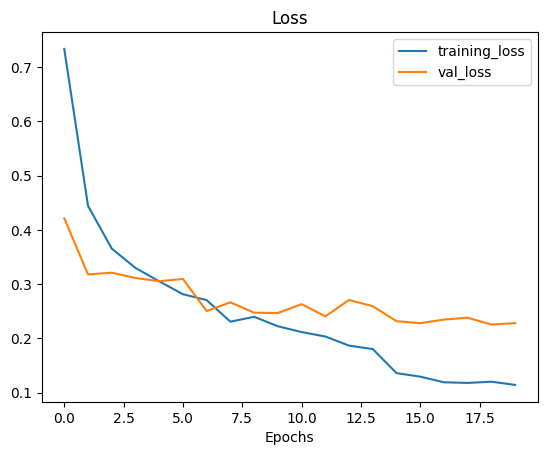

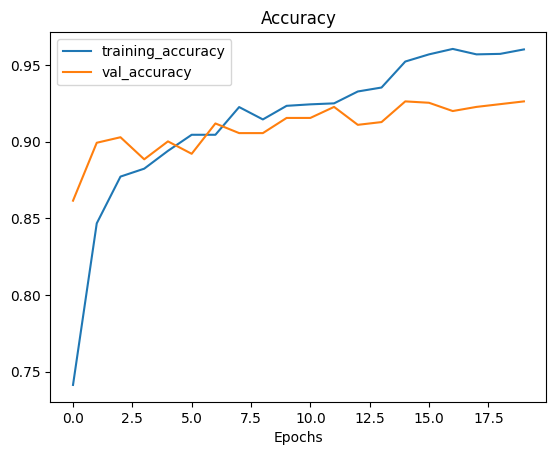

In [60]:
plot_loss_curves(ResNet50_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = ResNet50_model.evaluate(test_data, verbose=0)

[codecarbon INFO @ 11:46:26] Energy consumed for RAM : 0.023319 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:46:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:26] Energy consumed for All CPU : 0.049557 kWh
[codecarbon INFO @ 11:46:26] Energy consumed for all GPUs : 0.115490 kWh. Total GPU Power : 78.4358058024607 W
[codecarbon INFO @ 11:46:26] 0.188366 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:46:26] 0.020081 g.CO2eq/s mean an estimation of 633.2803160840878 kg.CO2eq/year


In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.23114
Test Accuracy: 92.24%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = ResNet50_model.predict(test_data, verbose=1)

28/36 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step

[codecarbon INFO @ 11:46:56] Energy consumed for RAM : 0.023485 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 11:46:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:46:56] Energy consumed for All CPU : 0.049911 kWh
[codecarbon INFO @ 11:46:56] Energy consumed for all GPUs : 0.116277 kWh. Total GPU Power : 92.7440971432294 W
[codecarbon INFO @ 11:46:56] 0.189673 kWh of electricity used since the beginning.


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

  biological       0.96      0.97      0.96        99
   cardboard       0.97      0.96      0.97       182
       glass       0.93      0.92      0.92       305
       metal       0.86      0.93      0.89       100
       paper       0.90      0.95      0.92       165
     plastic       0.93      0.86      0.89       192
       trash       0.85      0.88      0.87        78

    accuracy                           0.92      1121
   macro avg       0.91      0.92      0.92      1121
weighted avg       0.92      0.92      0.92      1121



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

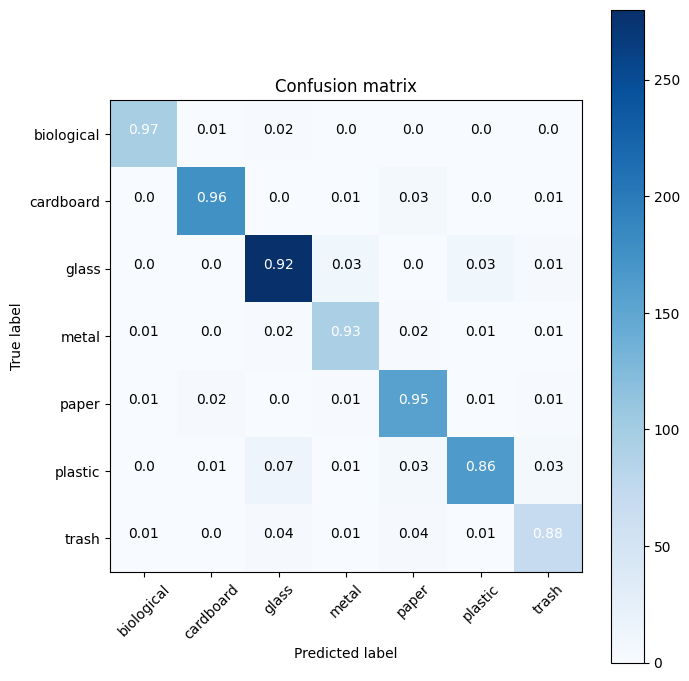

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon WARNING @ 11:47:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:47:15] [setup] RAM Tracking...
[codecarbon INFO @ 11:47:15] [setup] CPU Tracking...
[codecarbon WARNING @ 11:47:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 11:47:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 11:47:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 11:47:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:47:16] [setup] GPU Tracking...
[codecarbon INFO @ 11:47:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:47:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Deploy Model Carbon Emissions: 0.08755675349350645 kg


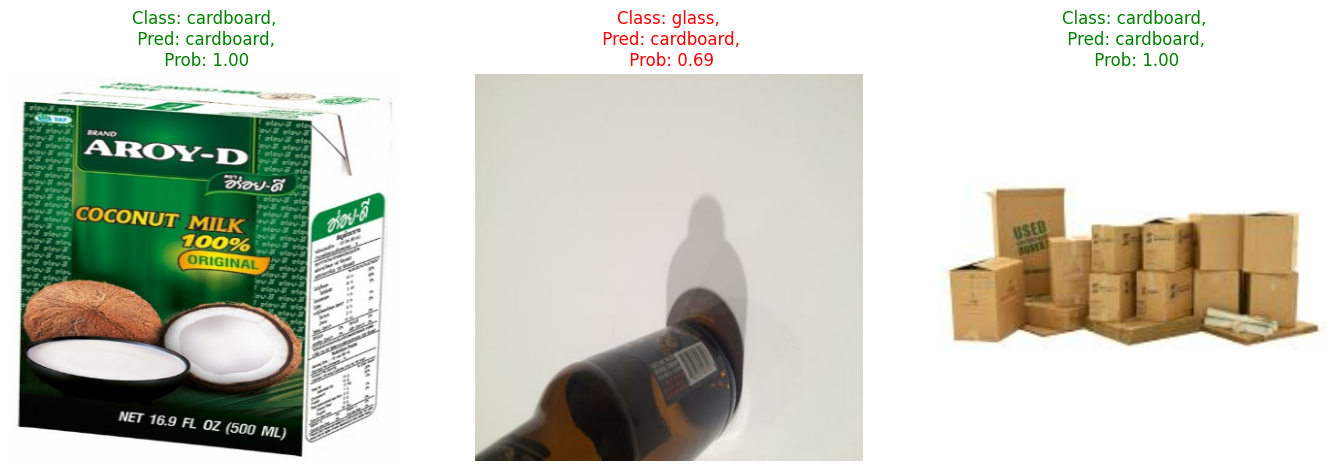

In [71]:
pred_random_images(ResNet50_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(ResNet50_model,open("ResNet50_model.h5","wb"))

In [73]:
ls ../working

data/                      logs/               ResNet50.h5
emissions.csv              logs.zip            ResNet50_model.h5
garbage-classification.h5  __notebook__.ipynb  runs/
